# LSTM v2 包括的ハイパーパラメータ最適化

## 概要
ウィンドウサイズとFusion方式を包括的に最適化し、最高性能のモデル構成を発見します。

### 最適化対象
- **ウィンドウサイズ**: w64_s16 vs w128_s32
- **Fusion方式**: concatenate, attention, gated
- **アーキテクチャパラメータ**: LSTM層、Dense層、Dropout等
- **学習パラメータ**: 学習率、バッチサイズ等

### 評価指標
- **CMI Score**: Competition Metric Index (主要指標)
- **Binary F1**: Target vs Non-target識別性能
- **Macro F1**: 18クラス分類性能
- **Test Accuracy**: 分類精度


In [2]:
#!/usr/bin/env python3
import os
import sys
import numpy as np
import pandas as pd
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

# プロジェクトルートを追加
sys.path.append('../src')

from lstm_v2_trainer import LSTMv2Trainer
from cmi_evaluation import calculate_cmi_score

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import matplotlib.pyplot as plt

print("必要なライブラリの読み込み完了")


必要なライブラリの読み込み完了


In [3]:
# 包括的最適化設定
USE_OPTIMIZED_DEMOGRAPHICS = True
N_TRIALS_PER_CONFIG = 50  # 各ウィンドウ設定あたりの試行数
WINDOW_CONFIGS = ["w64_s16", "w128_s32"]  # 比較するウィンドウサイズ
FUSION_TYPES = ['concatenate', 'attention', 'gated']  # 比較するFusion方式

# 本番用Study名
STUDY_BASE_NAME = "lstm_v2_comprehensive_optimization"
RESULTS_DIR = "../results/comprehensive_optimization"

print(f"🚀 LSTM v2 包括的ハイパーパラメータ最適化")
print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"ウィンドウ設定: {WINDOW_CONFIGS}")
print(f"Fusion方式: {FUSION_TYPES}")
print(f"各設定の試行数: {N_TRIALS_PER_CONFIG}")
print(f"総試行数予定: {N_TRIALS_PER_CONFIG * len(WINDOW_CONFIGS)}")
print(f"最適化されたdemographics使用: {USE_OPTIMIZED_DEMOGRAPHICS}")
print(f"結果保存先: {RESULTS_DIR}")

# 結果保存ディレクトリ作成
import os
os.makedirs(RESULTS_DIR, exist_ok=True)


🚀 LSTM v2 包括的ハイパーパラメータ最適化
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
ウィンドウ設定: ['w64_s16', 'w128_s32']
Fusion方式: ['concatenate', 'attention', 'gated']
各設定の試行数: 50
総試行数予定: 100
最適化されたdemographics使用: True
結果保存先: ../results/comprehensive_optimization


In [4]:
# 各ウィンドウサイズのデータ情報を確認
print("📊 各ウィンドウ設定のデータ情報:")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

for window_config in WINDOW_CONFIGS:
    try:
        # 一時的にトレーナーを作成してデータ情報を取得
        temp_trainer = LSTMv2Trainer(
            experiment_name="temp_info",
            window_config=window_config,
            n_demographics_features=18 if USE_OPTIMIZED_DEMOGRAPHICS else 20
        )
        temp_data = temp_trainer.load_preprocessed_data(use_optimized_demographics=USE_OPTIMIZED_DEMOGRAPHICS)
        
        print(f"{window_config}:")
        print(f"  センサーデータ: {temp_data['X_sensor_windows'].shape}")
        print(f"  Demographics: {temp_data['X_demographics_windows'].shape}")
        print(f"  ラベル: {temp_data['y_windows'].shape}")
        print()
        
        # メモリクリア
        del temp_trainer, temp_data
        
    except Exception as e:
        print(f"{window_config}: データ読み込みエラー - {str(e)}")
        print()

print("✅ データ情報確認完了")


📊 各ウィンドウ設定のデータ情報:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: temp_info
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/temp_info_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
w64_s16:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)

Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: temp_info
ウィンドウ設定: w128_s32
出力ディレクトリ: ../output/experiments/temp_info_w128_s32
前処理済みデータ: ../output/experiments/lstm_v2_w128_s32/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形

In [5]:
def create_objective_function(window_config):
    """
    指定されたウィンドウ設定用のObjective関数を作成
    
    Parameters:
    -----------
    window_config : str
        ウィンドウ設定 ("w64_s16" or "w128_s32")
    
    Returns:
    --------
    function
        Optuna最適化の目的関数
    """
    
    def objective(trial):
        """
        Optuna最適化の目的関数
        """
        try:
            print(f"\n🔍 Trial {trial.number} - {window_config}")
            
            # ハイパーパラメータの提案
            params = {
                # アーキテクチャパラメータ
                'lstm_units_1': trial.suggest_int('lstm_units_1', 32, 128, step=16),
                'lstm_units_2': trial.suggest_int('lstm_units_2', 16, 64, step=8),
                'dense_units': trial.suggest_int('dense_units', 16, 64, step=8),
                'demographics_dense_units': trial.suggest_int('demographics_dense_units', 8, 32, step=4),
                'fusion_dense_units': trial.suggest_int('fusion_dense_units', 16, 48, step=8),
                
                # 正則化パラメータ
                'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.05),
                'dense_dropout_rate': trial.suggest_float('dense_dropout_rate', 0.1, 0.4, step=0.05),
                
                # 学習パラメータ
                'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
                'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
                
                # Fusion方式
                'fusion_type': trial.suggest_categorical('fusion_type', FUSION_TYPES),
                
                # 学習制御パラメータ（本番用設定）
                'epochs': 100,  # 最大エポック数
                'patience': 20,  # 早期停止の待機エポック数
                'reduce_lr_patience': 10,  # 学習率削減の待機エポック数
                'use_tqdm': False,  # 最適化中は進捗バー無効
                'use_tensorboard': False  # 最適化中はTensorBoard無効
            }
            
            # トレーナーの初期化（ウィンドウ設定を動的に設定）
            trainer = LSTMv2Trainer(
                experiment_name=f"trial_{trial.number}_{window_config}",
                window_config=window_config,
                n_demographics_features=18 if USE_OPTIMIZED_DEMOGRAPHICS else 20
            )
            
            # データ読み込み（毎回読み込みで確実性を保証）
            data = trainer.load_preprocessed_data(use_optimized_demographics=USE_OPTIMIZED_DEMOGRAPHICS)
            
            # モデル学習
            results = trainer.train_model(data, model_params=params, fusion_type=params['fusion_type'])
            
            # 予測結果の取得
            predictions = results['results']['predictions']
            
            # CMIスコア計算
            # label_encoderを取得
            label_encoder = data['label_encoder'] if 'label_encoder' in data else None
            
            cmi_score, binary_f1, macro_f1, test_accuracy = calculate_cmi_score(
                predictions,  # y_pred 
                results['test_data'][2],  # y_true
                label_encoder=label_encoder,
                verbose=False
            )
            
            # 詳細な結果をtrial attributesとして記録
            trial.set_user_attr('window_config', window_config)
            trial.set_user_attr('binary_f1', binary_f1)
            trial.set_user_attr('macro_f1', macro_f1)
            trial.set_user_attr('test_accuracy', test_accuracy)
            trial.set_user_attr('fusion_type', params['fusion_type'])
            
            print(f"✅ Trial {trial.number}: CMI={cmi_score:.4f}, Binary F1={binary_f1:.4f}, Fusion={params['fusion_type']}")
            
            # メモリクリア
            del trainer, data, results
            
            return cmi_score
            
        except Exception as e:
            print(f"❌ Trial {trial.number} failed: {str(e)}")
            return 0.0
    
    return objective

print("✅ Objective関数作成完了")


✅ Objective関数作成完了


In [6]:
# 各ウィンドウ設定での最適化実行
all_studies = {}
optimization_results = {}

print(f"🚀 包括的最適化開始")
print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

# WINDOW_CONFIGS = ["w64_s16", "w128_s32"]  # 比較するウィンドウサイズ
# WINDOW_CONFIGS = ["w128_s32"]  # 比較するウィンドウサイズ
WINDOW_CONFIGS = ["w64_s16"]  # 比較するウィンドウサイズ
for window_config in WINDOW_CONFIGS:
    print(f"\n📊 {window_config} での最適化開始")
    print(f"{'='*50}")
    
    # Study名とStorage設定
    study_name = f"{STUDY_BASE_NAME}_{window_config}"
    storage_url = f"sqlite:///{RESULTS_DIR}/{study_name}.db"
    
    # Optunaスタディの作成
    study = optuna.create_study(
        direction='maximize',
        study_name=study_name,
        storage=storage_url,
        sampler=optuna.samplers.TPESampler(seed=42),
        load_if_exists=True
    )
    
    print(f"Study名: {study_name}")
    print(f"既存試行数: {len(study.trials)}")
    
    # 残り試行数を計算
    remaining_trials = max(0, N_TRIALS_PER_CONFIG - len(study.trials))
    if remaining_trials > 0:
        print(f"実行する試行数: {remaining_trials}")
        
        # Objective関数を作成
        objective_func = create_objective_function(window_config)
        
        # 最適化実行
        study.optimize(objective_func, n_trials=remaining_trials)
        
        print(f"✅ {window_config} 最適化完了")
    else:
        print(f"⏭️ {window_config} は既に完了済み")
    
    # 結果を保存
    all_studies[window_config] = study
    
    if study.best_trial:
        optimization_results[window_config] = {
            'best_cmi_score': study.best_value,
            'best_params': study.best_params,
            'best_trial_attrs': study.best_trial.user_attrs,
            'n_trials': len(study.trials)
        }
        print(f"最良CMIスコア: {study.best_value:.4f}")
        print(f"最良Fusion方式: {study.best_trial.user_attrs.get('fusion_type', 'N/A')}")
    else:
        print(f"❌ {window_config}: 成功した試行がありません")

print(f"\n🎉 全ての最適化が完了しました！")
print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")


🚀 包括的最適化開始
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 w64_s16 での最適化開始


[I 2025-07-08 21:05:56,710] Using an existing study with name 'lstm_v2_comprehensive_optimization_w64_s16' instead of creating a new one.


Study名: lstm_v2_comprehensive_optimization_w64_s16
既存試行数: 36
実行する試行数: 14

🔍 Trial 36 - w64_s16
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_36_w64_s16
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/trial_36_w64_s16_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
ハイブリッドモデル学習開始 (融合方式: attention)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上でモデルを作成・学習します
Mixed precision enabled for better GPU performan

I0000 00:00:1751976365.479637  506286 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5660 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6


モデル構築完了
総パラメータ数: 181,042

=== モデルサマリー ===


Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 80)    │    132,160 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 80)    │        320 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 80)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     37,120 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 32)        │        608 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 64)        │        256 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 32)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 64)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 32)        │      1,056 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 48)        │      3,120 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 32)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 48)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 48)        │      1,584 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_sensor     │ (None, 48)        │          0 │ sensor_dropout[0… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_proje… │ (None, 48)        │      1,584 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 181,042 (707.20 KB)

 Trainable params: 180,754 (706.07 KB)

 Non-trainable params: 288 (1.12 KB)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
Epoch 1/100


2025-07-08 21:06:13.078957: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1751976374.208365  769988 cuda_dnn.cc:529] Loaded cuDNN version 90501


267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1499 - loss: 2.7991
Epoch 1: val_loss improved from inf to 2.47966, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.1501 - loss: 2.7984 - val_accuracy: 0.2450 - val_loss: 2.4797 - learning_rate: 0.0040
Epoch 2/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2583 - loss: 2.4500
Epoch 2: val_loss improved from 2.47966 to 2.32697, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.2583 - loss: 2.4499 - val_accuracy: 0.2893 - val_loss: 2.3270 - learning_rate: 0.0040
Epoch 3/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2789 - loss: 2.3378
Epoch 3: val_loss improved from 2.32697 to 2.28436, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.2790 - loss: 2.3377 - val_accuracy: 0.3220 - val_loss: 2.2844 - learning_rate: 0.0040
Epoch 4/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2993 - loss: 2.3105
Epoch 4: val_loss improved from 2.28436 to 2.26390, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.2994 - loss: 2.3105 - val_accuracy: 0.3304 - val_loss: 2.2639 - learning_rate: 0.0040
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3322 - loss: 2.2329
Epoch 5: val_loss improved from 2.26390 to 2.23139, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3322 - loss: 2.2330 - val_accuracy: 0.3341 - val_loss: 2.2314 - learning_rate: 0.0040
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3437 - loss: 2.1810
Epoch 6: val_loss improved from 2.23139 to 2.18091, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3437 - loss: 2.1810 - val_accuracy: 0.3486 - val_loss: 2.1809 - learning_rate: 0.0040
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3567 - loss: 2.1914
Epoch 7: val_loss did not improve from 2.18091
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3567 - loss: 2.1915 - val_accuracy: 0.3420 - val_loss: 2.2028 - learning_rate: 0.0040
Epoch 8/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3668 - loss: 2.1554
Epoch 8: val_loss improved from 2.18091 to 2.16343, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3668 - loss: 2.1555 - val_accuracy: 0.3644 - val_loss: 2.1634 - learning_rate: 0.0040
Epoch 9/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3759 - loss: 2.1546
Epoch 9: val_loss did not improve from 2.16343
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3759 - loss: 2.1546 - val_accuracy: 0.3486 - val_loss: 2.1889 - learning_rate: 0.0040
Epoch 10/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3787 - loss: 2.1662
Epoch 10: val_loss improved from 2.16343 to 2.16070, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3787 - loss: 2.1662 - val_accuracy: 0.3644 - val_loss: 2.1607 - learning_rate: 0.0040
Epoch 11/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4071 - loss: 2.0775
Epoch 11: val_loss improved from 2.16070 to 2.10467, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4071 - loss: 2.0777 - val_accuracy: 0.3952 - val_loss: 2.1047 - learning_rate: 0.0040
Epoch 12/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4125 - loss: 2.0651
Epoch 12: val_loss did not improve from 2.10467
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4124 - loss: 2.0654 - val_accuracy: 0.3915 - val_loss: 2.1140 - learning_rate: 0.0040
Epoch 13/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4168 - loss: 2.0784
Epoch 13: val_loss did not improve from 2.10467
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4168 - loss: 2.0785 - val_accuracy: 0.3906 - val_loss: 2.1536 - learning_rate: 0.0040
Epoch 14/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3958 - loss: 2.1109
Epoch 14: val_loss did not improve from 2.10467
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3959 - loss: 2.1110 - val_accuracy: 0.3747 - val_loss: 2.1896 - learning_rate: 0.0040
Epoch 15/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4465 - loss: 2.0425 - val_accuracy: 0.4279 - val_loss: 2.0906 - learning_rate: 0.0040
Epoch 17/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4417 - loss: 2.0271
Epoch 17: val_loss improved from 2.09063 to 2.05769, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4417 - loss: 2.0273 - val_accuracy: 0.4414 - val_loss: 2.0577 - learning_rate: 0.0040
Epoch 18/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4513 - loss: 2.0034
Epoch 18: val_loss did not improve from 2.05769
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4513 - loss: 2.0035 - val_accuracy: 0.4312 - val_loss: 2.0615 - learning_rate: 0.0040
Epoch 19/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4657 - loss: 1.9774
Epoch 19: val_loss improved from 2.05769 to 2.04000, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4656 - loss: 1.9775 - val_accuracy: 0.4382 - val_loss: 2.0400 - learning_rate: 0.0040
Epoch 20/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4716 - loss: 1.9654
Epoch 20: val_loss improved from 2.04000 to 2.02265, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4716 - loss: 1.9656 - val_accuracy: 0.4536 - val_loss: 2.0226 - learning_rate: 0.0040
Epoch 21/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4683 - loss: 1.9578
Epoch 21: val_loss did not improve from 2.02265
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4683 - loss: 1.9579 - val_accuracy: 0.4540 - val_loss: 2.0369 - learning_rate: 0.0040
Epoch 22/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4842 - loss: 1.9332
Epoch 22: val_loss did not improve from 2.02265
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4842 - loss: 1.9333 - val_accuracy: 0.4503 - val_loss: 2.0670 - learning_rate: 0.0040
Epoch 23/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4800 - loss: 1.9476
Epoch 23: val_loss did not improve from 2.02265
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4800 - loss: 1.9477 - val_accuracy: 0.4158 - val_loss: 2.1098 - learning_rate: 0.0040
Epoch 24/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4812 - loss: 1.9458 - val_accuracy: 0.4587 - val_loss: 2.0110 - learning_rate: 0.0040
Epoch 25/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4933 - loss: 1.8875
Epoch 25: val_loss did not improve from 2.01098
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4932 - loss: 1.8876 - val_accuracy: 0.4634 - val_loss: 2.0286 - learning_rate: 0.0040
Epoch 26/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4974 - loss: 1.8863
Epoch 26: val_loss did not improve from 2.01098
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4974 - loss: 1.8865 - val_accuracy: 0.4573 - val_loss: 2.0141 - learning_rate: 0.0040
Epoch 27/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4937 - loss: 1.8915
Epoch 27: val_loss did not improve from 2.01098
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4937 - loss: 1.8917 - val_accuracy: 0.4620 - val_loss: 2.0313 - learning_rate: 0.0040
Epoch 28/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5015 - loss: 1.8791 - val_accuracy: 0.4517 - val_loss: 2.0098 - learning_rate: 0.0040
Epoch 30/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5044 - loss: 1.8698
Epoch 30: val_loss improved from 2.00985 to 2.00961, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5044 - loss: 1.8698 - val_accuracy: 0.4704 - val_loss: 2.0096 - learning_rate: 0.0040
Epoch 31/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5071 - loss: 1.8564
Epoch 31: val_loss improved from 2.00961 to 1.97060, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5072 - loss: 1.8565 - val_accuracy: 0.4802 - val_loss: 1.9706 - learning_rate: 0.0040
Epoch 32/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5102 - loss: 1.8573
Epoch 32: val_loss did not improve from 1.97060
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5102 - loss: 1.8574 - val_accuracy: 0.4643 - val_loss: 2.0028 - learning_rate: 0.0040
Epoch 33/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5195 - loss: 1.8315
Epoch 33: val_loss improved from 1.97060 to 1.96450, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5195 - loss: 1.8314 - val_accuracy: 0.4876 - val_loss: 1.9645 - learning_rate: 0.0040
Epoch 34/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5386 - loss: 1.7736
Epoch 34: val_loss did not improve from 1.96450
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5385 - loss: 1.7737 - val_accuracy: 0.4680 - val_loss: 2.0382 - learning_rate: 0.0040
Epoch 35/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5230 - loss: 1.8152
Epoch 35: val_loss improved from 1.96450 to 1.94804, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5230 - loss: 1.8152 - val_accuracy: 0.4900 - val_loss: 1.9480 - learning_rate: 0.0040
Epoch 36/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5350 - loss: 1.7976
Epoch 36: val_loss improved from 1.94804 to 1.89536, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5350 - loss: 1.7976 - val_accuracy: 0.5068 - val_loss: 1.8954 - learning_rate: 0.0040
Epoch 37/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5431 - loss: 1.7611
Epoch 37: val_loss did not improve from 1.89536
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5431 - loss: 1.7613 - val_accuracy: 0.4680 - val_loss: 1.9683 - learning_rate: 0.0040
Epoch 38/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5417 - loss: 1.7850
Epoch 38: val_loss did not improve from 1.89536
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5416 - loss: 1.7852 - val_accuracy: 0.4876 - val_loss: 1.9489 - learning_rate: 0.0040
Epoch 39/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5476 - loss: 1.7855
Epoch 39: val_loss did not improve from 1.89536
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5476 - loss: 1.7855 - val_accuracy: 0.4802 - val_loss: 1.9638 - learning_rate: 0.0040
Epoch 40/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5658 - loss: 1.7182 - val_accuracy: 0.5077 - val_loss: 1.8844 - learning_rate: 0.0040
Epoch 44/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5510 - loss: 1.7246
Epoch 44: val_loss did not improve from 1.88442
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5510 - loss: 1.7247 - val_accuracy: 0.5063 - val_loss: 1.9383 - learning_rate: 0.0040
Epoch 45/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5436 - loss: 1.7802
Epoch 45: val_loss did not improve from 1.88442
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5436 - loss: 1.7802 - val_accuracy: 0.5063 - val_loss: 1.9259 - learning_rate: 0.0040
Epoch 46/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5682 - loss: 1.7019
Epoch 46: val_loss did not improve from 1.88442
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5682 - loss: 1.7021 - val_accuracy: 0.5170 - val_loss: 1.9160 - learning_rate: 0.0040
Epoch 47/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5727 - loss: 1.6743 - val_accuracy: 0.5091 - val_loss: 1.8685 - learning_rate: 0.0040
Epoch 48/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5840 - loss: 1.6385
Epoch 48: val_loss did not improve from 1.86854
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5839 - loss: 1.6387 - val_accuracy: 0.5198 - val_loss: 1.9033 - learning_rate: 0.0040
Epoch 49/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5751 - loss: 1.6758
Epoch 49: val_loss did not improve from 1.86854
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5751 - loss: 1.6761 - val_accuracy: 0.5170 - val_loss: 1.9243 - learning_rate: 0.0040
Epoch 50/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5776 - loss: 1.6894
Epoch 50: val_loss did not improve from 1.86854
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5775 - loss: 1.6896 - val_accuracy: 0.5138 - val_loss: 1.8920 - learning_rate: 0.0040
Epoch 51/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5835 - loss: 1.6638 - val_accuracy: 0.5366 - val_loss: 1.8480 - learning_rate: 0.0040
Epoch 52/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5818 - loss: 1.6555
Epoch 52: val_loss did not improve from 1.84798
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5818 - loss: 1.6556 - val_accuracy: 0.5138 - val_loss: 1.9575 - learning_rate: 0.0040
Epoch 53/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5849 - loss: 1.6988
Epoch 53: val_loss did not improve from 1.84798
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.5849 - loss: 1.6989 - val_accuracy: 0.5180 - val_loss: 1.8970 - learning_rate: 0.0040
Epoch 54/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5857 - loss: 1.6270
Epoch 54: val_loss did not improve from 1.84798
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5857 - loss: 1.6274 - val_accuracy: 0.5282 - val_loss: 1.8791 - learning_rate: 0.0040
Epoch 55/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.6047 - loss: 1.6073 - val_accuracy: 0.5306 - val_loss: 1.8319 - learning_rate: 0.0040
Epoch 61/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6245 - loss: 1.5780
Epoch 61: val_loss did not improve from 1.83193
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6243 - loss: 1.5784 - val_accuracy: 0.5301 - val_loss: 1.8925 - learning_rate: 0.0040
Epoch 62/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6079 - loss: 1.5988
Epoch 62: val_loss did not improve from 1.83193
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6079 - loss: 1.5988 - val_accuracy: 0.5175 - val_loss: 1.9130 - learning_rate: 0.0040
Epoch 63/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5975 - loss: 1.6062
Epoch 63: val_loss did not improve from 1.83193
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5975 - loss: 1.6063 - val_accuracy: 0.5306 - val_loss: 1.8538 - learning_rate: 0.0040
Epoch 64/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6359 - loss: 1.5218 - val_accuracy: 0.5497 - val_loss: 1.8240 - learning_rate: 0.0040
Epoch 70/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6393 - loss: 1.4808
Epoch 70: val_loss did not improve from 1.82398
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6393 - loss: 1.4809 - val_accuracy: 0.5278 - val_loss: 1.8491 - learning_rate: 0.0040
Epoch 71/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6383 - loss: 1.5109
Epoch 71: val_loss did not improve from 1.82398
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6383 - loss: 1.5110 - val_accuracy: 0.5306 - val_loss: 1.8813 - learning_rate: 0.0040
Epoch 72/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6390 - loss: 1.5287
Epoch 72: val_loss did not improve from 1.82398
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6389 - loss: 1.5288 - val_accuracy: 0.5483 - val_loss: 1.8636 - learning_rate: 0.0040
Epoch 73/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.6398 - loss: 1.5146 - val_accuracy: 0.5539 - val_loss: 1.8149 - learning_rate: 0.0040
Epoch 74/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6330 - loss: 1.5124
Epoch 74: val_loss did not improve from 1.81487
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6330 - loss: 1.5126 - val_accuracy: 0.5450 - val_loss: 1.8473 - learning_rate: 0.0040
Epoch 75/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6259 - loss: 1.5642
Epoch 75: val_loss did not improve from 1.81487
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6259 - loss: 1.5642 - val_accuracy: 0.5539 - val_loss: 1.8243 - learning_rate: 0.0040
Epoch 76/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6450 - loss: 1.4941
Epoch 76: val_loss did not improve from 1.81487
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6450 - loss: 1.4942 - val_accuracy: 0.5469 - val_loss: 1.8502 - learning_rate: 0.0040
Epoch 77/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6515 - loss: 1.4687 - val_accuracy: 0.5665 - val_loss: 1.7814 - learning_rate: 0.0040
Epoch 81/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6350 - loss: 1.5140
Epoch 81: val_loss did not improve from 1.78136
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6350 - loss: 1.5140 - val_accuracy: 0.5324 - val_loss: 1.9049 - learning_rate: 0.0040
Epoch 82/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6405 - loss: 1.5080
Epoch 82: val_loss did not improve from 1.78136
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6404 - loss: 1.5083 - val_accuracy: 0.5273 - val_loss: 1.9389 - learning_rate: 0.0040
Epoch 83/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6445 - loss: 1.5212
Epoch 83: val_loss did not improve from 1.78136
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6444 - loss: 1.5212 - val_accuracy: 0.5618 - val_loss: 1.7978 - learning_rate: 0.0040
Epoch 84/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7059 - loss: 1.2636 - val_accuracy: 0.5777 - val_loss: 1.7801 - learning_rate: 0.0020
Epoch 93/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7305 - loss: 1.1960
Epoch 93: val_loss did not improve from 1.78014
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7305 - loss: 1.1960 - val_accuracy: 0.5754 - val_loss: 1.8208 - learning_rate: 0.0020
Epoch 94/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7341 - loss: 1.1806
Epoch 94: val_loss did not improve from 1.78014
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7341 - loss: 1.1806 - val_accuracy: 0.5688 - val_loss: 1.7878 - learning_rate: 0.0020
Epoch 95/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7304 - loss: 1.1570
Epoch 95: val_loss improved from 1.78014 to 1.75273, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7304 - loss: 1.1571 - val_accuracy: 0.5810 - val_loss: 1.7527 - learning_rate: 0.0020
Epoch 96/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7418 - loss: 1.1451
Epoch 96: val_loss improved from 1.75273 to 1.73990, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7418 - loss: 1.1451 - val_accuracy: 0.5936 - val_loss: 1.7399 - learning_rate: 0.0020
Epoch 97/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7607 - loss: 1.1014
Epoch 97: val_loss did not improve from 1.73990
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.7607 - loss: 1.1014 - val_accuracy: 0.5959 - val_loss: 1.7531 - learning_rate: 0.0020
Epoch 98/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7569 - loss: 1.0686
Epoch 98: val_loss did not improve from 1.73990
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7569 - loss: 1.0687 - val_accuracy: 0.5950 - val_loss: 1.7402 - learning_rate: 0.0020
Epoch 99/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7716 - loss: 1.0345
Epoch 99: val_loss improved from 1.73990 to 1.72935, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7716 - loss: 1.0347 - val_accuracy: 0.6001 - val_loss: 1.7293 - learning_rate: 0.0020
Epoch 100/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7651 - loss: 1.0553
Epoch 100: val_loss improved from 1.72935 to 1.72328, saving model to ../output/experiments/trial_36_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7651 - loss: 1.0554 - val_accuracy: 0.5945 - val_loss: 1.7233 - learning_rate: 0.0020
Restoring model weights from the end of the best epoch: 100.
学習完了！学習時間: 1140.05秒
最良検証Loss: 1.7233
最良検証Accuracy: 0.6001
ハイブリッドモデル評価中...
テストLoss: 1.7173
テストAccuracy: 0.6062
F1-Score (macro): 0.5730
F1-Score (weighted): 0.6048
結果保存中...
学習履歴保存完了: ../output/experiments/trial_36_w64_s16_w64_s16/results/training_history_attention.json


[I 2025-07-08 21:25:13,239] Trial 36 finished with value: 0.7937435944934252 and parameters: {'lstm_units_1': 80, 'lstm_units_2': 64, 'dense_units': 48, 'demographics_dense_units': 32, 'fusion_dense_units': 48, 'dropout_rate': 0.1, 'dense_dropout_rate': 0.2, 'learning_rate': 0.003959183395187926, 'batch_size': 32, 'fusion_type': 'attention'}. Best is trial 34 with value: 0.8021217206997858.


結果保存完了: ../output/experiments/trial_36_w64_s16_w64_s16/results
✅ Trial 36: CMI=0.7937, Binary F1=0.9583, Fusion=attention

🔍 Trial 37 - w64_s16
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_37_w64_s16
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/trial_37_w64_s16_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
ハイブリッドモデル学習開始 (融合方式: attention)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上でモデルを作成・学習します

Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 80)    │    132,160 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 80)    │        320 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 80)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     37,120 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 28)        │        532 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 64)        │        256 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 28)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 64)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 28)        │        812 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 48)        │      3,120 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 28)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 48)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 48)        │      1,392 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_sensor     │ (None, 48)        │          0 │ sensor_dropout[0… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_proje… │ (None, 48)        │      1,392 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 180,338 (704.45 KB)

 Trainable params: 180,050 (703.32 KB)

 Non-trainable params: 288 (1.12 KB)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
Epoch 1/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1288 - loss: 2.8192
Epoch 1: val_loss improved from inf to 2.47413, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.1291 - loss: 2.8184 - val_accuracy: 0.2594 - val_loss: 2.4741 - learning_rate: 0.0037
Epoch 2/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2446 - loss: 2.4649
Epoch 2: val_loss improved from 2.47413 to 2.32080, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.2447 - loss: 2.4645 - val_accuracy: 0.2902 - val_loss: 2.3208 - learning_rate: 0.0037
Epoch 3/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2921 - loss: 2.3361
Epoch 3: val_loss improved from 2.32080 to 2.24155, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.2920 - loss: 2.3360 - val_accuracy: 0.3252 - val_loss: 2.2415 - learning_rate: 0.0037
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3120 - loss: 2.2666
Epoch 4: val_loss improved from 2.24155 to 2.17758, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3120 - loss: 2.2667 - val_accuracy: 0.3276 - val_loss: 2.1776 - learning_rate: 0.0037
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3149 - loss: 2.2488
Epoch 5: val_loss did not improve from 2.17758
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3149 - loss: 2.2488 - val_accuracy: 0.3318 - val_loss: 2.2574 - learning_rate: 0.0037
Epoch 6/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3389 - loss: 2.1875
Epoch 6: val_loss improved from 2.17758 to 2.14896, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3389 - loss: 2.1876 - val_accuracy: 0.3276 - val_loss: 2.1490 - learning_rate: 0.0037
Epoch 7/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3476 - loss: 2.1423
Epoch 7: val_loss did not improve from 2.14896
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3476 - loss: 2.1426 - val_accuracy: 0.3486 - val_loss: 2.1648 - learning_rate: 0.0037
Epoch 8/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3625 - loss: 2.1549
Epoch 8: val_loss improved from 2.14896 to 2.13910, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3626 - loss: 2.1549 - val_accuracy: 0.3616 - val_loss: 2.1391 - learning_rate: 0.0037
Epoch 9/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3834 - loss: 2.1260
Epoch 9: val_loss improved from 2.13910 to 2.08436, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.3834 - loss: 2.1261 - val_accuracy: 0.3714 - val_loss: 2.0844 - learning_rate: 0.0037
Epoch 10/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3985 - loss: 2.0792
Epoch 10: val_loss did not improve from 2.08436
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3985 - loss: 2.0792 - val_accuracy: 0.3850 - val_loss: 2.0880 - learning_rate: 0.0037
Epoch 11/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3993 - loss: 2.0573
Epoch 11: val_loss did not improve from 2.08436
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3992 - loss: 2.0574 - val_accuracy: 0.3672 - val_loss: 2.1375 - learning_rate: 0.0037
Epoch 12/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4077 - loss: 2.0673
Epoch 12: val_loss improved from 2.08436 to 2.02072, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4077 - loss: 2.0671 - val_accuracy: 0.4041 - val_loss: 2.0207 - learning_rate: 0.0037
Epoch 13/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4169 - loss: 2.0204
Epoch 13: val_loss did not improve from 2.02072
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4169 - loss: 2.0204 - val_accuracy: 0.4116 - val_loss: 2.0793 - learning_rate: 0.0037
Epoch 14/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4158 - loss: 2.0433
Epoch 14: val_loss did not improve from 2.02072
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4158 - loss: 2.0432 - val_accuracy: 0.4097 - val_loss: 2.0327 - learning_rate: 0.0037
Epoch 15/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4515 - loss: 1.9854
Epoch 15: val_loss did not improve from 2.02072
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4514 - loss: 1.9855 - val_accuracy: 0.4321 - val_loss: 2.0254 - learning_rate: 0.0037
Epoch 16/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4472 - loss: 1.9792 - val_accuracy: 0.4200 - val_loss: 2.0123 - learning_rate: 0.0037
Epoch 17/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4532 - loss: 1.9456
Epoch 17: val_loss improved from 2.01231 to 2.01182, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4532 - loss: 1.9457 - val_accuracy: 0.4321 - val_loss: 2.0118 - learning_rate: 0.0037
Epoch 18/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4743 - loss: 1.9245
Epoch 18: val_loss improved from 2.01182 to 1.98068, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4743 - loss: 1.9245 - val_accuracy: 0.4433 - val_loss: 1.9807 - learning_rate: 0.0037
Epoch 19/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4803 - loss: 1.8996
Epoch 19: val_loss did not improve from 1.98068
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4802 - loss: 1.8999 - val_accuracy: 0.4386 - val_loss: 2.0011 - learning_rate: 0.0037
Epoch 20/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4763 - loss: 1.9001
Epoch 20: val_loss did not improve from 1.98068
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4763 - loss: 1.9004 - val_accuracy: 0.4489 - val_loss: 1.9852 - learning_rate: 0.0037
Epoch 21/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4769 - loss: 1.9041
Epoch 21: val_loss did not improve from 1.98068
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4769 - loss: 1.9042 - val_accuracy: 0.4489 - val_loss: 1.9905 - learning_rate: 0.0037
Epoch 22/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.4876 - loss: 1.8527 - val_accuracy: 0.4657 - val_loss: 1.9417 - learning_rate: 0.0037
Epoch 23/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4961 - loss: 1.8555
Epoch 23: val_loss did not improve from 1.94167
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4961 - loss: 1.8555 - val_accuracy: 0.4531 - val_loss: 1.9844 - learning_rate: 0.0037
Epoch 24/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5072 - loss: 1.7936
Epoch 24: val_loss improved from 1.94167 to 1.92229, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5071 - loss: 1.7939 - val_accuracy: 0.4629 - val_loss: 1.9223 - learning_rate: 0.0037
Epoch 25/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5111 - loss: 1.7981
Epoch 25: val_loss did not improve from 1.92229
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5111 - loss: 1.7981 - val_accuracy: 0.4774 - val_loss: 1.9336 - learning_rate: 0.0037
Epoch 26/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5206 - loss: 1.7753
Epoch 26: val_loss did not improve from 1.92229
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5206 - loss: 1.7754 - val_accuracy: 0.4587 - val_loss: 1.9277 - learning_rate: 0.0037
Epoch 27/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5066 - loss: 1.7834
Epoch 27: val_loss did not improve from 1.92229
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5067 - loss: 1.7834 - val_accuracy: 0.4750 - val_loss: 1.9321 - learning_rate: 0.0037
Epoch 28/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5173 - loss: 1.7543 - val_accuracy: 0.4671 - val_loss: 1.9140 - learning_rate: 0.0037
Epoch 29/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5198 - loss: 1.7722
Epoch 29: val_loss improved from 1.91398 to 1.87002, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5197 - loss: 1.7723 - val_accuracy: 0.4844 - val_loss: 1.8700 - learning_rate: 0.0037
Epoch 30/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5309 - loss: 1.7466
Epoch 30: val_loss did not improve from 1.87002
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5308 - loss: 1.7469 - val_accuracy: 0.4764 - val_loss: 1.9373 - learning_rate: 0.0037
Epoch 31/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5332 - loss: 1.7583
Epoch 31: val_loss improved from 1.87002 to 1.86575, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5332 - loss: 1.7582 - val_accuracy: 0.4942 - val_loss: 1.8657 - learning_rate: 0.0037
Epoch 32/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5330 - loss: 1.7129
Epoch 32: val_loss did not improve from 1.86575
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5329 - loss: 1.7131 - val_accuracy: 0.4900 - val_loss: 1.9316 - learning_rate: 0.0037
Epoch 33/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5247 - loss: 1.7612
Epoch 33: val_loss did not improve from 1.86575
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5247 - loss: 1.7613 - val_accuracy: 0.4722 - val_loss: 1.9241 - learning_rate: 0.0037
Epoch 34/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5321 - loss: 1.7500
Epoch 34: val_loss did not improve from 1.86575
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5320 - loss: 1.7501 - val_accuracy: 0.5072 - val_loss: 1.8828 - learning_rate: 0.0037
Epoch 35/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.5306 - loss: 1.7277 - val_accuracy: 0.5012 - val_loss: 1.8515 - learning_rate: 0.0037
Epoch 37/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5403 - loss: 1.7142
Epoch 37: val_loss improved from 1.85145 to 1.83631, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5403 - loss: 1.7142 - val_accuracy: 0.5096 - val_loss: 1.8363 - learning_rate: 0.0037
Epoch 38/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5543 - loss: 1.6545
Epoch 38: val_loss did not improve from 1.83631
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5542 - loss: 1.6546 - val_accuracy: 0.5096 - val_loss: 1.8444 - learning_rate: 0.0037
Epoch 39/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5490 - loss: 1.6553
Epoch 39: val_loss did not improve from 1.83631
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5490 - loss: 1.6553 - val_accuracy: 0.5166 - val_loss: 1.8736 - learning_rate: 0.0037
Epoch 40/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5655 - loss: 1.6623
Epoch 40: val_loss improved from 1.83631 to 1.80862, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5655 - loss: 1.6623 - val_accuracy: 0.5259 - val_loss: 1.8086 - learning_rate: 0.0037
Epoch 41/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5652 - loss: 1.6475
Epoch 41: val_loss did not improve from 1.80862
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5651 - loss: 1.6478 - val_accuracy: 0.5100 - val_loss: 1.8110 - learning_rate: 0.0037
Epoch 42/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5659 - loss: 1.6552
Epoch 42: val_loss did not improve from 1.80862
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5659 - loss: 1.6551 - val_accuracy: 0.5329 - val_loss: 1.8097 - learning_rate: 0.0037
Epoch 43/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5602 - loss: 1.6357
Epoch 43: val_loss did not improve from 1.80862
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5602 - loss: 1.6357 - val_accuracy: 0.5133 - val_loss: 1.8464 - learning_rate: 0.0037
Epoch 44/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.5952 - loss: 1.5848 - val_accuracy: 0.5320 - val_loss: 1.7741 - learning_rate: 0.0037
Epoch 47/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5866 - loss: 1.5722
Epoch 47: val_loss did not improve from 1.77412
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5866 - loss: 1.5724 - val_accuracy: 0.5114 - val_loss: 1.8340 - learning_rate: 0.0037
Epoch 48/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5780 - loss: 1.5865
Epoch 48: val_loss did not improve from 1.77412
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5780 - loss: 1.5866 - val_accuracy: 0.5110 - val_loss: 1.8432 - learning_rate: 0.0037
Epoch 49/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5804 - loss: 1.6086
Epoch 49: val_loss did not improve from 1.77412
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5804 - loss: 1.6087 - val_accuracy: 0.5194 - val_loss: 1.8301 - learning_rate: 0.0037
Epoch 50/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.6335 - loss: 1.4811 - val_accuracy: 0.5660 - val_loss: 1.7536 - learning_rate: 0.0018
Epoch 58/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6585 - loss: 1.3484
Epoch 58: val_loss improved from 1.75362 to 1.73281, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6585 - loss: 1.3485 - val_accuracy: 0.5651 - val_loss: 1.7328 - learning_rate: 0.0018
Epoch 59/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6664 - loss: 1.3185
Epoch 59: val_loss did not improve from 1.73281
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6664 - loss: 1.3186 - val_accuracy: 0.5628 - val_loss: 1.7510 - learning_rate: 0.0018
Epoch 60/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6766 - loss: 1.2955
Epoch 60: val_loss did not improve from 1.73281
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6766 - loss: 1.2955 - val_accuracy: 0.5684 - val_loss: 1.7477 - learning_rate: 0.0018
Epoch 61/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6859 - loss: 1.2359
Epoch 61: val_loss improved from 1.73281 to 1.72800, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6859 - loss: 1.2361 - val_accuracy: 0.5693 - val_loss: 1.7280 - learning_rate: 0.0018
Epoch 62/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6802 - loss: 1.2485
Epoch 62: val_loss improved from 1.72800 to 1.68667, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6802 - loss: 1.2485 - val_accuracy: 0.5772 - val_loss: 1.6867 - learning_rate: 0.0018
Epoch 63/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6827 - loss: 1.2306
Epoch 63: val_loss did not improve from 1.68667
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6828 - loss: 1.2307 - val_accuracy: 0.5684 - val_loss: 1.7399 - learning_rate: 0.0018
Epoch 64/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6880 - loss: 1.2344
Epoch 64: val_loss improved from 1.68667 to 1.65049, saving model to ../output/experiments/trial_37_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6880 - loss: 1.2344 - val_accuracy: 0.5852 - val_loss: 1.6505 - learning_rate: 0.0018
Epoch 65/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6995 - loss: 1.1912
Epoch 65: val_loss did not improve from 1.65049
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6995 - loss: 1.1913 - val_accuracy: 0.5842 - val_loss: 1.6658 - learning_rate: 0.0018
Epoch 66/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7044 - loss: 1.1919
Epoch 66: val_loss did not improve from 1.65049
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.7043 - loss: 1.1919 - val_accuracy: 0.5819 - val_loss: 1.7099 - learning_rate: 0.0018
Epoch 67/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7166 - loss: 1.1569
Epoch 67: val_loss did not improve from 1.65049
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7165 - loss: 1.1569 - val_accuracy: 0.5730 - val_loss: 1.7205 - learning_rate: 0.0018
Epoch 68/100
267/

[I 2025-07-08 21:41:59,837] Trial 37 finished with value: 0.7730779388529894 and parameters: {'lstm_units_1': 80, 'lstm_units_2': 64, 'dense_units': 48, 'demographics_dense_units': 28, 'fusion_dense_units': 48, 'dropout_rate': 0.1, 'dense_dropout_rate': 0.30000000000000004, 'learning_rate': 0.003694009568602056, 'batch_size': 32, 'fusion_type': 'attention'}. Best is trial 34 with value: 0.8021217206997858.


結果保存完了: ../output/experiments/trial_37_w64_s16_w64_s16/results
✅ Trial 37: CMI=0.7731, Binary F1=0.9495, Fusion=attention

🔍 Trial 38 - w64_s16
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_38_w64_s16
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/trial_38_w64_s16_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
ハイブリッドモデル学習開始 (融合方式: attention)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上でモデルを作成・学習します

Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 96)    │    164,736 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 96)    │        384 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 96)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     41,216 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 24)        │        456 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 64)        │        256 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 24)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 64)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 24)        │        600 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 48)        │      3,120 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 24)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 48)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 48)        │      1,200 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_sensor     │ (None, 48)        │          0 │ sensor_dropout[0… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_proje… │ (None, 48)        │      1,200 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 216,402 (845.32 KB)

 Trainable params: 216,082 (844.07 KB)

 Non-trainable params: 320 (1.25 KB)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1311 - loss: 2.7875
Epoch 1: val_loss improved from inf to 2.43195, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.1312 - loss: 2.7870 - val_accuracy: 0.2221 - val_loss: 2.4319 - learning_rate: 0.0027
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2530 - loss: 2.3774
Epoch 2: val_loss improved from 2.43195 to 2.21971, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.2530 - loss: 2.3772 - val_accuracy: 0.2991 - val_loss: 2.2197 - learning_rate: 0.0027
Epoch 3/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2977 - loss: 2.1926
Epoch 3: val_loss improved from 2.21971 to 2.11699, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.2977 - loss: 2.1926 - val_accuracy: 0.3229 - val_loss: 2.1170 - learning_rate: 0.0027
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3317 - loss: 2.1190
Epoch 4: val_loss did not improve from 2.11699
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.3317 - loss: 2.1190 - val_accuracy: 0.3355 - val_loss: 2.1250 - learning_rate: 0.0027
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3510 - loss: 2.0833
Epoch 5: val_loss did not improve from 2.11699
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.3510 - loss: 2.0833 - val_accuracy: 0.3355 - val_loss: 2.1179 - learning_rate: 0.0027
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3623 - loss: 2.0531
Epoch 6: val_loss improved from 2.11699 to 2.02113, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.3623 - loss: 2.0531 - val_accuracy: 0.3612 - val_loss: 2.0211 - learning_rate: 0.0027
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3772 - loss: 2.0000
Epoch 7: val_loss improved from 2.02113 to 1.99873, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.3772 - loss: 2.0001 - val_accuracy: 0.3892 - val_loss: 1.9987 - learning_rate: 0.0027
Epoch 8/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4042 - loss: 1.9531
Epoch 8: val_loss improved from 1.99873 to 1.98819, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4042 - loss: 1.9532 - val_accuracy: 0.4004 - val_loss: 1.9882 - learning_rate: 0.0027
Epoch 9/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4084 - loss: 1.9142
Epoch 9: val_loss improved from 1.98819 to 1.94196, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4084 - loss: 1.9143 - val_accuracy: 0.4130 - val_loss: 1.9420 - learning_rate: 0.0027
Epoch 10/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4260 - loss: 1.8724
Epoch 10: val_loss improved from 1.94196 to 1.93590, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4259 - loss: 1.8724 - val_accuracy: 0.4046 - val_loss: 1.9359 - learning_rate: 0.0027
Epoch 11/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4331 - loss: 1.8586
Epoch 11: val_loss improved from 1.93590 to 1.91823, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4331 - loss: 1.8586 - val_accuracy: 0.4176 - val_loss: 1.9182 - learning_rate: 0.0027
Epoch 12/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4532 - loss: 1.8107
Epoch 12: val_loss did not improve from 1.91823
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4532 - loss: 1.8108 - val_accuracy: 0.4260 - val_loss: 1.9530 - learning_rate: 0.0027
Epoch 13/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4628 - loss: 1.8051
Epoch 13: val_loss did not improve from 1.91823
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4628 - loss: 1.8051 - val_accuracy: 0.4148 - val_loss: 2.0318 - learning_rate: 0.0027
Epoch 14/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4555 - loss: 1.8177
Epoch 14: val_loss improved from 1.91823 to 1.88198, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4556 - loss: 1.8176 - val_accuracy: 0.4484 - val_loss: 1.8820 - learning_rate: 0.0027
Epoch 15/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4837 - loss: 1.7757
Epoch 15: val_loss did not improve from 1.88198
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4837 - loss: 1.7758 - val_accuracy: 0.4489 - val_loss: 1.9254 - learning_rate: 0.0027
Epoch 16/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4897 - loss: 1.7644
Epoch 16: val_loss did not improve from 1.88198
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4896 - loss: 1.7645 - val_accuracy: 0.4386 - val_loss: 1.9256 - learning_rate: 0.0027
Epoch 17/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4935 - loss: 1.7562
Epoch 17: val_loss improved from 1.88198 to 1.87409, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4934 - loss: 1.7563 - val_accuracy: 0.4559 - val_loss: 1.8741 - learning_rate: 0.0027
Epoch 18/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5001 - loss: 1.6946
Epoch 18: val_loss did not improve from 1.87409
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5000 - loss: 1.6948 - val_accuracy: 0.4596 - val_loss: 1.9081 - learning_rate: 0.0027
Epoch 19/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5091 - loss: 1.6734
Epoch 19: val_loss improved from 1.87409 to 1.84272, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5090 - loss: 1.6735 - val_accuracy: 0.4587 - val_loss: 1.8427 - learning_rate: 0.0027
Epoch 20/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5186 - loss: 1.6733
Epoch 20: val_loss did not improve from 1.84272
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5186 - loss: 1.6733 - val_accuracy: 0.4680 - val_loss: 1.8749 - learning_rate: 0.0027
Epoch 21/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5247 - loss: 1.6376
Epoch 21: val_loss improved from 1.84272 to 1.83858, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5247 - loss: 1.6377 - val_accuracy: 0.4914 - val_loss: 1.8386 - learning_rate: 0.0027
Epoch 22/100
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5379 - loss: 1.6361
Epoch 22: val_loss did not improve from 1.83858
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.5379 - loss: 1.6361 - val_accuracy: 0.4792 - val_loss: 1.8723 - learning_rate: 0.0027
Epoch 23/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5424 - loss: 1.6347
Epoch 23: val_loss improved from 1.83858 to 1.83773, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5423 - loss: 1.6348 - val_accuracy: 0.4648 - val_loss: 1.8377 - learning_rate: 0.0027
Epoch 24/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5517 - loss: 1.6055
Epoch 24: val_loss improved from 1.83773 to 1.79378, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5518 - loss: 1.6054 - val_accuracy: 0.5077 - val_loss: 1.7938 - learning_rate: 0.0027
Epoch 25/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5654 - loss: 1.5663
Epoch 25: val_loss did not improve from 1.79378
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5653 - loss: 1.5666 - val_accuracy: 0.5012 - val_loss: 1.8057 - learning_rate: 0.0027
Epoch 26/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5636 - loss: 1.5588
Epoch 26: val_loss did not improve from 1.79378
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5636 - loss: 1.5590 - val_accuracy: 0.4615 - val_loss: 1.9067 - learning_rate: 0.0027
Epoch 27/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5477 - loss: 1.6432
Epoch 27: val_loss improved from 1.79378 to 1.78663, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5477 - loss: 1.6432 - val_accuracy: 0.5110 - val_loss: 1.7866 - learning_rate: 0.0027
Epoch 28/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5702 - loss: 1.5523
Epoch 28: val_loss did not improve from 1.78663
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5702 - loss: 1.5523 - val_accuracy: 0.5161 - val_loss: 1.8087 - learning_rate: 0.0027
Epoch 29/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5848 - loss: 1.5579
Epoch 29: val_loss did not improve from 1.78663
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.5848 - loss: 1.5579 - val_accuracy: 0.4988 - val_loss: 1.8249 - learning_rate: 0.0027
Epoch 30/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5906 - loss: 1.5176
Epoch 30: val_loss improved from 1.78663 to 1.78536, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5906 - loss: 1.5180 - val_accuracy: 0.4984 - val_loss: 1.7854 - learning_rate: 0.0027
Epoch 31/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5880 - loss: 1.5163
Epoch 31: val_loss did not improve from 1.78536
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5879 - loss: 1.5165 - val_accuracy: 0.4998 - val_loss: 1.8121 - learning_rate: 0.0027
Epoch 32/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5790 - loss: 1.5475
Epoch 32: val_loss did not improve from 1.78536
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.5790 - loss: 1.5479 - val_accuracy: 0.4918 - val_loss: 1.8483 - learning_rate: 0.0027
Epoch 33/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5905 - loss: 1.5345
Epoch 33: val_loss did not improve from 1.78536
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.5905 - loss: 1.5346 - val_accuracy: 0.5226 - val_loss: 1.8342 - learning_rate: 0.0027
Epoch 34/100
267/26

268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5960 - loss: 1.5194 - val_accuracy: 0.5268 - val_loss: 1.7542 - learning_rate: 0.0027
Epoch 35/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6075 - loss: 1.4648
Epoch 35: val_loss did not improve from 1.75419
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6075 - loss: 1.4650 - val_accuracy: 0.5385 - val_loss: 1.8184 - learning_rate: 0.0027
Epoch 36/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6124 - loss: 1.4747
Epoch 36: val_loss did not improve from 1.75419
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6123 - loss: 1.4748 - val_accuracy: 0.5380 - val_loss: 1.8010 - learning_rate: 0.0027
Epoch 37/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6196 - loss: 1.4761
Epoch 37: val_loss did not improve from 1.75419
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6196 - loss: 1.4763 - val_accuracy: 0.5320 - val_loss: 1.8248 - learning_rate: 0.0027
Epoch 38/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6415 - loss: 1.4333 - val_accuracy: 0.5558 - val_loss: 1.7464 - learning_rate: 0.0027
Epoch 43/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6510 - loss: 1.3910
Epoch 43: val_loss did not improve from 1.74636
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.6509 - loss: 1.3912 - val_accuracy: 0.5581 - val_loss: 1.7820 - learning_rate: 0.0027
Epoch 44/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6580 - loss: 1.3994
Epoch 44: val_loss did not improve from 1.74636
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6579 - loss: 1.3996 - val_accuracy: 0.5450 - val_loss: 1.7767 - learning_rate: 0.0027
Epoch 45/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6549 - loss: 1.3995
Epoch 45: val_loss did not improve from 1.74636
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6548 - loss: 1.3996 - val_accuracy: 0.5492 - val_loss: 1.8261 - learning_rate: 0.0027
Epoch 46/100
268/2

268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7093 - loss: 1.2907 - val_accuracy: 0.5884 - val_loss: 1.7061 - learning_rate: 0.0013
Epoch 54/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7266 - loss: 1.2138
Epoch 54: val_loss did not improve from 1.70613
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7266 - loss: 1.2137 - val_accuracy: 0.5987 - val_loss: 1.7130 - learning_rate: 0.0013
Epoch 55/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7320 - loss: 1.1779
Epoch 55: val_loss improved from 1.70613 to 1.68002, saving model to ../output/experiments/trial_38_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7320 - loss: 1.1779 - val_accuracy: 0.5931 - val_loss: 1.6800 - learning_rate: 0.0013
Epoch 56/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7525 - loss: 1.1267
Epoch 56: val_loss did not improve from 1.68002
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7524 - loss: 1.1268 - val_accuracy: 0.6029 - val_loss: 1.7326 - learning_rate: 0.0013
Epoch 57/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7688 - loss: 1.0940
Epoch 57: val_loss did not improve from 1.68002
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7688 - loss: 1.0940 - val_accuracy: 0.6048 - val_loss: 1.8059 - learning_rate: 0.0013
Epoch 58/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7860 - loss: 1.0304
Epoch 58: val_loss did not improve from 1.68002
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7860 - loss: 1.0304 - val_accuracy: 0.6178 - val_loss: 1.7387 - learning_rate: 0.0013
Epoch 59/100
268/

[I 2025-07-08 21:54:27,254] Trial 38 finished with value: 0.7822053579762716 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 64, 'dense_units': 48, 'demographics_dense_units': 24, 'fusion_dense_units': 48, 'dropout_rate': 0.1, 'dense_dropout_rate': 0.2, 'learning_rate': 0.0026543342098933158, 'batch_size': 32, 'fusion_type': 'attention'}. Best is trial 34 with value: 0.8021217206997858.


結果保存完了: ../output/experiments/trial_38_w64_s16_w64_s16/results
✅ Trial 38: CMI=0.7822, Binary F1=0.9486, Fusion=attention

🔍 Trial 39 - w64_s16
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_39_w64_s16
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/trial_39_w64_s16_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
ハイブリッドモデル学習開始 (融合方式: attention)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上でモデルを作成・学習します

Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 80)    │    132,160 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 80)    │        320 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 80)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 48)        │     24,768 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 24)        │        456 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 48)        │        192 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 24)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 48)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 24)        │        600 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 32)        │      1,568 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 24)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 32)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 32)        │        800 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_sensor     │ (None, 32)        │          0 │ sensor_dropout[0… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_proje… │ (None, 32)        │        800 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 164,130 (641.13 KB)

 Trainable params: 163,874 (640.13 KB)

 Non-trainable params: 256 (1.00 KB)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
Epoch 1/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1088 - loss: 2.8724
Epoch 1: val_loss improved from inf to 2.65866, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.1093 - loss: 2.8711 - val_accuracy: 0.1918 - val_loss: 2.6587 - learning_rate: 0.0027
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1954 - loss: 2.5626
Epoch 2: val_loss improved from 2.65866 to 2.37711, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.1955 - loss: 2.5621 - val_accuracy: 0.2329 - val_loss: 2.3771 - learning_rate: 0.0027
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2582 - loss: 2.3136
Epoch 3: val_loss improved from 2.37711 to 2.15874, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.2582 - loss: 2.3134 - val_accuracy: 0.2954 - val_loss: 2.1587 - learning_rate: 0.0027
Epoch 4/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3001 - loss: 2.1555
Epoch 4: val_loss improved from 2.15874 to 2.07479, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.3001 - loss: 2.1556 - val_accuracy: 0.3005 - val_loss: 2.0748 - learning_rate: 0.0027
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3247 - loss: 2.0759
Epoch 5: val_loss improved from 2.07479 to 2.07363, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.3246 - loss: 2.0759 - val_accuracy: 0.3201 - val_loss: 2.0736 - learning_rate: 0.0027
Epoch 6/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3371 - loss: 2.0308
Epoch 6: val_loss improved from 2.07363 to 2.00935, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.3370 - loss: 2.0310 - val_accuracy: 0.3374 - val_loss: 2.0094 - learning_rate: 0.0027
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3570 - loss: 1.9479
Epoch 7: val_loss improved from 2.00935 to 1.97817, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.3570 - loss: 1.9480 - val_accuracy: 0.3495 - val_loss: 1.9782 - learning_rate: 0.0027
Epoch 8/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3608 - loss: 1.9291
Epoch 8: val_loss improved from 1.97817 to 1.95761, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3607 - loss: 1.9294 - val_accuracy: 0.3518 - val_loss: 1.9576 - learning_rate: 0.0027
Epoch 9/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3820 - loss: 1.8688
Epoch 9: val_loss did not improve from 1.95761
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.3819 - loss: 1.8693 - val_accuracy: 0.3640 - val_loss: 1.9867 - learning_rate: 0.0027
Epoch 10/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3982 - loss: 1.8739
Epoch 10: val_loss improved from 1.95761 to 1.89288, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.3981 - loss: 1.8739 - val_accuracy: 0.3840 - val_loss: 1.8929 - learning_rate: 0.0027
Epoch 11/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3898 - loss: 1.8668
Epoch 11: val_loss improved from 1.89288 to 1.86970, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.3899 - loss: 1.8666 - val_accuracy: 0.3836 - val_loss: 1.8697 - learning_rate: 0.0027
Epoch 12/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4123 - loss: 1.7533
Epoch 12: val_loss improved from 1.86970 to 1.85994, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4122 - loss: 1.7536 - val_accuracy: 0.3966 - val_loss: 1.8599 - learning_rate: 0.0027
Epoch 13/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4103 - loss: 1.8053
Epoch 13: val_loss did not improve from 1.85994
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4103 - loss: 1.8054 - val_accuracy: 0.3934 - val_loss: 1.8712 - learning_rate: 0.0027
Epoch 14/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4283 - loss: 1.7260
Epoch 14: val_loss did not improve from 1.85994
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.4283 - loss: 1.7266 - val_accuracy: 0.3756 - val_loss: 2.0020 - learning_rate: 0.0027
Epoch 15/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4417 - loss: 1.7391
Epoch 15: val_loss improved from 1.85994 to 1.85927, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4417 - loss: 1.7390 - val_accuracy: 0.4050 - val_loss: 1.8593 - learning_rate: 0.0027
Epoch 16/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4443 - loss: 1.6963
Epoch 16: val_loss improved from 1.85927 to 1.79788, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4442 - loss: 1.6965 - val_accuracy: 0.4316 - val_loss: 1.7979 - learning_rate: 0.0027
Epoch 17/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4474 - loss: 1.6706
Epoch 17: val_loss did not improve from 1.79788
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.4473 - loss: 1.6710 - val_accuracy: 0.4265 - val_loss: 1.8887 - learning_rate: 0.0027
Epoch 18/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4539 - loss: 1.6967
Epoch 18: val_loss did not improve from 1.79788
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4540 - loss: 1.6968 - val_accuracy: 0.4391 - val_loss: 1.8343 - learning_rate: 0.0027
Epoch 19/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4737 - loss: 1.6443
Epoch 19: val_loss improved from 1.79788 to 1.77816, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4736 - loss: 1.6445 - val_accuracy: 0.4503 - val_loss: 1.7782 - learning_rate: 0.0027
Epoch 20/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4712 - loss: 1.6294
Epoch 20: val_loss did not improve from 1.77816
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4712 - loss: 1.6296 - val_accuracy: 0.4260 - val_loss: 1.8402 - learning_rate: 0.0027
Epoch 21/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4607 - loss: 1.6312
Epoch 21: val_loss did not improve from 1.77816
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.4608 - loss: 1.6312 - val_accuracy: 0.4396 - val_loss: 1.8823 - learning_rate: 0.0027
Epoch 22/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4689 - loss: 1.6185
Epoch 22: val_loss did not improve from 1.77816
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.4689 - loss: 1.6187 - val_accuracy: 0.4326 - val_loss: 1.8526 - learning_rate: 0.0027
Epoch 23/100
134/134 

134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4956 - loss: 1.5832 - val_accuracy: 0.4531 - val_loss: 1.7727 - learning_rate: 0.0027
Epoch 25/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4916 - loss: 1.5615
Epoch 25: val_loss did not improve from 1.77268
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4917 - loss: 1.5614 - val_accuracy: 0.4657 - val_loss: 1.7944 - learning_rate: 0.0027
Epoch 26/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5007 - loss: 1.5434
Epoch 26: val_loss improved from 1.77268 to 1.72708, saving model to ../output/experiments/trial_39_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5007 - loss: 1.5436 - val_accuracy: 0.4610 - val_loss: 1.7271 - learning_rate: 0.0027
Epoch 27/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5204 - loss: 1.5020
Epoch 27: val_loss did not improve from 1.72708
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5202 - loss: 1.5027 - val_accuracy: 0.4414 - val_loss: 1.7984 - learning_rate: 0.0027
Epoch 28/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5107 - loss: 1.5760
Epoch 28: val_loss did not improve from 1.72708
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.5106 - loss: 1.5760 - val_accuracy: 0.4671 - val_loss: 1.7644 - learning_rate: 0.0027
Epoch 29/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5195 - loss: 1.4938
Epoch 29: val_loss did not improve from 1.72708
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.5196 - loss: 1.4938 - val_accuracy: 0.4648 - val_loss: 1.7728 - learning_rate: 0.0027
Epoch 30/100
133/134

134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.5449 - loss: 1.4737 - val_accuracy: 0.4596 - val_loss: 1.7200 - learning_rate: 0.0027
Epoch 33/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5400 - loss: 1.4763
Epoch 33: val_loss did not improve from 1.71997
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.5399 - loss: 1.4764 - val_accuracy: 0.4657 - val_loss: 1.7651 - learning_rate: 0.0027
Epoch 34/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5345 - loss: 1.4686
Epoch 34: val_loss did not improve from 1.71997
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.5345 - loss: 1.4686 - val_accuracy: 0.4676 - val_loss: 1.8007 - learning_rate: 0.0027
Epoch 35/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5535 - loss: 1.4244
Epoch 35: val_loss did not improve from 1.71997
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.5533 - loss: 1.4247 - val_accuracy: 0.4844 - val_loss: 1.7849 - learning_rate: 0.0027
Epoch 36/100
134/134 

134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.5604 - loss: 1.4357 - val_accuracy: 0.5212 - val_loss: 1.7011 - learning_rate: 0.0027
Epoch 43/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5721 - loss: 1.4121
Epoch 43: val_loss did not improve from 1.70115
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.5720 - loss: 1.4124 - val_accuracy: 0.4998 - val_loss: 1.8115 - learning_rate: 0.0027
Epoch 44/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5721 - loss: 1.3649
Epoch 44: val_loss did not improve from 1.70115
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.5722 - loss: 1.3648 - val_accuracy: 0.5063 - val_loss: 1.8127 - learning_rate: 0.0027
Epoch 45/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5824 - loss: 1.3537
Epoch 45: val_loss did not improve from 1.70115
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5824 - loss: 1.3539 - val_accuracy: 0.5021 - val_loss: 1.8347 - learning_rate: 0.0027
Epoch 46/100
134/134 

134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6168 - loss: 1.2851 - val_accuracy: 0.5287 - val_loss: 1.6972 - learning_rate: 0.0013
Epoch 54/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6428 - loss: 1.2027
Epoch 54: val_loss did not improve from 1.69716
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6427 - loss: 1.2028 - val_accuracy: 0.5446 - val_loss: 1.7033 - learning_rate: 0.0013
Epoch 55/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6557 - loss: 1.1558
Epoch 55: val_loss did not improve from 1.69716
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6557 - loss: 1.1558 - val_accuracy: 0.5483 - val_loss: 1.7195 - learning_rate: 0.0013
Epoch 56/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6602 - loss: 1.1563
Epoch 56: val_loss did not improve from 1.69716
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6601 - loss: 1.1563 - val_accuracy: 0.5432 - val_loss: 1.7424 - learning_rate: 0.0013
Epoch 57/100
133/134 

[I 2025-07-08 22:01:53,341] Trial 39 finished with value: 0.7356274911048908 and parameters: {'lstm_units_1': 80, 'lstm_units_2': 48, 'dense_units': 32, 'demographics_dense_units': 24, 'fusion_dense_units': 48, 'dropout_rate': 0.2, 'dense_dropout_rate': 0.30000000000000004, 'learning_rate': 0.0026835472932003213, 'batch_size': 64, 'fusion_type': 'attention'}. Best is trial 34 with value: 0.8021217206997858.


結果保存完了: ../output/experiments/trial_39_w64_s16_w64_s16/results
✅ Trial 39: CMI=0.7356, Binary F1=0.9427, Fusion=attention

🔍 Trial 40 - w64_s16
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_40_w64_s16
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/trial_40_w64_s16_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
ハイブリッドモデル学習開始 (融合方式: attention)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上でモデルを作成・学習します

Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 80)    │    132,160 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 80)    │        320 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 80)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     37,120 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 32)        │        608 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 64)        │        256 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 32)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 64)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 32)        │      1,056 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 40)        │      2,600 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 32)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 40)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 40)        │      1,320 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_sensor     │ (None, 40)        │          0 │ sensor_dropout[0… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_proje… │ (None, 40)        │      1,320 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 179,610 (701.60 KB)

 Trainable params: 179,322 (700.48 KB)

 Non-trainable params: 288 (1.12 KB)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1416 - loss: 2.7703
Epoch 1: val_loss improved from inf to 2.43846, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.1418 - loss: 2.7698 - val_accuracy: 0.2571 - val_loss: 2.4385 - learning_rate: 0.0040
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2701 - loss: 2.3691
Epoch 2: val_loss improved from 2.43846 to 2.23446, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.2701 - loss: 2.3691 - val_accuracy: 0.2940 - val_loss: 2.2345 - learning_rate: 0.0040
Epoch 3/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3000 - loss: 2.2817
Epoch 3: val_loss did not improve from 2.23446
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3000 - loss: 2.2817 - val_accuracy: 0.3000 - val_loss: 2.2635 - learning_rate: 0.0040
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3140 - loss: 2.2805
Epoch 4: val_loss improved from 2.23446 to 2.21262, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3140 - loss: 2.2805 - val_accuracy: 0.3206 - val_loss: 2.2126 - learning_rate: 0.0040
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3324 - loss: 2.2373
Epoch 5: val_loss did not improve from 2.21262
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3324 - loss: 2.2373 - val_accuracy: 0.3285 - val_loss: 2.2233 - learning_rate: 0.0040
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3477 - loss: 2.2014
Epoch 6: val_loss improved from 2.21262 to 2.19902, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3477 - loss: 2.2015 - val_accuracy: 0.3392 - val_loss: 2.1990 - learning_rate: 0.0040
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3555 - loss: 2.2016
Epoch 7: val_loss improved from 2.19902 to 2.19730, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3555 - loss: 2.2017 - val_accuracy: 0.3439 - val_loss: 2.1973 - learning_rate: 0.0040
Epoch 8/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3605 - loss: 2.1786
Epoch 8: val_loss did not improve from 2.19730
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3605 - loss: 2.1788 - val_accuracy: 0.3490 - val_loss: 2.2270 - learning_rate: 0.0040
Epoch 9/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3787 - loss: 2.1323
Epoch 9: val_loss improved from 2.19730 to 2.17199, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3787 - loss: 2.1324 - val_accuracy: 0.3710 - val_loss: 2.1720 - learning_rate: 0.0040
Epoch 10/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3908 - loss: 2.1102
Epoch 10: val_loss improved from 2.17199 to 2.15521, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3908 - loss: 2.1103 - val_accuracy: 0.3775 - val_loss: 2.1552 - learning_rate: 0.0040
Epoch 11/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3878 - loss: 2.1785
Epoch 11: val_loss improved from 2.15521 to 2.13538, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3878 - loss: 2.1784 - val_accuracy: 0.3971 - val_loss: 2.1354 - learning_rate: 0.0040
Epoch 12/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4006 - loss: 2.1330
Epoch 12: val_loss did not improve from 2.13538
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4006 - loss: 2.1330 - val_accuracy: 0.4004 - val_loss: 2.1767 - learning_rate: 0.0040
Epoch 13/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4166 - loss: 2.0779
Epoch 13: val_loss did not improve from 2.13538
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4166 - loss: 2.0781 - val_accuracy: 0.3985 - val_loss: 2.1506 - learning_rate: 0.0040
Epoch 14/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4167 - loss: 2.1069
Epoch 14: val_loss improved from 2.13538 to 2.09703, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4167 - loss: 2.1069 - val_accuracy: 0.4130 - val_loss: 2.0970 - learning_rate: 0.0040
Epoch 15/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4395 - loss: 2.0536
Epoch 15: val_loss improved from 2.09703 to 2.08458, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4395 - loss: 2.0536 - val_accuracy: 0.4153 - val_loss: 2.0846 - learning_rate: 0.0040
Epoch 16/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4462 - loss: 2.0109
Epoch 16: val_loss did not improve from 2.08458
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4462 - loss: 2.0110 - val_accuracy: 0.4190 - val_loss: 2.0861 - learning_rate: 0.0040
Epoch 17/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4534 - loss: 1.9953
Epoch 17: val_loss did not improve from 2.08458
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4534 - loss: 1.9954 - val_accuracy: 0.4139 - val_loss: 2.1026 - learning_rate: 0.0040
Epoch 18/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4477 - loss: 2.0176
Epoch 18: val_loss improved from 2.08458 to 2.07610, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4477 - loss: 2.0176 - val_accuracy: 0.4251 - val_loss: 2.0761 - learning_rate: 0.0040
Epoch 19/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4604 - loss: 1.9885
Epoch 19: val_loss did not improve from 2.07610
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4604 - loss: 1.9886 - val_accuracy: 0.4074 - val_loss: 2.1652 - learning_rate: 0.0040
Epoch 20/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4407 - loss: 2.0427
Epoch 20: val_loss improved from 2.07610 to 2.02834, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4408 - loss: 2.0424 - val_accuracy: 0.4414 - val_loss: 2.0283 - learning_rate: 0.0040
Epoch 21/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4796 - loss: 1.9321
Epoch 21: val_loss did not improve from 2.02834
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4795 - loss: 1.9322 - val_accuracy: 0.4354 - val_loss: 2.0363 - learning_rate: 0.0040
Epoch 22/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4699 - loss: 1.9342
Epoch 22: val_loss did not improve from 2.02834
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4699 - loss: 1.9344 - val_accuracy: 0.4545 - val_loss: 2.0332 - learning_rate: 0.0040
Epoch 23/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4640 - loss: 1.9867
Epoch 23: val_loss did not improve from 2.02834
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4640 - loss: 1.9867 - val_accuracy: 0.4512 - val_loss: 2.0364 - learning_rate: 0.0040
Epoch 24/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4796 - loss: 1.9267 - val_accuracy: 0.4685 - val_loss: 1.9771 - learning_rate: 0.0040
Epoch 25/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4761 - loss: 1.9493
Epoch 25: val_loss did not improve from 1.97707
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4761 - loss: 1.9494 - val_accuracy: 0.4545 - val_loss: 2.0319 - learning_rate: 0.0040
Epoch 26/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4654 - loss: 2.0098
Epoch 26: val_loss did not improve from 1.97707
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4655 - loss: 2.0097 - val_accuracy: 0.4433 - val_loss: 2.0680 - learning_rate: 0.0040
Epoch 27/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4819 - loss: 1.9497
Epoch 27: val_loss did not improve from 1.97707
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4819 - loss: 1.9498 - val_accuracy: 0.4601 - val_loss: 2.0413 - learning_rate: 0.0040
Epoch 28/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5242 - loss: 1.8489 - val_accuracy: 0.4984 - val_loss: 1.9373 - learning_rate: 0.0040
Epoch 35/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5278 - loss: 1.7825
Epoch 35: val_loss did not improve from 1.93726
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5278 - loss: 1.7826 - val_accuracy: 0.4834 - val_loss: 1.9393 - learning_rate: 0.0040
Epoch 36/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5103 - loss: 1.8160
Epoch 36: val_loss did not improve from 1.93726
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5104 - loss: 1.8160 - val_accuracy: 0.4881 - val_loss: 1.9457 - learning_rate: 0.0040
Epoch 37/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5421 - loss: 1.7788
Epoch 37: val_loss did not improve from 1.93726
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5420 - loss: 1.7789 - val_accuracy: 0.4755 - val_loss: 1.9622 - learning_rate: 0.0040
Epoch 38/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5257 - loss: 1.8157 - val_accuracy: 0.5086 - val_loss: 1.9068 - learning_rate: 0.0040
Epoch 40/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5450 - loss: 1.7607
Epoch 40: val_loss did not improve from 1.90677
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5450 - loss: 1.7608 - val_accuracy: 0.4862 - val_loss: 1.9738 - learning_rate: 0.0040
Epoch 41/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5400 - loss: 1.7419
Epoch 41: val_loss did not improve from 1.90677
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5400 - loss: 1.7420 - val_accuracy: 0.5002 - val_loss: 1.9411 - learning_rate: 0.0040
Epoch 42/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5652 - loss: 1.6987
Epoch 42: val_loss improved from 1.90677 to 1.87542, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5652 - loss: 1.6988 - val_accuracy: 0.5198 - val_loss: 1.8754 - learning_rate: 0.0040
Epoch 43/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5609 - loss: 1.7265
Epoch 43: val_loss did not improve from 1.87542
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5608 - loss: 1.7266 - val_accuracy: 0.5002 - val_loss: 1.8951 - learning_rate: 0.0040
Epoch 44/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5671 - loss: 1.6861
Epoch 44: val_loss did not improve from 1.87542
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5671 - loss: 1.6863 - val_accuracy: 0.4993 - val_loss: 1.9142 - learning_rate: 0.0040
Epoch 45/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5576 - loss: 1.7220
Epoch 45: val_loss did not improve from 1.87542
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5576 - loss: 1.7220 - val_accuracy: 0.5086 - val_loss: 1.8989 - learning_rate: 0.0040
Epoch 46/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5930 - loss: 1.6259 - val_accuracy: 0.5315 - val_loss: 1.8335 - learning_rate: 0.0020
Epoch 54/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6304 - loss: 1.4865
Epoch 54: val_loss improved from 1.83349 to 1.82946, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6305 - loss: 1.4865 - val_accuracy: 0.5422 - val_loss: 1.8295 - learning_rate: 0.0020
Epoch 55/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6474 - loss: 1.4325
Epoch 55: val_loss improved from 1.82946 to 1.81179, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.6473 - loss: 1.4325 - val_accuracy: 0.5520 - val_loss: 1.8118 - learning_rate: 0.0020
Epoch 56/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6635 - loss: 1.3945
Epoch 56: val_loss improved from 1.81179 to 1.78862, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6635 - loss: 1.3946 - val_accuracy: 0.5670 - val_loss: 1.7886 - learning_rate: 0.0020
Epoch 57/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6678 - loss: 1.3709
Epoch 57: val_loss improved from 1.78862 to 1.74253, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.6677 - loss: 1.3710 - val_accuracy: 0.5707 - val_loss: 1.7425 - learning_rate: 0.0020
Epoch 58/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6686 - loss: 1.3525
Epoch 58: val_loss improved from 1.74253 to 1.70865, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.6687 - loss: 1.3525 - val_accuracy: 0.5796 - val_loss: 1.7087 - learning_rate: 0.0020
Epoch 59/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6865 - loss: 1.2918
Epoch 59: val_loss improved from 1.70865 to 1.68266, saving model to ../output/experiments/trial_40_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6864 - loss: 1.2919 - val_accuracy: 0.5712 - val_loss: 1.6827 - learning_rate: 0.0020
Epoch 60/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6924 - loss: 1.2971
Epoch 60: val_loss did not improve from 1.68266
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.6924 - loss: 1.2972 - val_accuracy: 0.5772 - val_loss: 1.7209 - learning_rate: 0.0020
Epoch 61/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7024 - loss: 1.2538
Epoch 61: val_loss did not improve from 1.68266
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.7023 - loss: 1.2541 - val_accuracy: 0.5763 - val_loss: 1.7111 - learning_rate: 0.0020
Epoch 62/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6870 - loss: 1.2638
Epoch 62: val_loss did not improve from 1.68266
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.6870 - loss: 1.2638 - val_accuracy: 0.5838 - val_loss: 1.6997 - learning_rate: 0.0020
Epoch 63/100
268/

[I 2025-07-08 22:16:35,679] Trial 40 finished with value: 0.7646094583485418 and parameters: {'lstm_units_1': 80, 'lstm_units_2': 64, 'dense_units': 40, 'demographics_dense_units': 32, 'fusion_dense_units': 48, 'dropout_rate': 0.1, 'dense_dropout_rate': 0.2, 'learning_rate': 0.004004087255234955, 'batch_size': 32, 'fusion_type': 'attention'}. Best is trial 34 with value: 0.8021217206997858.


結果保存完了: ../output/experiments/trial_40_w64_s16_w64_s16/results
✅ Trial 40: CMI=0.7646, Binary F1=0.9366, Fusion=attention

🔍 Trial 41 - w64_s16
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_41_w64_s16
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/trial_41_w64_s16_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
ハイブリッドモデル学習開始 (融合方式: concatenate)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上でモデルを作成・学習し

Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 64)    │    101,632 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 64)    │        256 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 64)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 56)        │     27,104 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 56)        │        224 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 28)        │        532 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 56)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 28)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 48)        │      2,736 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 28)        │        812 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 48)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 28)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_fusion      │ (None, 76)        │          0 │ sensor_dropout[0… │
│ (Concatenate)       │                   │            │ demographics_dro… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense        │ (None, 48)        │      3,696 │ feature_fusion[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dropout      │ (None, 48)        │          0 │ fusion_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 137,874 (538.57 KB)

 Trainable params: 137,634 (537.63 KB)

 Non-trainable params: 240 (960.00 B)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
Epoch 1/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1262 - loss: 2.8900
Epoch 1: val_loss improved from inf to 2.37551, saving model to ../output/experiments/trial_41_w64_s16_w64_s16/models/lstm_v2_hybrid_concatenate_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.1264 - loss: 2.8887 - val_accuracy: 0.2534 - val_loss: 2.3755 - learning_rate: 0.0016
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2372 - loss: 2.4360
Epoch 2: val_loss improved from 2.37551 to 2.19691, saving model to ../output/experiments/trial_41_w64_s16_w64_s16/models/lstm_v2_hybrid_concatenate_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.2372 - loss: 2.4358 - val_accuracy: 0.2972 - val_loss: 2.1969 - learning_rate: 0.0016
Epoch 3/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2857 - loss: 2.2680
Epoch 3: val_loss improved from 2.19691 to 2.09504, saving model to ../output/experiments/trial_41_w64_s16_w64_s16/models/lstm_v2_hybrid_concatenate_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.2857 - loss: 2.2679 - val_accuracy: 0.3038 - val_loss: 2.0950 - learning_rate: 0.0016
Epoch 4/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3124 - loss: 2.1478
Epoch 4: val_loss improved from 2.09504 to 1.96078, saving model to ../output/experiments/trial_41_w64_s16_w64_s16/models/lstm_v2_hybrid_concatenate_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3124 - loss: 2.1478 - val_accuracy: 0.3476 - val_loss: 1.9608 - learning_rate: 0.0016
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3342 - loss: 2.0578
Epoch 5: val_loss did not improve from 1.96078
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3342 - loss: 2.0579 - val_accuracy: 0.3369 - val_loss: 1.9757 - learning_rate: 0.0016
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3415 - loss: 1.9863
Epoch 6: val_loss improved from 1.96078 to 1.87022, saving model to ../output/experiments/trial_41_w64_s16_w64_s16/models/lstm_v2_hybrid_concatenate_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3415 - loss: 1.9864 - val_accuracy: 0.3770 - val_loss: 1.8702 - learning_rate: 0.0016
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3680 - loss: 1.9558
Epoch 7: val_loss improved from 1.87022 to 1.83350, saving model to ../output/experiments/trial_41_w64_s16_w64_s16/models/lstm_v2_hybrid_concatenate_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3679 - loss: 1.9558 - val_accuracy: 0.3686 - val_loss: 1.8335 - learning_rate: 0.0016
Epoch 8/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3918 - loss: 1.8708
Epoch 8: val_loss improved from 1.83350 to 1.82645, saving model to ../output/experiments/trial_41_w64_s16_w64_s16/models/lstm_v2_hybrid_concatenate_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3918 - loss: 1.8709 - val_accuracy: 0.3836 - val_loss: 1.8265 - learning_rate: 0.0016
Epoch 9/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3863 - loss: 1.8584
Epoch 9: val_loss improved from 1.82645 to 1.77173, saving model to ../output/experiments/trial_41_w64_s16_w64_s16/models/lstm_v2_hybrid_concatenate_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.3863 - loss: 1.8583 - val_accuracy: 0.4018 - val_loss: 1.7717 - learning_rate: 0.0016
Epoch 10/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4004 - loss: 1.7999
Epoch 10: val_loss did not improve from 1.77173
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4004 - loss: 1.8000 - val_accuracy: 0.4074 - val_loss: 1.8014 - learning_rate: 0.0016
Epoch 11/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4156 - loss: 1.7697
Epoch 11: val_loss improved from 1.77173 to 1.73372, saving model to ../output/experiments/trial_41_w64_s16_w64_s16/models/lstm_v2_hybrid_concatenate_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.4156 - loss: 1.7698 - val_accuracy: 0.4111 - val_loss: 1.7337 - learning_rate: 0.0016
Epoch 12/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4227 - loss: 1.7356
Epoch 12: val_loss did not improve from 1.73372
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4226 - loss: 1.7357 - val_accuracy: 0.4200 - val_loss: 1.7338 - learning_rate: 0.0016
Epoch 13/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4169 - loss: 1.7431
Epoch 13: val_loss improved from 1.73372 to 1.71177, saving model to ../output/experiments/trial_41_w64_s16_w64_s16/models/lstm_v2_hybrid_concatenate_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4169 - loss: 1.7430 - val_accuracy: 0.4181 - val_loss: 1.7118 - learning_rate: 0.0016
Epoch 14/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4258 - loss: 1.6973
Epoch 14: val_loss improved from 1.71177 to 1.70412, saving model to ../output/experiments/trial_41_w64_s16_w64_s16/models/lstm_v2_hybrid_concatenate_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4258 - loss: 1.6973 - val_accuracy: 0.4200 - val_loss: 1.7041 - learning_rate: 0.0016
Epoch 15/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4440 - loss: 1.6916
Epoch 15: val_loss improved from 1.70412 to 1.65126, saving model to ../output/experiments/trial_41_w64_s16_w64_s16/models/lstm_v2_hybrid_concatenate_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4439 - loss: 1.6915 - val_accuracy: 0.4372 - val_loss: 1.6513 - learning_rate: 0.0016
Epoch 16/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4484 - loss: 1.6049
Epoch 16: val_loss did not improve from 1.65126
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4484 - loss: 1.6050 - val_accuracy: 0.4386 - val_loss: 1.6640 - learning_rate: 0.0016
Epoch 17/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4651 - loss: 1.6372
Epoch 17: val_loss did not improve from 1.65126
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4651 - loss: 1.6373 - val_accuracy: 0.4372 - val_loss: 1.6626 - learning_rate: 0.0016
Epoch 18/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4566 - loss: 1.6452
Epoch 18: val_loss improved from 1.65126 to 1.64549, saving model to ../output/experiments/trial_41_w64_s16_w64_s16/models/lstm_v2_hybrid_concatenate_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.4566 - loss: 1.6451 - val_accuracy: 0.4372 - val_loss: 1.6455 - learning_rate: 0.0016
Epoch 19/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4750 - loss: 1.5742
Epoch 19: val_loss did not improve from 1.64549
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4750 - loss: 1.5742 - val_accuracy: 0.4489 - val_loss: 1.6881 - learning_rate: 0.0016
Epoch 20/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4706 - loss: 1.5919
Epoch 20: val_loss did not improve from 1.64549
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4707 - loss: 1.5919 - val_accuracy: 0.4526 - val_loss: 1.6826 - learning_rate: 0.0016
Epoch 21/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4678 - loss: 1.5814
Epoch 21: val_loss did not improve from 1.64549
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.4678 - loss: 1.5815 - val_accuracy: 0.4666 - val_loss: 1.6656 - learning_rate: 0.0016
Epoch 22/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4993 - loss: 1.5280 - val_accuracy: 0.4704 - val_loss: 1.6409 - learning_rate: 0.0016
Epoch 25/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4948 - loss: 1.5082
Epoch 25: val_loss improved from 1.64091 to 1.61789, saving model to ../output/experiments/trial_41_w64_s16_w64_s16/models/lstm_v2_hybrid_concatenate_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.4947 - loss: 1.5083 - val_accuracy: 0.4568 - val_loss: 1.6179 - learning_rate: 0.0016
Epoch 26/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5029 - loss: 1.5012
Epoch 26: val_loss did not improve from 1.61789
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5029 - loss: 1.5013 - val_accuracy: 0.4554 - val_loss: 1.6603 - learning_rate: 0.0016
Epoch 27/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4831 - loss: 1.5144
Epoch 27: val_loss did not improve from 1.61789
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.4831 - loss: 1.5144 - val_accuracy: 0.4746 - val_loss: 1.6687 - learning_rate: 0.0016
Epoch 28/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5058 - loss: 1.4728
Epoch 28: val_loss did not improve from 1.61789
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5058 - loss: 1.4728 - val_accuracy: 0.4662 - val_loss: 1.6345 - learning_rate: 0.0016
Epoch 29/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5101 - loss: 1.4850 - val_accuracy: 0.4830 - val_loss: 1.6048 - learning_rate: 0.0016
Epoch 30/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5215 - loss: 1.4225
Epoch 30: val_loss did not improve from 1.60476
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5214 - loss: 1.4226 - val_accuracy: 0.4512 - val_loss: 1.6560 - learning_rate: 0.0016
Epoch 31/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5240 - loss: 1.4257
Epoch 31: val_loss did not improve from 1.60476
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5240 - loss: 1.4257 - val_accuracy: 0.4797 - val_loss: 1.6147 - learning_rate: 0.0016
Epoch 32/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5329 - loss: 1.4054
Epoch 32: val_loss did not improve from 1.60476
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5328 - loss: 1.4056 - val_accuracy: 0.4676 - val_loss: 1.6349 - learning_rate: 0.0016
Epoch 33/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5126 - loss: 1.4391 - val_accuracy: 0.5012 - val_loss: 1.5774 - learning_rate: 0.0016
Epoch 35/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5307 - loss: 1.4034
Epoch 35: val_loss did not improve from 1.57745
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.5307 - loss: 1.4034 - val_accuracy: 0.4942 - val_loss: 1.6025 - learning_rate: 0.0016
Epoch 36/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5277 - loss: 1.4047
Epoch 36: val_loss did not improve from 1.57745
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5277 - loss: 1.4047 - val_accuracy: 0.4872 - val_loss: 1.6040 - learning_rate: 0.0016
Epoch 37/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5377 - loss: 1.3688
Epoch 37: val_loss did not improve from 1.57745
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5377 - loss: 1.3689 - val_accuracy: 0.4886 - val_loss: 1.5958 - learning_rate: 0.0016
Epoch 38/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6011 - loss: 1.1819 - val_accuracy: 0.5474 - val_loss: 1.5491 - learning_rate: 8.0177e-04
Epoch 51/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6210 - loss: 1.1297
Epoch 51: val_loss did not improve from 1.54914
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6209 - loss: 1.1298 - val_accuracy: 0.5287 - val_loss: 1.6168 - learning_rate: 8.0177e-04
Epoch 52/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6148 - loss: 1.1446
Epoch 52: val_loss did not improve from 1.54914
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6149 - loss: 1.1446 - val_accuracy: 0.5306 - val_loss: 1.5840 - learning_rate: 8.0177e-04
Epoch 53/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6231 - loss: 1.1036
Epoch 53: val_loss did not improve from 1.54914
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6230 - loss: 1.1038 - val_accuracy: 0.5292 - val_loss: 1.5856 - learning_rate: 8.0177e-04
E

[I 2025-07-08 22:29:26,751] Trial 41 finished with value: 0.7460175244635522 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 56, 'dense_units': 48, 'demographics_dense_units': 28, 'fusion_dense_units': 48, 'dropout_rate': 0.45000000000000007, 'dense_dropout_rate': 0.25, 'learning_rate': 0.001603534389644652, 'batch_size': 32, 'fusion_type': 'concatenate'}. Best is trial 34 with value: 0.8021217206997858.


結果保存完了: ../output/experiments/trial_41_w64_s16_w64_s16/results
✅ Trial 41: CMI=0.7460, Binary F1=0.9462, Fusion=concatenate

🔍 Trial 42 - w64_s16
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_42_w64_s16
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/trial_42_w64_s16_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
ハイブリッドモデル学習開始 (融合方式: attention)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上でモデルを作成・学習し

Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 64)    │    101,632 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 64)    │        256 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 64)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 56)        │     27,104 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 32)        │        608 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 56)        │        224 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 32)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 56)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 32)        │      1,056 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 56)        │      3,192 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 32)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 56)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 56)        │      1,848 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_sensor     │ (None, 56)        │          0 │ sensor_dropout[0… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_proje… │ (None, 56)        │      1,848 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 140,786 (549.95 KB)

 Trainable params: 140,546 (549.01 KB)

 Non-trainable params: 240 (960.00 B)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1417 - loss: 2.7544
Epoch 1: val_loss improved from inf to 2.41348, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.1419 - loss: 2.7539 - val_accuracy: 0.2711 - val_loss: 2.4135 - learning_rate: 0.0050
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2531 - loss: 2.4175
Epoch 2: val_loss improved from 2.41348 to 2.37465, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.2531 - loss: 2.4175 - val_accuracy: 0.2725 - val_loss: 2.3746 - learning_rate: 0.0050
Epoch 3/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2873 - loss: 2.3577
Epoch 3: val_loss improved from 2.37465 to 2.26568, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.2873 - loss: 2.3578 - val_accuracy: 0.3206 - val_loss: 2.2657 - learning_rate: 0.0050
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3177 - loss: 2.2774
Epoch 4: val_loss did not improve from 2.26568
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3177 - loss: 2.2775 - val_accuracy: 0.3206 - val_loss: 2.2781 - learning_rate: 0.0050
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3263 - loss: 2.2519
Epoch 5: val_loss improved from 2.26568 to 2.19882, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3263 - loss: 2.2520 - val_accuracy: 0.3434 - val_loss: 2.1988 - learning_rate: 0.0050
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3403 - loss: 2.1964
Epoch 6: val_loss did not improve from 2.19882
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3403 - loss: 2.1966 - val_accuracy: 0.3336 - val_loss: 2.2371 - learning_rate: 0.0050
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3554 - loss: 2.1994
Epoch 7: val_loss did not improve from 2.19882
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3554 - loss: 2.1995 - val_accuracy: 0.3514 - val_loss: 2.2155 - learning_rate: 0.0050
Epoch 8/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3679 - loss: 2.1954
Epoch 8: val_loss did not improve from 2.19882
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3679 - loss: 2.1954 - val_accuracy: 0.3602 - val_loss: 2.2386 - learning_rate: 0.0050
Epoch 9/100
268/268 ━━━

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3855 - loss: 2.1473 - val_accuracy: 0.3840 - val_loss: 2.1710 - learning_rate: 0.0050
Epoch 11/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4003 - loss: 2.1102
Epoch 11: val_loss improved from 2.17101 to 2.12399, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4002 - loss: 2.1104 - val_accuracy: 0.4125 - val_loss: 2.1240 - learning_rate: 0.0050
Epoch 12/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4077 - loss: 2.1172
Epoch 12: val_loss improved from 2.12399 to 2.08670, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4077 - loss: 2.1172 - val_accuracy: 0.4055 - val_loss: 2.0867 - learning_rate: 0.0050
Epoch 13/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4108 - loss: 2.0816
Epoch 13: val_loss did not improve from 2.08670
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4108 - loss: 2.0817 - val_accuracy: 0.3943 - val_loss: 2.1260 - learning_rate: 0.0050
Epoch 14/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4186 - loss: 2.0825
Epoch 14: val_loss improved from 2.08670 to 2.07187, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4186 - loss: 2.0825 - val_accuracy: 0.3999 - val_loss: 2.0719 - learning_rate: 0.0050
Epoch 15/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4422 - loss: 2.0071
Epoch 15: val_loss did not improve from 2.07187
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4422 - loss: 2.0073 - val_accuracy: 0.4083 - val_loss: 2.1063 - learning_rate: 0.0050
Epoch 16/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4357 - loss: 2.0569
Epoch 16: val_loss improved from 2.07187 to 2.06265, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4358 - loss: 2.0569 - val_accuracy: 0.4130 - val_loss: 2.0626 - learning_rate: 0.0050
Epoch 17/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4379 - loss: 2.0250
Epoch 17: val_loss improved from 2.06265 to 2.05228, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4379 - loss: 2.0251 - val_accuracy: 0.4162 - val_loss: 2.0523 - learning_rate: 0.0050
Epoch 18/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4586 - loss: 1.9974
Epoch 18: val_loss did not improve from 2.05228
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4585 - loss: 1.9975 - val_accuracy: 0.4167 - val_loss: 2.0895 - learning_rate: 0.0050
Epoch 19/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4673 - loss: 1.9931
Epoch 19: val_loss did not improve from 2.05228
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4672 - loss: 1.9932 - val_accuracy: 0.4274 - val_loss: 2.0685 - learning_rate: 0.0050
Epoch 20/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4655 - loss: 1.9611
Epoch 20: val_loss improved from 2.05228 to 2.02111, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4655 - loss: 1.9611 - val_accuracy: 0.4386 - val_loss: 2.0211 - learning_rate: 0.0050
Epoch 21/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4566 - loss: 1.9921
Epoch 21: val_loss improved from 2.02111 to 2.00883, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4566 - loss: 1.9921 - val_accuracy: 0.4106 - val_loss: 2.0088 - learning_rate: 0.0050
Epoch 22/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4706 - loss: 1.9305
Epoch 22: val_loss improved from 2.00883 to 1.97928, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4705 - loss: 1.9306 - val_accuracy: 0.4494 - val_loss: 1.9793 - learning_rate: 0.0050
Epoch 23/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4724 - loss: 1.9265
Epoch 23: val_loss improved from 1.97928 to 1.96978, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4725 - loss: 1.9265 - val_accuracy: 0.4643 - val_loss: 1.9698 - learning_rate: 0.0050
Epoch 24/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4862 - loss: 1.8884
Epoch 24: val_loss did not improve from 1.96978
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4862 - loss: 1.8884 - val_accuracy: 0.4536 - val_loss: 1.9827 - learning_rate: 0.0050
Epoch 25/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4962 - loss: 1.8819
Epoch 25: val_loss did not improve from 1.96978
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4962 - loss: 1.8819 - val_accuracy: 0.4550 - val_loss: 1.9998 - learning_rate: 0.0050
Epoch 26/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4956 - loss: 1.8654
Epoch 26: val_loss improved from 1.96978 to 1.96864, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4955 - loss: 1.8657 - val_accuracy: 0.4568 - val_loss: 1.9686 - learning_rate: 0.0050
Epoch 27/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4930 - loss: 1.8741
Epoch 27: val_loss did not improve from 1.96864
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4929 - loss: 1.8744 - val_accuracy: 0.4452 - val_loss: 2.0239 - learning_rate: 0.0050
Epoch 28/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4880 - loss: 1.8931
Epoch 28: val_loss did not improve from 1.96864
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4881 - loss: 1.8931 - val_accuracy: 0.4601 - val_loss: 1.9841 - learning_rate: 0.0050
Epoch 29/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5081 - loss: 1.8666
Epoch 29: val_loss did not improve from 1.96864
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5080 - loss: 1.8668 - val_accuracy: 0.4606 - val_loss: 2.0070 - learning_rate: 0.0050
Epoch 30/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5128 - loss: 1.8375 - val_accuracy: 0.4704 - val_loss: 1.9531 - learning_rate: 0.0050
Epoch 32/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5132 - loss: 1.8440
Epoch 32: val_loss improved from 1.95311 to 1.93648, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5131 - loss: 1.8441 - val_accuracy: 0.4676 - val_loss: 1.9365 - learning_rate: 0.0050
Epoch 33/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5242 - loss: 1.7885
Epoch 33: val_loss did not improve from 1.93648
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5241 - loss: 1.7887 - val_accuracy: 0.4690 - val_loss: 1.9692 - learning_rate: 0.0050
Epoch 34/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5245 - loss: 1.8119
Epoch 34: val_loss did not improve from 1.93648
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5244 - loss: 1.8120 - val_accuracy: 0.4578 - val_loss: 2.0084 - learning_rate: 0.0050
Epoch 35/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5094 - loss: 1.8180
Epoch 35: val_loss did not improve from 1.93648
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5094 - loss: 1.8181 - val_accuracy: 0.4442 - val_loss: 2.0102 - learning_rate: 0.0050
Epoch 36/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5365 - loss: 1.7649 - val_accuracy: 0.4811 - val_loss: 1.9313 - learning_rate: 0.0050
Epoch 38/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5378 - loss: 1.7800
Epoch 38: val_loss improved from 1.93132 to 1.90571, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5378 - loss: 1.7801 - val_accuracy: 0.4872 - val_loss: 1.9057 - learning_rate: 0.0050
Epoch 39/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5355 - loss: 1.7658
Epoch 39: val_loss did not improve from 1.90571
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5354 - loss: 1.7659 - val_accuracy: 0.4666 - val_loss: 1.9935 - learning_rate: 0.0050
Epoch 40/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5428 - loss: 1.8048
Epoch 40: val_loss did not improve from 1.90571
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5428 - loss: 1.8049 - val_accuracy: 0.4662 - val_loss: 2.0050 - learning_rate: 0.0050
Epoch 41/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5466 - loss: 1.7454
Epoch 41: val_loss did not improve from 1.90571
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5465 - loss: 1.7456 - val_accuracy: 0.4802 - val_loss: 1.9145 - learning_rate: 0.0050
Epoch 42/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5203 - loss: 1.7912 - val_accuracy: 0.5016 - val_loss: 1.8739 - learning_rate: 0.0050
Epoch 43/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5431 - loss: 1.7449
Epoch 43: val_loss did not improve from 1.87389
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5430 - loss: 1.7451 - val_accuracy: 0.4909 - val_loss: 1.8833 - learning_rate: 0.0050
Epoch 44/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5465 - loss: 1.7528
Epoch 44: val_loss did not improve from 1.87389
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5464 - loss: 1.7530 - val_accuracy: 0.4839 - val_loss: 1.9529 - learning_rate: 0.0050
Epoch 45/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5472 - loss: 1.7612
Epoch 45: val_loss did not improve from 1.87389
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5472 - loss: 1.7612 - val_accuracy: 0.4918 - val_loss: 1.9162 - learning_rate: 0.0050
Epoch 46/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5540 - loss: 1.6983 - val_accuracy: 0.5068 - val_loss: 1.8520 - learning_rate: 0.0050
Epoch 49/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5643 - loss: 1.6617
Epoch 49: val_loss did not improve from 1.85199
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5643 - loss: 1.6618 - val_accuracy: 0.4848 - val_loss: 1.9128 - learning_rate: 0.0050
Epoch 50/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5708 - loss: 1.6663
Epoch 50: val_loss did not improve from 1.85199
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5708 - loss: 1.6665 - val_accuracy: 0.4984 - val_loss: 1.9124 - learning_rate: 0.0050
Epoch 51/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5599 - loss: 1.6892
Epoch 51: val_loss did not improve from 1.85199
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5599 - loss: 1.6894 - val_accuracy: 0.4797 - val_loss: 1.9216 - learning_rate: 0.0050
Epoch 52/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5671 - loss: 1.6794 - val_accuracy: 0.5072 - val_loss: 1.8481 - learning_rate: 0.0050
Epoch 55/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5679 - loss: 1.6810
Epoch 55: val_loss did not improve from 1.84811
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5679 - loss: 1.6812 - val_accuracy: 0.4979 - val_loss: 1.9274 - learning_rate: 0.0050
Epoch 56/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5648 - loss: 1.6751
Epoch 56: val_loss did not improve from 1.84811
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5648 - loss: 1.6752 - val_accuracy: 0.4993 - val_loss: 1.8988 - learning_rate: 0.0050
Epoch 57/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5805 - loss: 1.6593
Epoch 57: val_loss did not improve from 1.84811
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5804 - loss: 1.6595 - val_accuracy: 0.4848 - val_loss: 1.9087 - learning_rate: 0.0050
Epoch 58/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5729 - loss: 1.6792 - val_accuracy: 0.5166 - val_loss: 1.8319 - learning_rate: 0.0050
Epoch 59/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5891 - loss: 1.6120
Epoch 59: val_loss did not improve from 1.83191
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5890 - loss: 1.6122 - val_accuracy: 0.5063 - val_loss: 1.8542 - learning_rate: 0.0050
Epoch 60/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5684 - loss: 1.6733
Epoch 60: val_loss did not improve from 1.83191
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5684 - loss: 1.6733 - val_accuracy: 0.4942 - val_loss: 1.8720 - learning_rate: 0.0050
Epoch 61/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5841 - loss: 1.6167
Epoch 61: val_loss improved from 1.83191 to 1.82323, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5840 - loss: 1.6167 - val_accuracy: 0.5072 - val_loss: 1.8232 - learning_rate: 0.0050
Epoch 62/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5677 - loss: 1.6830
Epoch 62: val_loss did not improve from 1.82323
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5676 - loss: 1.6830 - val_accuracy: 0.5175 - val_loss: 1.8360 - learning_rate: 0.0050
Epoch 63/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5771 - loss: 1.6679
Epoch 63: val_loss did not improve from 1.82323
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5771 - loss: 1.6678 - val_accuracy: 0.5100 - val_loss: 1.8921 - learning_rate: 0.0050
Epoch 64/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6037 - loss: 1.5849
Epoch 64: val_loss did not improve from 1.82323
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6037 - loss: 1.5851 - val_accuracy: 0.5222 - val_loss: 1.8267 - learning_rate: 0.0050
Epoch 65/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5921 - loss: 1.5944 - val_accuracy: 0.5334 - val_loss: 1.8178 - learning_rate: 0.0050
Epoch 68/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5981 - loss: 1.6239
Epoch 68: val_loss improved from 1.81777 to 1.79174, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5980 - loss: 1.6240 - val_accuracy: 0.5362 - val_loss: 1.7917 - learning_rate: 0.0050
Epoch 69/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6061 - loss: 1.5892
Epoch 69: val_loss did not improve from 1.79174
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.6060 - loss: 1.5893 - val_accuracy: 0.5166 - val_loss: 1.8292 - learning_rate: 0.0050
Epoch 70/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5819 - loss: 1.6458
Epoch 70: val_loss did not improve from 1.79174
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5819 - loss: 1.6459 - val_accuracy: 0.5152 - val_loss: 1.8437 - learning_rate: 0.0050
Epoch 71/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5890 - loss: 1.5872
Epoch 71: val_loss did not improve from 1.79174
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5890 - loss: 1.5872 - val_accuracy: 0.5198 - val_loss: 1.8268 - learning_rate: 0.0050
Epoch 72/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6291 - loss: 1.5084 - val_accuracy: 0.5749 - val_loss: 1.6857 - learning_rate: 0.0025
Epoch 80/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6698 - loss: 1.3462
Epoch 80: val_loss did not improve from 1.68574
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.6698 - loss: 1.3463 - val_accuracy: 0.5693 - val_loss: 1.6961 - learning_rate: 0.0025
Epoch 81/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6858 - loss: 1.2852
Epoch 81: val_loss did not improve from 1.68574
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.6858 - loss: 1.2852 - val_accuracy: 0.5726 - val_loss: 1.7111 - learning_rate: 0.0025
Epoch 82/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6830 - loss: 1.2860
Epoch 82: val_loss improved from 1.68574 to 1.68443, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6830 - loss: 1.2861 - val_accuracy: 0.5637 - val_loss: 1.6844 - learning_rate: 0.0025
Epoch 83/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7001 - loss: 1.2227
Epoch 83: val_loss improved from 1.68443 to 1.66615, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7001 - loss: 1.2228 - val_accuracy: 0.5758 - val_loss: 1.6661 - learning_rate: 0.0025
Epoch 84/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7055 - loss: 1.2249
Epoch 84: val_loss did not improve from 1.66615
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.7055 - loss: 1.2249 - val_accuracy: 0.5819 - val_loss: 1.6698 - learning_rate: 0.0025
Epoch 85/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7076 - loss: 1.2054
Epoch 85: val_loss did not improve from 1.66615
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7075 - loss: 1.2055 - val_accuracy: 0.5660 - val_loss: 1.6837 - learning_rate: 0.0025
Epoch 86/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7021 - loss: 1.2119
Epoch 86: val_loss did not improve from 1.66615
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.7021 - loss: 1.2119 - val_accuracy: 0.5698 - val_loss: 1.6830 - learning_rate: 0.0025
Epoch 87/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7074 - loss: 1.1783 - val_accuracy: 0.5805 - val_loss: 1.6644 - learning_rate: 0.0025
Epoch 88/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7040 - loss: 1.1760
Epoch 88: val_loss did not improve from 1.66444
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7040 - loss: 1.1760 - val_accuracy: 0.5623 - val_loss: 1.6693 - learning_rate: 0.0025
Epoch 89/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7238 - loss: 1.1348
Epoch 89: val_loss improved from 1.66444 to 1.61592, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.7237 - loss: 1.1350 - val_accuracy: 0.5852 - val_loss: 1.6159 - learning_rate: 0.0025
Epoch 90/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7273 - loss: 1.1152
Epoch 90: val_loss improved from 1.61592 to 1.60281, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7272 - loss: 1.1154 - val_accuracy: 0.5903 - val_loss: 1.6028 - learning_rate: 0.0025
Epoch 91/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7288 - loss: 1.1222
Epoch 91: val_loss did not improve from 1.60281
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7288 - loss: 1.1222 - val_accuracy: 0.5814 - val_loss: 1.6339 - learning_rate: 0.0025
Epoch 92/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7310 - loss: 1.1083
Epoch 92: val_loss improved from 1.60281 to 1.55065, saving model to ../output/experiments/trial_42_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7309 - loss: 1.1083 - val_accuracy: 0.6048 - val_loss: 1.5506 - learning_rate: 0.0025
Epoch 93/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7375 - loss: 1.0706
Epoch 93: val_loss did not improve from 1.55065
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7375 - loss: 1.0708 - val_accuracy: 0.6029 - val_loss: 1.5894 - learning_rate: 0.0025
Epoch 94/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7352 - loss: 1.0919
Epoch 94: val_loss did not improve from 1.55065
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.7352 - loss: 1.0920 - val_accuracy: 0.5880 - val_loss: 1.6040 - learning_rate: 0.0025
Epoch 95/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7420 - loss: 1.0705
Epoch 95: val_loss did not improve from 1.55065
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7420 - loss: 1.0705 - val_accuracy: 0.6006 - val_loss: 1.6121 - learning_rate: 0.0025
Epoch 96/100
267/

[I 2025-07-08 22:48:23,349] Trial 42 finished with value: 0.7887141703656803 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 56, 'dense_units': 56, 'demographics_dense_units': 32, 'fusion_dense_units': 40, 'dropout_rate': 0.15000000000000002, 'dense_dropout_rate': 0.15000000000000002, 'learning_rate': 0.005021462428296131, 'batch_size': 32, 'fusion_type': 'attention'}. Best is trial 34 with value: 0.8021217206997858.


結果保存完了: ../output/experiments/trial_42_w64_s16_w64_s16/results
✅ Trial 42: CMI=0.7887, Binary F1=0.9508, Fusion=attention

🔍 Trial 43 - w64_s16
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_43_w64_s16
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/trial_43_w64_s16_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
ハイブリッドモデル学習開始 (融合方式: attention)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上でモデルを作成・学習します

Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 48)    │     73,152 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 48)    │        192 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 48)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     28,928 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 32)        │        608 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 64)        │        256 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 32)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 64)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 32)        │      1,056 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 56)        │      3,640 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 32)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 56)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 56)        │      1,848 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_sensor     │ (None, 56)        │          0 │ sensor_dropout[0… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_proje… │ (None, 56)        │      1,848 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 115,146 (449.79 KB)

 Trainable params: 114,922 (448.91 KB)

 Non-trainable params: 224 (896.00 B)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1516 - loss: 2.7616
Epoch 1: val_loss improved from inf to 2.54082, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.1517 - loss: 2.7613 - val_accuracy: 0.2296 - val_loss: 2.5408 - learning_rate: 0.0073
Epoch 2/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2408 - loss: 2.5030
Epoch 2: val_loss improved from 2.54082 to 2.47669, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.2409 - loss: 2.5030 - val_accuracy: 0.2730 - val_loss: 2.4767 - learning_rate: 0.0073
Epoch 3/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2798 - loss: 2.4562
Epoch 3: val_loss improved from 2.47669 to 2.44797, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.2798 - loss: 2.4563 - val_accuracy: 0.2954 - val_loss: 2.4480 - learning_rate: 0.0073
Epoch 4/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2930 - loss: 2.4799
Epoch 4: val_loss improved from 2.44797 to 2.42102, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.2930 - loss: 2.4800 - val_accuracy: 0.3014 - val_loss: 2.4210 - learning_rate: 0.0073
Epoch 5/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3185 - loss: 2.4386
Epoch 5: val_loss did not improve from 2.42102
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3184 - loss: 2.4388 - val_accuracy: 0.3196 - val_loss: 2.4235 - learning_rate: 0.0073
Epoch 6/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3268 - loss: 2.4656
Epoch 6: val_loss did not improve from 2.42102
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3268 - loss: 2.4656 - val_accuracy: 0.3154 - val_loss: 2.4921 - learning_rate: 0.0073
Epoch 7/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3275 - loss: 2.4272
Epoch 7: val_loss did not improve from 2.42102
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3275 - loss: 2.4274 - val_accuracy: 0.3336 - val_loss: 2.4249 - learning_rate: 0.0073
Epoch 8/100
267/268 ━━━

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3321 - loss: 2.4021 - val_accuracy: 0.3350 - val_loss: 2.3858 - learning_rate: 0.0073
Epoch 9/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3389 - loss: 2.4061
Epoch 9: val_loss did not improve from 2.38576
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3389 - loss: 2.4062 - val_accuracy: 0.3336 - val_loss: 2.3918 - learning_rate: 0.0073
Epoch 10/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3470 - loss: 2.4265
Epoch 10: val_loss improved from 2.38576 to 2.37131, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.3470 - loss: 2.4265 - val_accuracy: 0.3402 - val_loss: 2.3713 - learning_rate: 0.0073
Epoch 11/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3568 - loss: 2.3811
Epoch 11: val_loss improved from 2.37131 to 2.36203, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3567 - loss: 2.3811 - val_accuracy: 0.3556 - val_loss: 2.3620 - learning_rate: 0.0073
Epoch 12/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3651 - loss: 2.3601
Epoch 12: val_loss improved from 2.36203 to 2.31050, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3651 - loss: 2.3602 - val_accuracy: 0.3565 - val_loss: 2.3105 - learning_rate: 0.0073
Epoch 13/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3729 - loss: 2.3259
Epoch 13: val_loss improved from 2.31050 to 2.29532, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3729 - loss: 2.3260 - val_accuracy: 0.3728 - val_loss: 2.2953 - learning_rate: 0.0073
Epoch 14/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3713 - loss: 2.3101
Epoch 14: val_loss improved from 2.29532 to 2.25684, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3713 - loss: 2.3100 - val_accuracy: 0.3775 - val_loss: 2.2568 - learning_rate: 0.0073
Epoch 15/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3860 - loss: 2.2737
Epoch 15: val_loss improved from 2.25684 to 2.21102, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3860 - loss: 2.2738 - val_accuracy: 0.3920 - val_loss: 2.2110 - learning_rate: 0.0073
Epoch 16/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3954 - loss: 2.2684
Epoch 16: val_loss did not improve from 2.21102
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3953 - loss: 2.2684 - val_accuracy: 0.3705 - val_loss: 2.2271 - learning_rate: 0.0073
Epoch 17/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3851 - loss: 2.2439
Epoch 17: val_loss did not improve from 2.21102
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3851 - loss: 2.2439 - val_accuracy: 0.3724 - val_loss: 2.2386 - learning_rate: 0.0073
Epoch 18/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4160 - loss: 2.1911
Epoch 18: val_loss improved from 2.21102 to 2.20191, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4159 - loss: 2.1911 - val_accuracy: 0.3789 - val_loss: 2.2019 - learning_rate: 0.0073
Epoch 19/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3984 - loss: 2.1972
Epoch 19: val_loss did not improve from 2.20191
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3983 - loss: 2.1975 - val_accuracy: 0.3448 - val_loss: 2.4282 - learning_rate: 0.0073
Epoch 20/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3963 - loss: 2.2409
Epoch 20: val_loss improved from 2.20191 to 2.19386, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3964 - loss: 2.2406 - val_accuracy: 0.3924 - val_loss: 2.1939 - learning_rate: 0.0073
Epoch 21/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3949 - loss: 2.2028
Epoch 21: val_loss did not improve from 2.19386
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3949 - loss: 2.2029 - val_accuracy: 0.3770 - val_loss: 2.2090 - learning_rate: 0.0073
Epoch 22/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4100 - loss: 2.1950
Epoch 22: val_loss improved from 2.19386 to 2.16328, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4101 - loss: 2.1949 - val_accuracy: 0.3934 - val_loss: 2.1633 - learning_rate: 0.0073
Epoch 23/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4182 - loss: 2.1494
Epoch 23: val_loss did not improve from 2.16328
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4181 - loss: 2.1494 - val_accuracy: 0.3966 - val_loss: 2.1758 - learning_rate: 0.0073
Epoch 24/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4122 - loss: 2.1500
Epoch 24: val_loss improved from 2.16328 to 2.09105, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.4122 - loss: 2.1501 - val_accuracy: 0.4284 - val_loss: 2.0911 - learning_rate: 0.0073
Epoch 25/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4228 - loss: 2.1051
Epoch 25: val_loss did not improve from 2.09105
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4228 - loss: 2.1051 - val_accuracy: 0.4041 - val_loss: 2.1223 - learning_rate: 0.0073
Epoch 26/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4213 - loss: 2.0965
Epoch 26: val_loss improved from 2.09105 to 2.08143, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4213 - loss: 2.0965 - val_accuracy: 0.4209 - val_loss: 2.0814 - learning_rate: 0.0073
Epoch 27/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4286 - loss: 2.1190
Epoch 27: val_loss improved from 2.08143 to 2.07439, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4287 - loss: 2.1190 - val_accuracy: 0.4148 - val_loss: 2.0744 - learning_rate: 0.0073
Epoch 28/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4419 - loss: 2.0680
Epoch 28: val_loss did not improve from 2.07439
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4419 - loss: 2.0681 - val_accuracy: 0.4167 - val_loss: 2.1220 - learning_rate: 0.0073
Epoch 29/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4328 - loss: 2.0909
Epoch 29: val_loss did not improve from 2.07439
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.4328 - loss: 2.0909 - val_accuracy: 0.4083 - val_loss: 2.1300 - learning_rate: 0.0073
Epoch 30/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4348 - loss: 2.0677
Epoch 30: val_loss improved from 2.07439 to 2.06896, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4348 - loss: 2.0676 - val_accuracy: 0.4218 - val_loss: 2.0690 - learning_rate: 0.0073
Epoch 31/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4456 - loss: 2.0477
Epoch 31: val_loss did not improve from 2.06896
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4456 - loss: 2.0479 - val_accuracy: 0.4130 - val_loss: 2.0796 - learning_rate: 0.0073
Epoch 32/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4460 - loss: 2.0559
Epoch 32: val_loss improved from 2.06896 to 2.04706, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4460 - loss: 2.0560 - val_accuracy: 0.4335 - val_loss: 2.0471 - learning_rate: 0.0073
Epoch 33/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4689 - loss: 2.0006
Epoch 33: val_loss did not improve from 2.04706
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4688 - loss: 2.0009 - val_accuracy: 0.4307 - val_loss: 2.0585 - learning_rate: 0.0073
Epoch 34/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4533 - loss: 2.0238
Epoch 34: val_loss did not improve from 2.04706
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4532 - loss: 2.0240 - val_accuracy: 0.4270 - val_loss: 2.0493 - learning_rate: 0.0073
Epoch 35/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4540 - loss: 2.0083
Epoch 35: val_loss improved from 2.04706 to 2.02592, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4540 - loss: 2.0084 - val_accuracy: 0.4344 - val_loss: 2.0259 - learning_rate: 0.0073
Epoch 36/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4473 - loss: 2.0039
Epoch 36: val_loss did not improve from 2.02592
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4473 - loss: 2.0039 - val_accuracy: 0.4405 - val_loss: 2.0304 - learning_rate: 0.0073
Epoch 37/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4633 - loss: 1.9820
Epoch 37: val_loss did not improve from 2.02592
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4632 - loss: 1.9822 - val_accuracy: 0.3910 - val_loss: 2.1953 - learning_rate: 0.0073
Epoch 38/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4593 - loss: 1.9814
Epoch 38: val_loss did not improve from 2.02592
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4592 - loss: 1.9816 - val_accuracy: 0.4307 - val_loss: 2.0466 - learning_rate: 0.0073
Epoch 39/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4663 - loss: 1.9921 - val_accuracy: 0.4302 - val_loss: 2.0246 - learning_rate: 0.0073
Epoch 40/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4571 - loss: 1.9778
Epoch 40: val_loss did not improve from 2.02461
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4570 - loss: 1.9780 - val_accuracy: 0.4307 - val_loss: 2.0666 - learning_rate: 0.0073
Epoch 41/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4712 - loss: 1.9872
Epoch 41: val_loss improved from 2.02461 to 2.02102, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4712 - loss: 1.9873 - val_accuracy: 0.4517 - val_loss: 2.0210 - learning_rate: 0.0073
Epoch 42/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4646 - loss: 1.9628
Epoch 42: val_loss improved from 2.02102 to 1.97754, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4647 - loss: 1.9629 - val_accuracy: 0.4517 - val_loss: 1.9775 - learning_rate: 0.0073
Epoch 43/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4869 - loss: 1.9049
Epoch 43: val_loss improved from 1.97754 to 1.96792, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4868 - loss: 1.9052 - val_accuracy: 0.4545 - val_loss: 1.9679 - learning_rate: 0.0073
Epoch 44/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4699 - loss: 1.9587
Epoch 44: val_loss improved from 1.96792 to 1.94403, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4700 - loss: 1.9585 - val_accuracy: 0.4489 - val_loss: 1.9440 - learning_rate: 0.0073
Epoch 45/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4757 - loss: 1.9052
Epoch 45: val_loss did not improve from 1.94403
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4757 - loss: 1.9054 - val_accuracy: 0.4601 - val_loss: 1.9459 - learning_rate: 0.0073
Epoch 46/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4794 - loss: 1.8829
Epoch 46: val_loss did not improve from 1.94403
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4794 - loss: 1.8830 - val_accuracy: 0.4428 - val_loss: 1.9593 - learning_rate: 0.0073
Epoch 47/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4590 - loss: 1.9555
Epoch 47: val_loss did not improve from 1.94403
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4590 - loss: 1.9556 - val_accuracy: 0.4396 - val_loss: 1.9983 - learning_rate: 0.0073
Epoch 48/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4891 - loss: 1.8996 - val_accuracy: 0.4573 - val_loss: 1.9417 - learning_rate: 0.0073
Epoch 52/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4966 - loss: 1.8738
Epoch 52: val_loss improved from 1.94165 to 1.89875, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.4965 - loss: 1.8739 - val_accuracy: 0.4713 - val_loss: 1.8987 - learning_rate: 0.0073
Epoch 53/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4851 - loss: 1.8870
Epoch 53: val_loss did not improve from 1.89875
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4850 - loss: 1.8871 - val_accuracy: 0.4550 - val_loss: 1.9549 - learning_rate: 0.0073
Epoch 54/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4852 - loss: 1.8580
Epoch 54: val_loss did not improve from 1.89875
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4851 - loss: 1.8582 - val_accuracy: 0.4568 - val_loss: 1.9800 - learning_rate: 0.0073
Epoch 55/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5017 - loss: 1.8708
Epoch 55: val_loss improved from 1.89875 to 1.88859, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5016 - loss: 1.8708 - val_accuracy: 0.4699 - val_loss: 1.8886 - learning_rate: 0.0073
Epoch 56/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4968 - loss: 1.8242
Epoch 56: val_loss did not improve from 1.88859
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4968 - loss: 1.8245 - val_accuracy: 0.4596 - val_loss: 1.9409 - learning_rate: 0.0073
Epoch 57/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4963 - loss: 1.8503
Epoch 57: val_loss did not improve from 1.88859
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4963 - loss: 1.8503 - val_accuracy: 0.4694 - val_loss: 1.9240 - learning_rate: 0.0073
Epoch 58/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4995 - loss: 1.8396
Epoch 58: val_loss did not improve from 1.88859
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4995 - loss: 1.8397 - val_accuracy: 0.4480 - val_loss: 1.9719 - learning_rate: 0.0073
Epoch 59/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4860 - loss: 1.8859 - val_accuracy: 0.4662 - val_loss: 1.8652 - learning_rate: 0.0073
Epoch 60/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5055 - loss: 1.8057
Epoch 60: val_loss did not improve from 1.86524
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5055 - loss: 1.8059 - val_accuracy: 0.4788 - val_loss: 1.8894 - learning_rate: 0.0073
Epoch 61/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5015 - loss: 1.8185
Epoch 61: val_loss did not improve from 1.86524
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5015 - loss: 1.8186 - val_accuracy: 0.4629 - val_loss: 1.9125 - learning_rate: 0.0073
Epoch 62/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4955 - loss: 1.8113
Epoch 62: val_loss did not improve from 1.86524
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4955 - loss: 1.8113 - val_accuracy: 0.4834 - val_loss: 1.8996 - learning_rate: 0.0073
Epoch 63/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5135 - loss: 1.7825 - val_accuracy: 0.4830 - val_loss: 1.8566 - learning_rate: 0.0073
Epoch 66/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5021 - loss: 1.7985
Epoch 66: val_loss improved from 1.85657 to 1.85194, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5021 - loss: 1.7985 - val_accuracy: 0.4797 - val_loss: 1.8519 - learning_rate: 0.0073
Epoch 67/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5140 - loss: 1.7906
Epoch 67: val_loss did not improve from 1.85194
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5140 - loss: 1.7906 - val_accuracy: 0.4736 - val_loss: 1.8613 - learning_rate: 0.0073
Epoch 68/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5119 - loss: 1.7719
Epoch 68: val_loss improved from 1.85194 to 1.82428, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5119 - loss: 1.7719 - val_accuracy: 0.4942 - val_loss: 1.8243 - learning_rate: 0.0073
Epoch 69/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5210 - loss: 1.7596
Epoch 69: val_loss did not improve from 1.82428
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5209 - loss: 1.7597 - val_accuracy: 0.4564 - val_loss: 1.9240 - learning_rate: 0.0073
Epoch 70/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5171 - loss: 1.7947
Epoch 70: val_loss did not improve from 1.82428
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5170 - loss: 1.7947 - val_accuracy: 0.4778 - val_loss: 1.8635 - learning_rate: 0.0073
Epoch 71/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5218 - loss: 1.7455
Epoch 71: val_loss did not improve from 1.82428
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5218 - loss: 1.7457 - val_accuracy: 0.4601 - val_loss: 1.9028 - learning_rate: 0.0073
Epoch 72/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5276 - loss: 1.7119 - val_accuracy: 0.4853 - val_loss: 1.8135 - learning_rate: 0.0073
Epoch 77/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5417 - loss: 1.7181
Epoch 77: val_loss did not improve from 1.81351
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.5416 - loss: 1.7182 - val_accuracy: 0.4764 - val_loss: 1.9164 - learning_rate: 0.0073
Epoch 78/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5321 - loss: 1.7366
Epoch 78: val_loss did not improve from 1.81351
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.5320 - loss: 1.7368 - val_accuracy: 0.4722 - val_loss: 1.8877 - learning_rate: 0.0073
Epoch 79/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5348 - loss: 1.7178
Epoch 79: val_loss did not improve from 1.81351
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5348 - loss: 1.7179 - val_accuracy: 0.4932 - val_loss: 1.8254 - learning_rate: 0.0073
Epoch 80/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5243 - loss: 1.7253 - val_accuracy: 0.5054 - val_loss: 1.7864 - learning_rate: 0.0073
Epoch 82/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5372 - loss: 1.6783
Epoch 82: val_loss did not improve from 1.78639
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5371 - loss: 1.6786 - val_accuracy: 0.4923 - val_loss: 1.8394 - learning_rate: 0.0073
Epoch 83/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5436 - loss: 1.6759
Epoch 83: val_loss did not improve from 1.78639
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.5435 - loss: 1.6761 - val_accuracy: 0.4545 - val_loss: 1.9216 - learning_rate: 0.0073
Epoch 84/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5246 - loss: 1.6990
Epoch 84: val_loss did not improve from 1.78639
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5247 - loss: 1.6991 - val_accuracy: 0.4806 - val_loss: 1.8777 - learning_rate: 0.0073
Epoch 85/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.5599 - loss: 1.6003 - val_accuracy: 0.5310 - val_loss: 1.7104 - learning_rate: 0.0036
Epoch 93/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5949 - loss: 1.4537
Epoch 93: val_loss improved from 1.71042 to 1.66814, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5949 - loss: 1.4537 - val_accuracy: 0.5376 - val_loss: 1.6681 - learning_rate: 0.0036
Epoch 94/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6096 - loss: 1.4023
Epoch 94: val_loss improved from 1.66814 to 1.64950, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6095 - loss: 1.4024 - val_accuracy: 0.5231 - val_loss: 1.6495 - learning_rate: 0.0036
Epoch 95/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5855 - loss: 1.4355
Epoch 95: val_loss did not improve from 1.64950
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5855 - loss: 1.4353 - val_accuracy: 0.5366 - val_loss: 1.6939 - learning_rate: 0.0036
Epoch 96/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6200 - loss: 1.3463
Epoch 96: val_loss did not improve from 1.64950
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6200 - loss: 1.3464 - val_accuracy: 0.5385 - val_loss: 1.6569 - learning_rate: 0.0036
Epoch 97/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6130 - loss: 1.3479
Epoch 97: val_loss improved from 1.64950 to 1.62669, saving model to ../output/experiments/trial_43_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6129 - loss: 1.3480 - val_accuracy: 0.5460 - val_loss: 1.6267 - learning_rate: 0.0036
Epoch 98/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6192 - loss: 1.3538
Epoch 98: val_loss did not improve from 1.62669
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.6192 - loss: 1.3538 - val_accuracy: 0.5296 - val_loss: 1.6634 - learning_rate: 0.0036
Epoch 99/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6137 - loss: 1.3299
Epoch 99: val_loss did not improve from 1.62669
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.6137 - loss: 1.3300 - val_accuracy: 0.5427 - val_loss: 1.6318 - learning_rate: 0.0036
Epoch 100/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6183 - loss: 1.3058
Epoch 100: val_loss did not improve from 1.62669
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.6183 - loss: 1.3058 - val_accuracy: 0.5315 - val_loss: 1.6705 - learning_rate: 0.0036
Restoring model

[I 2025-07-08 23:08:22,708] Trial 43 finished with value: 0.744755489746033 and parameters: {'lstm_units_1': 48, 'lstm_units_2': 64, 'dense_units': 56, 'demographics_dense_units': 32, 'fusion_dense_units': 48, 'dropout_rate': 0.15000000000000002, 'dense_dropout_rate': 0.15000000000000002, 'learning_rate': 0.007277066009643046, 'batch_size': 32, 'fusion_type': 'attention'}. Best is trial 34 with value: 0.8021217206997858.


結果保存完了: ../output/experiments/trial_43_w64_s16_w64_s16/results
✅ Trial 43: CMI=0.7448, Binary F1=0.9359, Fusion=attention

🔍 Trial 44 - w64_s16
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_44_w64_s16
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/trial_44_w64_s16_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
ハイブリッドモデル学習開始 (融合方式: attention)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上でモデルを作成・学習します

Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 32)    │     46,720 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 32)    │        128 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 32)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 48)        │     15,552 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 32)        │        608 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 48)        │        192 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 32)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 48)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 32)        │      1,056 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 48)        │      2,352 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 32)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 48)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 48)        │      1,584 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_sensor     │ (None, 48)        │          0 │ sensor_dropout[0… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_proje… │ (None, 48)        │      1,584 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 72,474 (283.10 KB)

 Trainable params: 72,314 (282.48 KB)

 Non-trainable params: 160 (640.00 B)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1474 - loss: 2.7708
Epoch 1: val_loss improved from inf to 2.49528, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.1475 - loss: 2.7704 - val_accuracy: 0.2305 - val_loss: 2.4953 - learning_rate: 0.0046
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2498 - loss: 2.4133
Epoch 2: val_loss improved from 2.49528 to 2.27034, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.2498 - loss: 2.4133 - val_accuracy: 0.2800 - val_loss: 2.2703 - learning_rate: 0.0046
Epoch 3/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2768 - loss: 2.3012
Epoch 3: val_loss improved from 2.27034 to 2.18196, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.2768 - loss: 2.3012 - val_accuracy: 0.2986 - val_loss: 2.1820 - learning_rate: 0.0046
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3027 - loss: 2.2196
Epoch 4: val_loss did not improve from 2.18196
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.3026 - loss: 2.2197 - val_accuracy: 0.2958 - val_loss: 2.2010 - learning_rate: 0.0046
Epoch 5/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3098 - loss: 2.1756
Epoch 5: val_loss improved from 2.18196 to 2.08862, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.3098 - loss: 2.1757 - val_accuracy: 0.3308 - val_loss: 2.0886 - learning_rate: 0.0046
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3313 - loss: 2.1301
Epoch 6: val_loss did not improve from 2.08862
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.3313 - loss: 2.1301 - val_accuracy: 0.3252 - val_loss: 2.1437 - learning_rate: 0.0046
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3449 - loss: 2.1088
Epoch 7: val_loss did not improve from 2.08862
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.3449 - loss: 2.1089 - val_accuracy: 0.3388 - val_loss: 2.0891 - learning_rate: 0.0046
Epoch 8/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3418 - loss: 2.0937
Epoch 8: val_loss improved from 2.08862 to 2.03233, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.3418 - loss: 2.0937 - val_accuracy: 0.3551 - val_loss: 2.0323 - learning_rate: 0.0046
Epoch 9/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3504 - loss: 2.0689
Epoch 9: val_loss improved from 2.03233 to 2.02598, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.3504 - loss: 2.0689 - val_accuracy: 0.3626 - val_loss: 2.0260 - learning_rate: 0.0046
Epoch 10/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3661 - loss: 2.0296
Epoch 10: val_loss did not improve from 2.02598
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.3661 - loss: 2.0296 - val_accuracy: 0.3500 - val_loss: 2.0389 - learning_rate: 0.0046
Epoch 11/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3691 - loss: 2.0361
Epoch 11: val_loss improved from 2.02598 to 2.00770, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.3691 - loss: 2.0362 - val_accuracy: 0.3705 - val_loss: 2.0077 - learning_rate: 0.0046
Epoch 12/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3781 - loss: 1.9921
Epoch 12: val_loss improved from 2.00770 to 1.98862, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.3781 - loss: 1.9921 - val_accuracy: 0.3752 - val_loss: 1.9886 - learning_rate: 0.0046
Epoch 13/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3957 - loss: 1.9316
Epoch 13: val_loss improved from 1.98862 to 1.94424, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.3957 - loss: 1.9318 - val_accuracy: 0.3915 - val_loss: 1.9442 - learning_rate: 0.0046
Epoch 14/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4079 - loss: 1.9077
Epoch 14: val_loss did not improve from 1.94424
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4079 - loss: 1.9078 - val_accuracy: 0.3831 - val_loss: 1.9552 - learning_rate: 0.0046
Epoch 15/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4143 - loss: 1.8798
Epoch 15: val_loss improved from 1.94424 to 1.89728, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4143 - loss: 1.8799 - val_accuracy: 0.4125 - val_loss: 1.8973 - learning_rate: 0.0046
Epoch 16/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4136 - loss: 1.8949
Epoch 16: val_loss did not improve from 1.89728
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4135 - loss: 1.8951 - val_accuracy: 0.4050 - val_loss: 1.9215 - learning_rate: 0.0046
Epoch 17/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4224 - loss: 1.8822
Epoch 17: val_loss improved from 1.89728 to 1.86957, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.4224 - loss: 1.8822 - val_accuracy: 0.4148 - val_loss: 1.8696 - learning_rate: 0.0046
Epoch 18/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4245 - loss: 1.8510
Epoch 18: val_loss did not improve from 1.86957
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4246 - loss: 1.8509 - val_accuracy: 0.4060 - val_loss: 1.9528 - learning_rate: 0.0046
Epoch 19/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4412 - loss: 1.8190
Epoch 19: val_loss did not improve from 1.86957
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4411 - loss: 1.8191 - val_accuracy: 0.4265 - val_loss: 1.8766 - learning_rate: 0.0046
Epoch 20/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4446 - loss: 1.8360
Epoch 20: val_loss did not improve from 1.86957
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4445 - loss: 1.8361 - val_accuracy: 0.4111 - val_loss: 1.9295 - learning_rate: 0.0046
Epoch 21/100
267/2

268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4513 - loss: 1.8223 - val_accuracy: 0.4498 - val_loss: 1.8313 - learning_rate: 0.0046
Epoch 22/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4484 - loss: 1.7774
Epoch 22: val_loss did not improve from 1.83131
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4484 - loss: 1.7775 - val_accuracy: 0.4116 - val_loss: 1.8896 - learning_rate: 0.0046
Epoch 23/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4582 - loss: 1.7862
Epoch 23: val_loss improved from 1.83131 to 1.83026, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.4581 - loss: 1.7862 - val_accuracy: 0.4442 - val_loss: 1.8303 - learning_rate: 0.0046
Epoch 24/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4730 - loss: 1.7800
Epoch 24: val_loss improved from 1.83026 to 1.80838, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4730 - loss: 1.7800 - val_accuracy: 0.4386 - val_loss: 1.8084 - learning_rate: 0.0046
Epoch 25/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4791 - loss: 1.6969
Epoch 25: val_loss improved from 1.80838 to 1.78871, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4791 - loss: 1.6973 - val_accuracy: 0.4433 - val_loss: 1.7887 - learning_rate: 0.0046
Epoch 26/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4790 - loss: 1.7371
Epoch 26: val_loss improved from 1.78871 to 1.74886, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4790 - loss: 1.7371 - val_accuracy: 0.4657 - val_loss: 1.7489 - learning_rate: 0.0046
Epoch 27/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4908 - loss: 1.6909
Epoch 27: val_loss did not improve from 1.74886
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4907 - loss: 1.6912 - val_accuracy: 0.4634 - val_loss: 1.7833 - learning_rate: 0.0046
Epoch 28/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4958 - loss: 1.6489
Epoch 28: val_loss did not improve from 1.74886
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4958 - loss: 1.6490 - val_accuracy: 0.4522 - val_loss: 1.7825 - learning_rate: 0.0046
Epoch 29/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4839 - loss: 1.6907
Epoch 29: val_loss did not improve from 1.74886
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4839 - loss: 1.6906 - val_accuracy: 0.4699 - val_loss: 1.7850 - learning_rate: 0.0046
Epoch 30/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.5355 - loss: 1.5701 - val_accuracy: 0.5049 - val_loss: 1.6832 - learning_rate: 0.0023
Epoch 38/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5654 - loss: 1.4740
Epoch 38: val_loss did not improve from 1.68323
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5654 - loss: 1.4740 - val_accuracy: 0.4923 - val_loss: 1.7019 - learning_rate: 0.0023
Epoch 39/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5843 - loss: 1.4115
Epoch 39: val_loss did not improve from 1.68323
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5842 - loss: 1.4117 - val_accuracy: 0.4998 - val_loss: 1.7056 - learning_rate: 0.0023
Epoch 40/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5683 - loss: 1.4265
Epoch 40: val_loss improved from 1.68323 to 1.64794, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5683 - loss: 1.4265 - val_accuracy: 0.5138 - val_loss: 1.6479 - learning_rate: 0.0023
Epoch 41/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5797 - loss: 1.3741
Epoch 41: val_loss did not improve from 1.64794
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.5796 - loss: 1.3743 - val_accuracy: 0.5198 - val_loss: 1.6731 - learning_rate: 0.0023
Epoch 42/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5846 - loss: 1.3720
Epoch 42: val_loss did not improve from 1.64794
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.5846 - loss: 1.3720 - val_accuracy: 0.5152 - val_loss: 1.6641 - learning_rate: 0.0023
Epoch 43/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5934 - loss: 1.3401
Epoch 43: val_loss did not improve from 1.64794
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.5934 - loss: 1.3401 - val_accuracy: 0.5138 - val_loss: 1.6553 - learning_rate: 0.0023
Epoch 44/100
268/268

268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.6120 - loss: 1.3198 - val_accuracy: 0.5147 - val_loss: 1.6132 - learning_rate: 0.0023
Epoch 46/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6152 - loss: 1.2960
Epoch 46: val_loss did not improve from 1.61318
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6151 - loss: 1.2961 - val_accuracy: 0.5142 - val_loss: 1.6948 - learning_rate: 0.0023
Epoch 47/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6124 - loss: 1.3061
Epoch 47: val_loss did not improve from 1.61318
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6123 - loss: 1.3062 - val_accuracy: 0.5282 - val_loss: 1.6285 - learning_rate: 0.0023
Epoch 48/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6165 - loss: 1.2848
Epoch 48: val_loss did not improve from 1.61318
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6164 - loss: 1.2850 - val_accuracy: 0.5245 - val_loss: 1.6860 - learning_rate: 0.0023
Epoch 49/100
267/26

268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.6311 - loss: 1.2389 - val_accuracy: 0.5427 - val_loss: 1.6033 - learning_rate: 0.0023
Epoch 55/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6444 - loss: 1.2062
Epoch 55: val_loss improved from 1.60332 to 1.60061, saving model to ../output/experiments/trial_44_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6443 - loss: 1.2062 - val_accuracy: 0.5329 - val_loss: 1.6006 - learning_rate: 0.0023
Epoch 56/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6289 - loss: 1.2223
Epoch 56: val_loss did not improve from 1.60061
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.6290 - loss: 1.2223 - val_accuracy: 0.5352 - val_loss: 1.6081 - learning_rate: 0.0023
Epoch 57/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6397 - loss: 1.1901
Epoch 57: val_loss did not improve from 1.60061
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.6397 - loss: 1.1902 - val_accuracy: 0.5301 - val_loss: 1.6659 - learning_rate: 0.0023
Epoch 58/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6422 - loss: 1.1730
Epoch 58: val_loss did not improve from 1.60061
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6422 - loss: 1.1730 - val_accuracy: 0.5334 - val_loss: 1.6461 - learning_rate: 0.0023
Epoch 59/100
268/268 

268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.6452 - loss: 1.1903 - val_accuracy: 0.5497 - val_loss: 1.5948 - learning_rate: 0.0023
Epoch 61/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6519 - loss: 1.1607
Epoch 61: val_loss did not improve from 1.59477
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.6519 - loss: 1.1607 - val_accuracy: 0.5558 - val_loss: 1.6425 - learning_rate: 0.0023
Epoch 62/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6588 - loss: 1.1552
Epoch 62: val_loss did not improve from 1.59477
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.6587 - loss: 1.1555 - val_accuracy: 0.5231 - val_loss: 1.6687 - learning_rate: 0.0023
Epoch 63/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6484 - loss: 1.1956
Epoch 63: val_loss did not improve from 1.59477
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.6484 - loss: 1.1957 - val_accuracy: 0.5315 - val_loss: 1.6613 - learning_rate: 0.0023
Epoch 64/100
268/268 

268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.6554 - loss: 1.1697 - val_accuracy: 0.5390 - val_loss: 1.5769 - learning_rate: 0.0023
Epoch 68/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6675 - loss: 1.1305
Epoch 68: val_loss did not improve from 1.57694
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6674 - loss: 1.1307 - val_accuracy: 0.5296 - val_loss: 1.6574 - learning_rate: 0.0023
Epoch 69/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6739 - loss: 1.1384
Epoch 69: val_loss did not improve from 1.57694
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6739 - loss: 1.1383 - val_accuracy: 0.5469 - val_loss: 1.6375 - learning_rate: 0.0023
Epoch 70/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6803 - loss: 1.1022
Epoch 70: val_loss did not improve from 1.57694
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6803 - loss: 1.1023 - val_accuracy: 0.5408 - val_loss: 1.6337 - learning_rate: 0.0023
Epoch 71/100
268/268

[I 2025-07-08 23:22:12,620] Trial 44 finished with value: 0.7724825122803745 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 48, 'dense_units': 48, 'demographics_dense_units': 32, 'fusion_dense_units': 40, 'dropout_rate': 0.2, 'dense_dropout_rate': 0.2, 'learning_rate': 0.004625313057377727, 'batch_size': 32, 'fusion_type': 'attention'}. Best is trial 34 with value: 0.8021217206997858.


結果保存完了: ../output/experiments/trial_44_w64_s16_w64_s16/results
✅ Trial 44: CMI=0.7725, Binary F1=0.9486, Fusion=attention

🔍 Trial 45 - w64_s16
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_45_w64_s16
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/trial_45_w64_s16_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
ハイブリッドモデル学習開始 (融合方式: attention)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上でモデルを作成・学習します

Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 64)    │    101,632 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 64)    │        256 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 64)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 56)        │     27,104 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 28)        │        532 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 56)        │        224 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 28)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 56)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 28)        │        812 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 56)        │      3,192 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 28)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 56)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 56)        │      1,624 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_sensor     │ (None, 56)        │          0 │ sensor_dropout[0… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_proje… │ (None, 56)        │      1,624 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 140,618 (549.29 KB)

 Trainable params: 140,378 (548.35 KB)

 Non-trainable params: 240 (960.00 B)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1340 - loss: 2.7996
Epoch 1: val_loss improved from inf to 2.45895, saving model to ../output/experiments/trial_45_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.1342 - loss: 2.7991 - val_accuracy: 0.2147 - val_loss: 2.4589 - learning_rate: 0.0023
Epoch 2/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2280 - loss: 2.4185
Epoch 2: val_loss improved from 2.45895 to 2.23512, saving model to ../output/experiments/trial_45_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.2281 - loss: 2.4181 - val_accuracy: 0.2641 - val_loss: 2.2351 - learning_rate: 0.0023
Epoch 3/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2824 - loss: 2.2131
Epoch 3: val_loss improved from 2.23512 to 2.06397, saving model to ../output/experiments/trial_45_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.2824 - loss: 2.2129 - val_accuracy: 0.3061 - val_loss: 2.0640 - learning_rate: 0.0023
Epoch 4/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3159 - loss: 2.0798
Epoch 4: val_loss improved from 2.06397 to 2.02875, saving model to ../output/experiments/trial_45_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3159 - loss: 2.0799 - val_accuracy: 0.3378 - val_loss: 2.0287 - learning_rate: 0.0023
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3459 - loss: 2.0581
Epoch 5: val_loss did not improve from 2.02875
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3459 - loss: 2.0581 - val_accuracy: 0.3444 - val_loss: 2.1011 - learning_rate: 0.0023
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3436 - loss: 2.0120
Epoch 6: val_loss improved from 2.02875 to 1.99167, saving model to ../output/experiments/trial_45_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3436 - loss: 2.0119 - val_accuracy: 0.3607 - val_loss: 1.9917 - learning_rate: 0.0023
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3834 - loss: 1.8985
Epoch 7: val_loss improved from 1.99167 to 1.92628, saving model to ../output/experiments/trial_45_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3834 - loss: 1.8986 - val_accuracy: 0.3682 - val_loss: 1.9263 - learning_rate: 0.0023
Epoch 8/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3908 - loss: 1.8649
Epoch 8: val_loss improved from 1.92628 to 1.90978, saving model to ../output/experiments/trial_45_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3907 - loss: 1.8650 - val_accuracy: 0.3700 - val_loss: 1.9098 - learning_rate: 0.0023
Epoch 9/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3945 - loss: 1.8267
Epoch 9: val_loss improved from 1.90978 to 1.86654, saving model to ../output/experiments/trial_45_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3945 - loss: 1.8267 - val_accuracy: 0.3980 - val_loss: 1.8665 - learning_rate: 0.0023
Epoch 10/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4340 - loss: 1.7365
Epoch 10: val_loss did not improve from 1.86654
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4340 - loss: 1.7366 - val_accuracy: 0.3948 - val_loss: 1.9160 - learning_rate: 0.0023
Epoch 11/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4332 - loss: 1.7517
Epoch 11: val_loss improved from 1.86654 to 1.83362, saving model to ../output/experiments/trial_45_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4332 - loss: 1.7517 - val_accuracy: 0.4130 - val_loss: 1.8336 - learning_rate: 0.0023
Epoch 12/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4388 - loss: 1.7104
Epoch 12: val_loss improved from 1.83362 to 1.80914, saving model to ../output/experiments/trial_45_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4389 - loss: 1.7104 - val_accuracy: 0.4204 - val_loss: 1.8091 - learning_rate: 0.0023
Epoch 13/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4687 - loss: 1.6675
Epoch 13: val_loss improved from 1.80914 to 1.78762, saving model to ../output/experiments/trial_45_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4686 - loss: 1.6677 - val_accuracy: 0.4344 - val_loss: 1.7876 - learning_rate: 0.0023
Epoch 14/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4739 - loss: 1.6462
Epoch 14: val_loss improved from 1.78762 to 1.73633, saving model to ../output/experiments/trial_45_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4739 - loss: 1.6461 - val_accuracy: 0.4620 - val_loss: 1.7363 - learning_rate: 0.0023
Epoch 15/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5085 - loss: 1.5488
Epoch 15: val_loss did not improve from 1.73633
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5084 - loss: 1.5490 - val_accuracy: 0.4489 - val_loss: 1.7535 - learning_rate: 0.0023
Epoch 16/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5096 - loss: 1.5448
Epoch 16: val_loss did not improve from 1.73633
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5096 - loss: 1.5449 - val_accuracy: 0.4564 - val_loss: 1.7674 - learning_rate: 0.0023
Epoch 17/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5123 - loss: 1.5306
Epoch 17: val_loss did not improve from 1.73633
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5122 - loss: 1.5310 - val_accuracy: 0.4820 - val_loss: 1.7677 - learning_rate: 0.0023
Epoch 18/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.5160 - loss: 1.5384 - val_accuracy: 0.4816 - val_loss: 1.7231 - learning_rate: 0.0023
Epoch 19/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5356 - loss: 1.4909
Epoch 19: val_loss improved from 1.72305 to 1.66821, saving model to ../output/experiments/trial_45_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5355 - loss: 1.4911 - val_accuracy: 0.4914 - val_loss: 1.6682 - learning_rate: 0.0023
Epoch 20/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5322 - loss: 1.5046
Epoch 20: val_loss did not improve from 1.66821
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5322 - loss: 1.5047 - val_accuracy: 0.4867 - val_loss: 1.7318 - learning_rate: 0.0023
Epoch 21/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5447 - loss: 1.4759
Epoch 21: val_loss did not improve from 1.66821
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5447 - loss: 1.4760 - val_accuracy: 0.4979 - val_loss: 1.7116 - learning_rate: 0.0023
Epoch 22/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5642 - loss: 1.4321
Epoch 22: val_loss did not improve from 1.66821
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.5641 - loss: 1.4323 - val_accuracy: 0.4914 - val_loss: 1.7726 - learning_rate: 0.0023
Epoch 23/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.6102 - loss: 1.3341 - val_accuracy: 0.5506 - val_loss: 1.6558 - learning_rate: 0.0012
Epoch 31/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6388 - loss: 1.2265
Epoch 31: val_loss did not improve from 1.65583
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6389 - loss: 1.2264 - val_accuracy: 0.5506 - val_loss: 1.6626 - learning_rate: 0.0012
Epoch 32/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6612 - loss: 1.1670
Epoch 32: val_loss did not improve from 1.65583
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6612 - loss: 1.1670 - val_accuracy: 0.5460 - val_loss: 1.6672 - learning_rate: 0.0012
Epoch 33/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6919 - loss: 1.1178
Epoch 33: val_loss did not improve from 1.65583
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.6918 - loss: 1.1180 - val_accuracy: 0.5609 - val_loss: 1.6866 - learning_rate: 0.0012
Epoch 34/100
268/

[I 2025-07-08 23:32:09,342] Trial 45 finished with value: 0.7315136534909046 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 56, 'dense_units': 56, 'demographics_dense_units': 28, 'fusion_dense_units': 48, 'dropout_rate': 0.1, 'dense_dropout_rate': 0.15000000000000002, 'learning_rate': 0.002336143693851732, 'batch_size': 32, 'fusion_type': 'attention'}. Best is trial 34 with value: 0.8021217206997858.


結果保存完了: ../output/experiments/trial_45_w64_s16_w64_s16/results
✅ Trial 45: CMI=0.7315, Binary F1=0.9334, Fusion=attention

🔍 Trial 46 - w64_s16
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_46_w64_s16
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/trial_46_w64_s16_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
ハイブリッドモデル学習開始 (融合方式: attention)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上でモデルを作成・学習します

Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 80)    │    132,160 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 80)    │        320 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 80)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     37,120 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 32)        │        608 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 64)        │        256 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 32)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 64)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 32)        │      1,056 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 48)        │      3,120 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 32)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 48)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 48)        │      1,584 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_sensor     │ (None, 48)        │          0 │ sensor_dropout[0… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_proje… │ (None, 48)        │      1,584 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 181,042 (707.20 KB)

 Trainable params: 180,754 (706.07 KB)

 Non-trainable params: 288 (1.12 KB)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
Epoch 1/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1230 - loss: 2.8226
Epoch 1: val_loss improved from inf to 2.54275, saving model to ../output/experiments/trial_46_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.1232 - loss: 2.8217 - val_accuracy: 0.2361 - val_loss: 2.5427 - learning_rate: 0.0030
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2410 - loss: 2.4370
Epoch 2: val_loss improved from 2.54275 to 2.25096, saving model to ../output/experiments/trial_46_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.2411 - loss: 2.4365 - val_accuracy: 0.2804 - val_loss: 2.2510 - learning_rate: 0.0030
Epoch 3/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2933 - loss: 2.2090
Epoch 3: val_loss improved from 2.25096 to 2.09300, saving model to ../output/experiments/trial_46_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.2934 - loss: 2.2088 - val_accuracy: 0.3089 - val_loss: 2.0930 - learning_rate: 0.0030
Epoch 4/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3190 - loss: 2.1292
Epoch 4: val_loss improved from 2.09300 to 2.02752, saving model to ../output/experiments/trial_46_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3191 - loss: 2.1290 - val_accuracy: 0.3523 - val_loss: 2.0275 - learning_rate: 0.0030
Epoch 5/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3517 - loss: 2.0167
Epoch 5: val_loss did not improve from 2.02752
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3517 - loss: 2.0167 - val_accuracy: 0.3425 - val_loss: 2.0314 - learning_rate: 0.0030
Epoch 6/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3678 - loss: 1.9377
Epoch 6: val_loss did not improve from 2.02752
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3678 - loss: 1.9381 - val_accuracy: 0.3444 - val_loss: 2.0305 - learning_rate: 0.0030
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3786 - loss: 1.9445
Epoch 7: val_loss improved from 2.02752 to 2.01503, saving model to ../output/experiments/trial_46_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3786 - loss: 1.9446 - val_accuracy: 0.3495 - val_loss: 2.0150 - learning_rate: 0.0030
Epoch 8/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3827 - loss: 1.9199
Epoch 8: val_loss improved from 2.01503 to 1.98259, saving model to ../output/experiments/trial_46_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3828 - loss: 1.9197 - val_accuracy: 0.3878 - val_loss: 1.9826 - learning_rate: 0.0030
Epoch 9/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3991 - loss: 1.8416
Epoch 9: val_loss improved from 1.98259 to 1.90417, saving model to ../output/experiments/trial_46_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3990 - loss: 1.8421 - val_accuracy: 0.3924 - val_loss: 1.9042 - learning_rate: 0.0030
Epoch 10/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4158 - loss: 1.8256
Epoch 10: val_loss improved from 1.90417 to 1.83409, saving model to ../output/experiments/trial_46_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.4159 - loss: 1.8255 - val_accuracy: 0.4060 - val_loss: 1.8341 - learning_rate: 0.0030
Epoch 11/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4378 - loss: 1.7424
Epoch 11: val_loss did not improve from 1.83409
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.4378 - loss: 1.7427 - val_accuracy: 0.4008 - val_loss: 1.8701 - learning_rate: 0.0030
Epoch 12/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4442 - loss: 1.7497
Epoch 12: val_loss did not improve from 1.83409
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.4442 - loss: 1.7497 - val_accuracy: 0.4172 - val_loss: 1.8718 - learning_rate: 0.0030
Epoch 13/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4555 - loss: 1.6713
Epoch 13: val_loss did not improve from 1.83409
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.4555 - loss: 1.6719 - val_accuracy: 0.4344 - val_loss: 1.8386 - learning_rate: 0.0030
Epoch 14/100
133/134 

134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.4935 - loss: 1.6190 - val_accuracy: 0.4587 - val_loss: 1.8163 - learning_rate: 0.0030
Epoch 18/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5259 - loss: 1.5840
Epoch 18: val_loss did not improve from 1.81631
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5258 - loss: 1.5841 - val_accuracy: 0.4442 - val_loss: 1.8202 - learning_rate: 0.0030
Epoch 19/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5146 - loss: 1.5755
Epoch 19: val_loss improved from 1.81631 to 1.78208, saving model to ../output/experiments/trial_46_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5146 - loss: 1.5755 - val_accuracy: 0.4690 - val_loss: 1.7821 - learning_rate: 0.0030
Epoch 20/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5305 - loss: 1.5053
Epoch 20: val_loss improved from 1.78208 to 1.74490, saving model to ../output/experiments/trial_46_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5305 - loss: 1.5055 - val_accuracy: 0.4806 - val_loss: 1.7449 - learning_rate: 0.0030
Epoch 21/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5386 - loss: 1.4704
Epoch 21: val_loss did not improve from 1.74490
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5386 - loss: 1.4706 - val_accuracy: 0.4592 - val_loss: 1.7874 - learning_rate: 0.0030
Epoch 22/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5280 - loss: 1.5228
Epoch 22: val_loss did not improve from 1.74490
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5279 - loss: 1.5229 - val_accuracy: 0.4853 - val_loss: 1.7525 - learning_rate: 0.0030
Epoch 23/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5611 - loss: 1.4564
Epoch 23: val_loss did not improve from 1.74490
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5611 - loss: 1.4564 - val_accuracy: 0.4760 - val_loss: 1.7581 - learning_rate: 0.0030
Epoch 24/100
133/134 

134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5846 - loss: 1.4364 - val_accuracy: 0.5166 - val_loss: 1.7256 - learning_rate: 0.0030
Epoch 28/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5919 - loss: 1.3989
Epoch 28: val_loss did not improve from 1.72557
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5919 - loss: 1.3989 - val_accuracy: 0.5128 - val_loss: 1.7792 - learning_rate: 0.0030
Epoch 29/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6072 - loss: 1.3786
Epoch 29: val_loss did not improve from 1.72557
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6070 - loss: 1.3790 - val_accuracy: 0.5142 - val_loss: 1.7407 - learning_rate: 0.0030
Epoch 30/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5953 - loss: 1.3936
Epoch 30: val_loss did not improve from 1.72557
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5952 - loss: 1.3938 - val_accuracy: 0.5063 - val_loss: 1.7335 - learning_rate: 0.0030
Epoch 31/100
133/134 

134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6056 - loss: 1.3816 - val_accuracy: 0.5315 - val_loss: 1.7223 - learning_rate: 0.0030
Epoch 34/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6162 - loss: 1.3445
Epoch 34: val_loss did not improve from 1.72227
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6162 - loss: 1.3446 - val_accuracy: 0.5166 - val_loss: 1.7721 - learning_rate: 0.0030
Epoch 35/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6307 - loss: 1.3140
Epoch 35: val_loss did not improve from 1.72227
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6306 - loss: 1.3143 - val_accuracy: 0.5208 - val_loss: 1.7462 - learning_rate: 0.0030
Epoch 36/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6180 - loss: 1.3497
Epoch 36: val_loss did not improve from 1.72227
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6180 - loss: 1.3497 - val_accuracy: 0.5208 - val_loss: 1.7564 - learning_rate: 0.0030
Epoch 37/100
134/134 

134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7010 - loss: 1.1692 - val_accuracy: 0.5716 - val_loss: 1.7000 - learning_rate: 0.0015
Epoch 45/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7300 - loss: 1.0672
Epoch 45: val_loss did not improve from 1.70005
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7300 - loss: 1.0674 - val_accuracy: 0.5810 - val_loss: 1.7375 - learning_rate: 0.0015
Epoch 46/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7430 - loss: 1.0377
Epoch 46: val_loss did not improve from 1.70005
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7430 - loss: 1.0378 - val_accuracy: 0.5898 - val_loss: 1.7150 - learning_rate: 0.0015
Epoch 47/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7486 - loss: 1.0040
Epoch 47: val_loss improved from 1.70005 to 1.69605, saving model to ../output/experiments/trial_46_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.7485 - loss: 1.0043 - val_accuracy: 0.5917 - val_loss: 1.6960 - learning_rate: 0.0015
Epoch 48/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7551 - loss: 1.0132
Epoch 48: val_loss did not improve from 1.69605
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7550 - loss: 1.0133 - val_accuracy: 0.6029 - val_loss: 1.7108 - learning_rate: 0.0015
Epoch 49/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7565 - loss: 0.9807
Epoch 49: val_loss did not improve from 1.69605
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7564 - loss: 0.9809 - val_accuracy: 0.5908 - val_loss: 1.7245 - learning_rate: 0.0015
Epoch 50/100
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7634 - loss: 0.9776
Epoch 50: val_loss did not improve from 1.69605
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7633 - loss: 0.9778 - val_accuracy: 0.5964 - val_loss: 1.7474 - learning_rate: 0.0015
Epoch 51/100
134/134 

[I 2025-07-08 23:38:18,460] Trial 46 finished with value: 0.7794787917878894 and parameters: {'lstm_units_1': 80, 'lstm_units_2': 64, 'dense_units': 48, 'demographics_dense_units': 32, 'fusion_dense_units': 48, 'dropout_rate': 0.15000000000000002, 'dense_dropout_rate': 0.2, 'learning_rate': 0.002992597546734423, 'batch_size': 64, 'fusion_type': 'attention'}. Best is trial 34 with value: 0.8021217206997858.


結果保存完了: ../output/experiments/trial_46_w64_s16_w64_s16/results
✅ Trial 46: CMI=0.7795, Binary F1=0.9452, Fusion=attention

🔍 Trial 47 - w64_s16
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_47_w64_s16
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/trial_47_w64_s16_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
ハイブリッドモデル学習開始 (融合方式: attention)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上でモデルを作成・学習します

Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 48)    │     73,152 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 48)    │        192 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 48)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 48)        │     18,624 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 32)        │        608 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 48)        │        192 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 32)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 48)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 32)        │      1,056 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 40)        │      1,960 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 32)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 40)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 40)        │      1,320 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_sensor     │ (None, 40)        │          0 │ sensor_dropout[0… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_proje… │ (None, 40)        │      1,320 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 100,802 (393.76 KB)

 Trainable params: 100,610 (393.01 KB)

 Non-trainable params: 192 (768.00 B)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1180 - loss: 2.8537
Epoch 1: val_loss improved from inf to 2.53968, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.1181 - loss: 2.8534 - val_accuracy: 0.1881 - val_loss: 2.5397 - learning_rate: 0.0020
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2171 - loss: 2.5115
Epoch 2: val_loss improved from 2.53968 to 2.29171, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.2171 - loss: 2.5114 - val_accuracy: 0.2576 - val_loss: 2.2917 - learning_rate: 0.0020
Epoch 3/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2614 - loss: 2.3004
Epoch 3: val_loss improved from 2.29171 to 2.08129, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.2615 - loss: 2.3002 - val_accuracy: 0.2963 - val_loss: 2.0813 - learning_rate: 0.0020
Epoch 4/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2878 - loss: 2.1428
Epoch 4: val_loss improved from 2.08129 to 2.01995, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.2879 - loss: 2.1427 - val_accuracy: 0.3369 - val_loss: 2.0199 - learning_rate: 0.0020
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3216 - loss: 2.0410
Epoch 5: val_loss improved from 2.01995 to 1.99431, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3216 - loss: 2.0411 - val_accuracy: 0.3378 - val_loss: 1.9943 - learning_rate: 0.0020
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3431 - loss: 1.9838
Epoch 6: val_loss improved from 1.99431 to 1.92623, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3431 - loss: 1.9837 - val_accuracy: 0.3504 - val_loss: 1.9262 - learning_rate: 0.0020
Epoch 7/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3789 - loss: 1.8812
Epoch 7: val_loss improved from 1.92623 to 1.87738, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3788 - loss: 1.8813 - val_accuracy: 0.3654 - val_loss: 1.8774 - learning_rate: 0.0020
Epoch 8/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3909 - loss: 1.8051
Epoch 8: val_loss improved from 1.87738 to 1.84442, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3909 - loss: 1.8052 - val_accuracy: 0.3924 - val_loss: 1.8444 - learning_rate: 0.0020
Epoch 9/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4117 - loss: 1.7231
Epoch 9: val_loss improved from 1.84442 to 1.79617, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4115 - loss: 1.7235 - val_accuracy: 0.3985 - val_loss: 1.7962 - learning_rate: 0.0020
Epoch 10/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4029 - loss: 1.7566
Epoch 10: val_loss did not improve from 1.79617
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4029 - loss: 1.7567 - val_accuracy: 0.4004 - val_loss: 1.8311 - learning_rate: 0.0020
Epoch 11/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4259 - loss: 1.7513
Epoch 11: val_loss improved from 1.79617 to 1.73885, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4259 - loss: 1.7510 - val_accuracy: 0.4158 - val_loss: 1.7388 - learning_rate: 0.0020
Epoch 12/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4317 - loss: 1.6582
Epoch 12: val_loss improved from 1.73885 to 1.69971, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4317 - loss: 1.6582 - val_accuracy: 0.4335 - val_loss: 1.6997 - learning_rate: 0.0020
Epoch 13/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4550 - loss: 1.6133
Epoch 13: val_loss did not improve from 1.69971
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4550 - loss: 1.6133 - val_accuracy: 0.4400 - val_loss: 1.7546 - learning_rate: 0.0020
Epoch 14/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4714 - loss: 1.5885
Epoch 14: val_loss did not improve from 1.69971
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4714 - loss: 1.5886 - val_accuracy: 0.4349 - val_loss: 1.7002 - learning_rate: 0.0020
Epoch 15/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4746 - loss: 1.5493
Epoch 15: val_loss improved from 1.69971 to 1.68188, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4746 - loss: 1.5493 - val_accuracy: 0.4386 - val_loss: 1.6819 - learning_rate: 0.0020
Epoch 16/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4929 - loss: 1.5177
Epoch 16: val_loss improved from 1.68188 to 1.67080, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4929 - loss: 1.5178 - val_accuracy: 0.4671 - val_loss: 1.6708 - learning_rate: 0.0020
Epoch 17/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4793 - loss: 1.5141
Epoch 17: val_loss improved from 1.67080 to 1.64204, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4793 - loss: 1.5142 - val_accuracy: 0.4648 - val_loss: 1.6420 - learning_rate: 0.0020
Epoch 18/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5108 - loss: 1.4398
Epoch 18: val_loss did not improve from 1.64204
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5108 - loss: 1.4400 - val_accuracy: 0.4858 - val_loss: 1.6613 - learning_rate: 0.0020
Epoch 19/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5080 - loss: 1.4618
Epoch 19: val_loss improved from 1.64204 to 1.60841, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5080 - loss: 1.4618 - val_accuracy: 0.4718 - val_loss: 1.6084 - learning_rate: 0.0020
Epoch 20/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5128 - loss: 1.4314
Epoch 20: val_loss did not improve from 1.60841
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5128 - loss: 1.4316 - val_accuracy: 0.4484 - val_loss: 1.7458 - learning_rate: 0.0020
Epoch 21/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5123 - loss: 1.4674
Epoch 21: val_loss did not improve from 1.60841
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5124 - loss: 1.4674 - val_accuracy: 0.4844 - val_loss: 1.6290 - learning_rate: 0.0020
Epoch 22/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5312 - loss: 1.4075
Epoch 22: val_loss improved from 1.60841 to 1.60697, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5312 - loss: 1.4076 - val_accuracy: 0.4956 - val_loss: 1.6070 - learning_rate: 0.0020
Epoch 23/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5516 - loss: 1.3622
Epoch 23: val_loss did not improve from 1.60697
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5516 - loss: 1.3624 - val_accuracy: 0.4988 - val_loss: 1.6168 - learning_rate: 0.0020
Epoch 24/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5632 - loss: 1.3355
Epoch 24: val_loss did not improve from 1.60697
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5631 - loss: 1.3357 - val_accuracy: 0.4830 - val_loss: 1.6411 - learning_rate: 0.0020
Epoch 25/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5446 - loss: 1.3961
Epoch 25: val_loss did not improve from 1.60697
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5446 - loss: 1.3960 - val_accuracy: 0.5044 - val_loss: 1.6749 - learning_rate: 0.0020
Epoch 26/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5713 - loss: 1.3014 - val_accuracy: 0.5189 - val_loss: 1.6051 - learning_rate: 0.0020
Epoch 27/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5733 - loss: 1.3123
Epoch 27: val_loss improved from 1.60511 to 1.58703, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5732 - loss: 1.3124 - val_accuracy: 0.5077 - val_loss: 1.5870 - learning_rate: 0.0020
Epoch 28/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5656 - loss: 1.3594
Epoch 28: val_loss improved from 1.58703 to 1.57818, saving model to ../output/experiments/trial_47_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5656 - loss: 1.3593 - val_accuracy: 0.5152 - val_loss: 1.5782 - learning_rate: 0.0020
Epoch 29/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5932 - loss: 1.2634
Epoch 29: val_loss did not improve from 1.57818
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5932 - loss: 1.2638 - val_accuracy: 0.4909 - val_loss: 1.6123 - learning_rate: 0.0020
Epoch 30/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5800 - loss: 1.2774
Epoch 30: val_loss did not improve from 1.57818
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5800 - loss: 1.2775 - val_accuracy: 0.5180 - val_loss: 1.6109 - learning_rate: 0.0020
Epoch 31/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5886 - loss: 1.2857
Epoch 31: val_loss did not improve from 1.57818
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5886 - loss: 1.2857 - val_accuracy: 0.5138 - val_loss: 1.6310 - learning_rate: 0.0020
Epoch 32/100
268/

[I 2025-07-08 23:47:37,102] Trial 47 finished with value: 0.7220290283726606 and parameters: {'lstm_units_1': 48, 'lstm_units_2': 48, 'dense_units': 40, 'demographics_dense_units': 32, 'fusion_dense_units': 40, 'dropout_rate': 0.1, 'dense_dropout_rate': 0.25, 'learning_rate': 0.00195942824082167, 'batch_size': 32, 'fusion_type': 'attention'}. Best is trial 34 with value: 0.8021217206997858.


結果保存完了: ../output/experiments/trial_47_w64_s16_w64_s16/results
✅ Trial 47: CMI=0.7220, Binary F1=0.9270, Fusion=attention

🔍 Trial 48 - w64_s16
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_48_w64_s16
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/trial_48_w64_s16_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
ハイブリッドモデル学習開始 (融合方式: attention)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上でモデルを作成・学習します

Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 80)    │    132,160 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 80)    │        320 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 80)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 56)        │     30,688 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 28)        │        532 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 56)        │        224 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 28)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 56)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 28)        │        812 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 64)        │      3,648 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 28)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 64)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 64)        │      1,856 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_sensor     │ (None, 64)        │          0 │ sensor_dropout[0… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_proje… │ (None, 64)        │      1,856 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 174,106 (680.10 KB)

 Trainable params: 173,834 (679.04 KB)

 Non-trainable params: 272 (1.06 KB)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0538 - loss: 2.9698
Epoch 1: val_loss improved from inf to 2.89740, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.0539 - loss: 2.9697 - val_accuracy: 0.1176 - val_loss: 2.8974 - learning_rate: 1.0940e-04
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1100 - loss: 2.8916
Epoch 2: val_loss improved from 2.89740 to 2.83983, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.1100 - loss: 2.8915 - val_accuracy: 0.1265 - val_loss: 2.8398 - learning_rate: 1.0940e-04
Epoch 3/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1215 - loss: 2.8394
Epoch 3: val_loss improved from 2.83983 to 2.79629, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.1216 - loss: 2.8394 - val_accuracy: 0.1381 - val_loss: 2.7963 - learning_rate: 1.0940e-04
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1457 - loss: 2.7936
Epoch 4: val_loss improved from 2.79629 to 2.73451, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.1457 - loss: 2.7936 - val_accuracy: 0.1708 - val_loss: 2.7345 - learning_rate: 1.0940e-04
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1747 - loss: 2.7333
Epoch 5: val_loss improved from 2.73451 to 2.64240, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.1747 - loss: 2.7333 - val_accuracy: 0.2175 - val_loss: 2.6424 - learning_rate: 1.0940e-04
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2115 - loss: 2.6461
Epoch 6: val_loss improved from 2.64240 to 2.53878, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.2114 - loss: 2.6460 - val_accuracy: 0.2277 - val_loss: 2.5388 - learning_rate: 1.0940e-04
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2262 - loss: 2.5528
Epoch 7: val_loss improved from 2.53878 to 2.45993, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.2262 - loss: 2.5527 - val_accuracy: 0.2389 - val_loss: 2.4599 - learning_rate: 1.0940e-04
Epoch 8/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2303 - loss: 2.4781
Epoch 8: val_loss improved from 2.45993 to 2.40171, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.2304 - loss: 2.4780 - val_accuracy: 0.2427 - val_loss: 2.4017 - learning_rate: 1.0940e-04
Epoch 9/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2428 - loss: 2.3951
Epoch 9: val_loss improved from 2.40171 to 2.34913, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.2428 - loss: 2.3951 - val_accuracy: 0.2497 - val_loss: 2.3491 - learning_rate: 1.0940e-04
Epoch 10/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2444 - loss: 2.3650
Epoch 10: val_loss improved from 2.34913 to 2.32725, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.2444 - loss: 2.3648 - val_accuracy: 0.2552 - val_loss: 2.3272 - learning_rate: 1.0940e-04
Epoch 11/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2641 - loss: 2.3113
Epoch 11: val_loss improved from 2.32725 to 2.28558, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.2641 - loss: 2.3113 - val_accuracy: 0.2678 - val_loss: 2.2856 - learning_rate: 1.0940e-04
Epoch 12/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2572 - loss: 2.2899
Epoch 12: val_loss improved from 2.28558 to 2.25711, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.2573 - loss: 2.2898 - val_accuracy: 0.2739 - val_loss: 2.2571 - learning_rate: 1.0940e-04
Epoch 13/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2797 - loss: 2.2313
Epoch 13: val_loss improved from 2.25711 to 2.24011, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.2797 - loss: 2.2313 - val_accuracy: 0.2898 - val_loss: 2.2401 - learning_rate: 1.0940e-04
Epoch 14/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2725 - loss: 2.2126
Epoch 14: val_loss did not improve from 2.24011
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.2725 - loss: 2.2126 - val_accuracy: 0.2860 - val_loss: 2.2527 - learning_rate: 1.0940e-04
Epoch 15/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2853 - loss: 2.1770
Epoch 15: val_loss improved from 2.24011 to 2.22722, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.2853 - loss: 2.1770 - val_accuracy: 0.2898 - val_loss: 2.2272 - learning_rate: 1.0940e-04
Epoch 16/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2970 - loss: 2.1484
Epoch 16: val_loss improved from 2.22722 to 2.19716, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.2970 - loss: 2.1485 - val_accuracy: 0.2916 - val_loss: 2.1972 - learning_rate: 1.0940e-04
Epoch 17/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2994 - loss: 2.1362
Epoch 17: val_loss improved from 2.19716 to 2.17319, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.2994 - loss: 2.1362 - val_accuracy: 0.2940 - val_loss: 2.1732 - learning_rate: 1.0940e-04
Epoch 18/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2959 - loss: 2.1206
Epoch 18: val_loss did not improve from 2.17319
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.2960 - loss: 2.1206 - val_accuracy: 0.3000 - val_loss: 2.1793 - learning_rate: 1.0940e-04
Epoch 19/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3026 - loss: 2.0840
Epoch 19: val_loss improved from 2.17319 to 2.15444, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3026 - loss: 2.0840 - val_accuracy: 0.2986 - val_loss: 2.1544 - learning_rate: 1.0940e-04
Epoch 20/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2994 - loss: 2.0663
Epoch 20: val_loss improved from 2.15444 to 2.14062, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.2994 - loss: 2.0663 - val_accuracy: 0.3038 - val_loss: 2.1406 - learning_rate: 1.0940e-04
Epoch 21/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3178 - loss: 2.0159
Epoch 21: val_loss improved from 2.14062 to 2.11613, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3177 - loss: 2.0160 - val_accuracy: 0.3066 - val_loss: 2.1161 - learning_rate: 1.0940e-04
Epoch 22/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3159 - loss: 2.0291
Epoch 22: val_loss improved from 2.11613 to 2.11185, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3159 - loss: 2.0291 - val_accuracy: 0.3126 - val_loss: 2.1118 - learning_rate: 1.0940e-04
Epoch 23/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3190 - loss: 2.0109
Epoch 23: val_loss improved from 2.11185 to 2.09530, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3190 - loss: 2.0108 - val_accuracy: 0.3070 - val_loss: 2.0953 - learning_rate: 1.0940e-04
Epoch 24/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3245 - loss: 1.9804
Epoch 24: val_loss did not improve from 2.09530
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3244 - loss: 1.9804 - val_accuracy: 0.3098 - val_loss: 2.1047 - learning_rate: 1.0940e-04
Epoch 25/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3315 - loss: 1.9615
Epoch 25: val_loss improved from 2.09530 to 2.07753, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3315 - loss: 1.9617 - val_accuracy: 0.3066 - val_loss: 2.0775 - learning_rate: 1.0940e-04
Epoch 26/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3341 - loss: 1.9542
Epoch 26: val_loss improved from 2.07753 to 2.07118, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3340 - loss: 1.9542 - val_accuracy: 0.3159 - val_loss: 2.0712 - learning_rate: 1.0940e-04
Epoch 27/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3260 - loss: 1.9532
Epoch 27: val_loss improved from 2.07118 to 2.04418, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3260 - loss: 1.9532 - val_accuracy: 0.3192 - val_loss: 2.0442 - learning_rate: 1.0940e-04
Epoch 28/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3538 - loss: 1.9116
Epoch 28: val_loss did not improve from 2.04418
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3537 - loss: 1.9117 - val_accuracy: 0.3173 - val_loss: 2.0737 - learning_rate: 1.0940e-04
Epoch 29/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3357 - loss: 1.9038
Epoch 29: val_loss did not improve from 2.04418
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3357 - loss: 1.9038 - val_accuracy: 0.3150 - val_loss: 2.0460 - learning_rate: 1.0940e-04
Epoch 30/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3437 - loss: 1.8856
Epoch 30: val_loss improved from 2.04418 to 2.02091, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3437 - loss: 1.8856 - val_accuracy: 0.3215 - val_loss: 2.0209 - learning_rate: 1.0940e-04
Epoch 31/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3420 - loss: 1.8867
Epoch 31: val_loss improved from 2.02091 to 2.01608, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3420 - loss: 1.8867 - val_accuracy: 0.3257 - val_loss: 2.0161 - learning_rate: 1.0940e-04
Epoch 32/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3313 - loss: 1.8723
Epoch 32: val_loss improved from 2.01608 to 1.99984, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3313 - loss: 1.8723 - val_accuracy: 0.3327 - val_loss: 1.9998 - learning_rate: 1.0940e-04
Epoch 33/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3423 - loss: 1.8662
Epoch 33: val_loss improved from 1.99984 to 1.98529, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3423 - loss: 1.8662 - val_accuracy: 0.3369 - val_loss: 1.9853 - learning_rate: 1.0940e-04
Epoch 34/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3552 - loss: 1.8095
Epoch 34: val_loss improved from 1.98529 to 1.98209, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3552 - loss: 1.8097 - val_accuracy: 0.3369 - val_loss: 1.9821 - learning_rate: 1.0940e-04
Epoch 35/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3611 - loss: 1.8047
Epoch 35: val_loss did not improve from 1.98209
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3611 - loss: 1.8047 - val_accuracy: 0.3388 - val_loss: 1.9993 - learning_rate: 1.0940e-04
Epoch 36/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3498 - loss: 1.8122
Epoch 36: val_loss did not improve from 1.98209
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3498 - loss: 1.8122 - val_accuracy: 0.3453 - val_loss: 1.9972 - learning_rate: 1.0940e-04
Epoch 37/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3698 - loss: 1.7760
Epoch 37: val_loss improved from 1.98209 to 1.97152, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3697 - loss: 1.7761 - val_accuracy: 0.3453 - val_loss: 1.9715 - learning_rate: 1.0940e-04
Epoch 38/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3697 - loss: 1.7753
Epoch 38: val_loss improved from 1.97152 to 1.96273, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3697 - loss: 1.7753 - val_accuracy: 0.3481 - val_loss: 1.9627 - learning_rate: 1.0940e-04
Epoch 39/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3694 - loss: 1.7530
Epoch 39: val_loss improved from 1.96273 to 1.94384, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3694 - loss: 1.7530 - val_accuracy: 0.3495 - val_loss: 1.9438 - learning_rate: 1.0940e-04
Epoch 40/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3737 - loss: 1.7471
Epoch 40: val_loss did not improve from 1.94384
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3737 - loss: 1.7472 - val_accuracy: 0.3588 - val_loss: 1.9644 - learning_rate: 1.0940e-04
Epoch 41/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3738 - loss: 1.7750
Epoch 41: val_loss did not improve from 1.94384
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3738 - loss: 1.7749 - val_accuracy: 0.3504 - val_loss: 2.0022 - learning_rate: 1.0940e-04
Epoch 42/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3731 - loss: 1.7294
Epoch 42: val_loss did not improve from 1.94384
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3731 - loss: 1.7294 - val_accuracy: 0.3574 - val_loss: 1.9608 - learning_rate: 1.0940e-04
E

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3827 - loss: 1.7421 - val_accuracy: 0.3700 - val_loss: 1.9153 - learning_rate: 1.0940e-04
Epoch 45/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3864 - loss: 1.6924
Epoch 45: val_loss did not improve from 1.91526
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3864 - loss: 1.6924 - val_accuracy: 0.3672 - val_loss: 1.9212 - learning_rate: 1.0940e-04
Epoch 46/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3894 - loss: 1.6654
Epoch 46: val_loss improved from 1.91526 to 1.90528, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3894 - loss: 1.6655 - val_accuracy: 0.3700 - val_loss: 1.9053 - learning_rate: 1.0940e-04
Epoch 47/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4069 - loss: 1.6504
Epoch 47: val_loss improved from 1.90528 to 1.89612, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4069 - loss: 1.6504 - val_accuracy: 0.3733 - val_loss: 1.8961 - learning_rate: 1.0940e-04
Epoch 48/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3954 - loss: 1.6601
Epoch 48: val_loss did not improve from 1.89612
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3954 - loss: 1.6601 - val_accuracy: 0.3756 - val_loss: 1.9251 - learning_rate: 1.0940e-04
Epoch 49/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4091 - loss: 1.6536
Epoch 49: val_loss did not improve from 1.89612
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4090 - loss: 1.6536 - val_accuracy: 0.3808 - val_loss: 1.8978 - learning_rate: 1.0940e-04
Epoch 50/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4147 - loss: 1.6205
Epoch 50: val_loss improved from 1.89612 to 1.85436, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4147 - loss: 1.6205 - val_accuracy: 0.3845 - val_loss: 1.8544 - learning_rate: 1.0940e-04
Epoch 51/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4194 - loss: 1.5991
Epoch 51: val_loss did not improve from 1.85436
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4194 - loss: 1.5992 - val_accuracy: 0.3705 - val_loss: 1.8813 - learning_rate: 1.0940e-04
Epoch 52/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4153 - loss: 1.6085
Epoch 52: val_loss did not improve from 1.85436
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4153 - loss: 1.6085 - val_accuracy: 0.3873 - val_loss: 1.8665 - learning_rate: 1.0940e-04
Epoch 53/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4133 - loss: 1.6010
Epoch 53: val_loss did not improve from 1.85436
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4133 - loss: 1.6010 - val_accuracy: 0.3817 - val_loss: 1.8683 - learning_rate: 1.0940e-04
E

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4575 - loss: 1.4579 - val_accuracy: 0.4060 - val_loss: 1.8459 - learning_rate: 5.4702e-05
Epoch 62/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4574 - loss: 1.4644
Epoch 62: val_loss did not improve from 1.84585
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4574 - loss: 1.4644 - val_accuracy: 0.4046 - val_loss: 1.8514 - learning_rate: 5.4702e-05
Epoch 63/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4612 - loss: 1.4479
Epoch 63: val_loss did not improve from 1.84585
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4612 - loss: 1.4479 - val_accuracy: 0.4088 - val_loss: 1.8464 - learning_rate: 5.4702e-05
Epoch 64/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4568 - loss: 1.4484
Epoch 64: val_loss improved from 1.84585 to 1.84431, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4568 - loss: 1.4484 - val_accuracy: 0.4106 - val_loss: 1.8443 - learning_rate: 5.4702e-05
Epoch 65/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4585 - loss: 1.4497
Epoch 65: val_loss did not improve from 1.84431
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4586 - loss: 1.4496 - val_accuracy: 0.4167 - val_loss: 1.8601 - learning_rate: 5.4702e-05
Epoch 66/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4696 - loss: 1.4238
Epoch 66: val_loss did not improve from 1.84431
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4695 - loss: 1.4238 - val_accuracy: 0.4106 - val_loss: 1.8821 - learning_rate: 5.4702e-05
Epoch 67/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4587 - loss: 1.4291
Epoch 67: val_loss improved from 1.84431 to 1.82038, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4587 - loss: 1.4291 - val_accuracy: 0.4139 - val_loss: 1.8204 - learning_rate: 5.4702e-05
Epoch 68/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4741 - loss: 1.4301
Epoch 68: val_loss did not improve from 1.82038
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4741 - loss: 1.4301 - val_accuracy: 0.4186 - val_loss: 1.8395 - learning_rate: 5.4702e-05
Epoch 69/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4661 - loss: 1.4158
Epoch 69: val_loss did not improve from 1.82038
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4661 - loss: 1.4158 - val_accuracy: 0.4209 - val_loss: 1.8413 - learning_rate: 5.4702e-05
Epoch 70/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4757 - loss: 1.4064
Epoch 70: val_loss did not improve from 1.82038
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4757 - loss: 1.4064 - val_accuracy: 0.4223 - val_loss: 1.8323 - learning_rate: 5.4702e-05
E

268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4856 - loss: 1.3837 - val_accuracy: 0.4330 - val_loss: 1.8183 - learning_rate: 5.4702e-05
Epoch 75/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4831 - loss: 1.3657
Epoch 75: val_loss did not improve from 1.81828
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4832 - loss: 1.3657 - val_accuracy: 0.4316 - val_loss: 1.8389 - learning_rate: 5.4702e-05
Epoch 76/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4813 - loss: 1.3822
Epoch 76: val_loss improved from 1.81828 to 1.80296, saving model to ../output/experiments/trial_48_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4813 - loss: 1.3822 - val_accuracy: 0.4358 - val_loss: 1.8030 - learning_rate: 5.4702e-05
Epoch 77/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4943 - loss: 1.3754
Epoch 77: val_loss did not improve from 1.80296
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4943 - loss: 1.3754 - val_accuracy: 0.4377 - val_loss: 1.8356 - learning_rate: 5.4702e-05
Epoch 78/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4797 - loss: 1.3721
Epoch 78: val_loss did not improve from 1.80296
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4797 - loss: 1.3720 - val_accuracy: 0.4344 - val_loss: 1.8634 - learning_rate: 5.4702e-05
Epoch 79/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4828 - loss: 1.3644
Epoch 79: val_loss did not improve from 1.80296
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4829 - loss: 1.3644 - val_accuracy: 0.4452 - val_loss: 1.8396 - learning_rate: 5.4702e-05
E

[I 2025-07-09 00:05:52,613] Trial 48 finished with value: 0.6413863994735794 and parameters: {'lstm_units_1': 80, 'lstm_units_2': 56, 'dense_units': 64, 'demographics_dense_units': 28, 'fusion_dense_units': 24, 'dropout_rate': 0.25, 'dense_dropout_rate': 0.15000000000000002, 'learning_rate': 0.0001094032110611736, 'batch_size': 32, 'fusion_type': 'attention'}. Best is trial 34 with value: 0.8021217206997858.


結果保存完了: ../output/experiments/trial_48_w64_s16_w64_s16/results
✅ Trial 48: CMI=0.6414, Binary F1=0.8853, Fusion=attention

🔍 Trial 49 - w64_s16
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_49_w64_s16
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/trial_49_w64_s16_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18
ハイブリッドモデル学習開始 (融合方式: attention)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上でモデルを作成・学習します

Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 96)    │    164,736 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 96)    │        384 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 96)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 16)        │      7,232 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 12)        │        228 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 16)        │         64 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 12)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 16)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 12)        │        156 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 56)        │        952 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 12)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 56)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 56)        │        728 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_sensor     │ (None, 56)        │          0 │ sensor_dropout[0… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_proje… │ (None, 56)        │        728 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 178,826 (698.54 KB)

 Trainable params: 178,602 (697.66 KB)

 Non-trainable params: 224 (896.00 B)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
Epoch 1/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1471 - loss: 2.8130
Epoch 1: val_loss improved from inf to 2.79268, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.1473 - loss: 2.8126 - val_accuracy: 0.1932 - val_loss: 2.7927 - learning_rate: 0.0077
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2107 - loss: 2.6965
Epoch 2: val_loss improved from 2.79268 to 2.64006, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.2107 - loss: 2.6965 - val_accuracy: 0.2720 - val_loss: 2.6401 - learning_rate: 0.0077
Epoch 3/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2635 - loss: 2.6742
Epoch 3: val_loss did not improve from 2.64006
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.2634 - loss: 2.6745 - val_accuracy: 0.2800 - val_loss: 2.6709 - learning_rate: 0.0077
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2740 - loss: 2.7334
Epoch 4: val_loss did not improve from 2.64006
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.2740 - loss: 2.7334 - val_accuracy: 0.2907 - val_loss: 2.6646 - learning_rate: 0.0077
Epoch 5/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2789 - loss: 2.7037
Epoch 5: val_loss did not improve from 2.64006
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.2789 - loss: 2.7039 - val_accuracy: 0.2739 - val_loss: 2.7459 - learning_rate: 0.0077
Epoch 6/100
268/268 ━━━

268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.2937 - loss: 2.6812 - val_accuracy: 0.2986 - val_loss: 2.6150 - learning_rate: 0.0077
Epoch 8/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2905 - loss: 2.6334
Epoch 8: val_loss did not improve from 2.61501
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.2905 - loss: 2.6334 - val_accuracy: 0.2898 - val_loss: 2.6607 - learning_rate: 0.0077
Epoch 9/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3021 - loss: 2.6424
Epoch 9: val_loss improved from 2.61501 to 2.60808, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3021 - loss: 2.6425 - val_accuracy: 0.3159 - val_loss: 2.6081 - learning_rate: 0.0077
Epoch 10/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2991 - loss: 2.6498
Epoch 10: val_loss did not improve from 2.60808
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.2992 - loss: 2.6499 - val_accuracy: 0.3070 - val_loss: 2.6584 - learning_rate: 0.0077
Epoch 11/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2972 - loss: 2.6587
Epoch 11: val_loss improved from 2.60808 to 2.57706, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.2972 - loss: 2.6586 - val_accuracy: 0.3220 - val_loss: 2.5771 - learning_rate: 0.0077
Epoch 12/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3141 - loss: 2.5760
Epoch 12: val_loss improved from 2.57706 to 2.55535, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.3141 - loss: 2.5760 - val_accuracy: 0.3108 - val_loss: 2.5554 - learning_rate: 0.0077
Epoch 13/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3144 - loss: 2.5884
Epoch 13: val_loss did not improve from 2.55535
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3144 - loss: 2.5885 - val_accuracy: 0.3089 - val_loss: 2.5641 - learning_rate: 0.0077
Epoch 14/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3354 - loss: 2.5488
Epoch 14: val_loss improved from 2.55535 to 2.51503, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.3354 - loss: 2.5488 - val_accuracy: 0.3327 - val_loss: 2.5150 - learning_rate: 0.0077
Epoch 15/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3344 - loss: 2.5656
Epoch 15: val_loss improved from 2.51503 to 2.50760, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3345 - loss: 2.5656 - val_accuracy: 0.3294 - val_loss: 2.5076 - learning_rate: 0.0077
Epoch 16/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3544 - loss: 2.4724
Epoch 16: val_loss improved from 2.50760 to 2.44256, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3544 - loss: 2.4725 - val_accuracy: 0.3290 - val_loss: 2.4426 - learning_rate: 0.0077
Epoch 17/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3436 - loss: 2.4654
Epoch 17: val_loss did not improve from 2.44256
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3436 - loss: 2.4654 - val_accuracy: 0.3518 - val_loss: 2.4492 - learning_rate: 0.0077
Epoch 18/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3537 - loss: 2.4396
Epoch 18: val_loss improved from 2.44256 to 2.42599, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3537 - loss: 2.4397 - val_accuracy: 0.3579 - val_loss: 2.4260 - learning_rate: 0.0077
Epoch 19/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3650 - loss: 2.4199
Epoch 19: val_loss improved from 2.42599 to 2.36957, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3650 - loss: 2.4199 - val_accuracy: 0.3658 - val_loss: 2.3696 - learning_rate: 0.0077
Epoch 20/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3613 - loss: 2.4105
Epoch 20: val_loss improved from 2.36957 to 2.34045, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3614 - loss: 2.4104 - val_accuracy: 0.3770 - val_loss: 2.3405 - learning_rate: 0.0077
Epoch 21/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3752 - loss: 2.3700
Epoch 21: val_loss improved from 2.34045 to 2.27992, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.3752 - loss: 2.3701 - val_accuracy: 0.3948 - val_loss: 2.2799 - learning_rate: 0.0077
Epoch 22/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3909 - loss: 2.3319
Epoch 22: val_loss did not improve from 2.27992
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3909 - loss: 2.3320 - val_accuracy: 0.3901 - val_loss: 2.2998 - learning_rate: 0.0077
Epoch 23/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3875 - loss: 2.3452
Epoch 23: val_loss did not improve from 2.27992
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3875 - loss: 2.3452 - val_accuracy: 0.3957 - val_loss: 2.3091 - learning_rate: 0.0077
Epoch 24/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3893 - loss: 2.3056
Epoch 24: val_loss improved from 2.27992 to 2.21913, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3893 - loss: 2.3057 - val_accuracy: 0.3910 - val_loss: 2.2191 - learning_rate: 0.0077
Epoch 25/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4089 - loss: 2.2332
Epoch 25: val_loss did not improve from 2.21913
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4089 - loss: 2.2333 - val_accuracy: 0.3859 - val_loss: 2.2367 - learning_rate: 0.0077
Epoch 26/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4096 - loss: 2.2504
Epoch 26: val_loss did not improve from 2.21913
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4094 - loss: 2.2508 - val_accuracy: 0.3957 - val_loss: 2.2608 - learning_rate: 0.0077
Epoch 27/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3865 - loss: 2.2823
Epoch 27: val_loss improved from 2.21913 to 2.18581, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3865 - loss: 2.2823 - val_accuracy: 0.3990 - val_loss: 2.1858 - learning_rate: 0.0077
Epoch 28/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4110 - loss: 2.2237
Epoch 28: val_loss did not improve from 2.18581
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4110 - loss: 2.2238 - val_accuracy: 0.3761 - val_loss: 2.2752 - learning_rate: 0.0077
Epoch 29/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4181 - loss: 2.1952
Epoch 29: val_loss did not improve from 2.18581
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4180 - loss: 2.1955 - val_accuracy: 0.4041 - val_loss: 2.2258 - learning_rate: 0.0077
Epoch 30/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3943 - loss: 2.2287
Epoch 30: val_loss did not improve from 2.18581
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3943 - loss: 2.2287 - val_accuracy: 0.4102 - val_loss: 2.2399 - learning_rate: 0.0077
Epoch 31/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4167 - loss: 2.1962 - val_accuracy: 0.4214 - val_loss: 2.1544 - learning_rate: 0.0077
Epoch 32/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4202 - loss: 2.1606
Epoch 32: val_loss did not improve from 2.15441
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4202 - loss: 2.1607 - val_accuracy: 0.4237 - val_loss: 2.1622 - learning_rate: 0.0077
Epoch 33/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4393 - loss: 2.1426
Epoch 33: val_loss improved from 2.15441 to 2.10992, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4392 - loss: 2.1426 - val_accuracy: 0.4354 - val_loss: 2.1099 - learning_rate: 0.0077
Epoch 34/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4307 - loss: 2.1431
Epoch 34: val_loss did not improve from 2.10992
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4307 - loss: 2.1432 - val_accuracy: 0.4148 - val_loss: 2.1841 - learning_rate: 0.0077
Epoch 35/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4253 - loss: 2.1872
Epoch 35: val_loss improved from 2.10992 to 2.10029, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4254 - loss: 2.1870 - val_accuracy: 0.4396 - val_loss: 2.1003 - learning_rate: 0.0077
Epoch 36/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4182 - loss: 2.1375
Epoch 36: val_loss did not improve from 2.10029
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4182 - loss: 2.1374 - val_accuracy: 0.4256 - val_loss: 2.1196 - learning_rate: 0.0077
Epoch 37/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4360 - loss: 2.0866
Epoch 37: val_loss did not improve from 2.10029
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4360 - loss: 2.0867 - val_accuracy: 0.4228 - val_loss: 2.1015 - learning_rate: 0.0077
Epoch 38/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4506 - loss: 2.0885
Epoch 38: val_loss did not improve from 2.10029
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4505 - loss: 2.0886 - val_accuracy: 0.4237 - val_loss: 2.1098 - learning_rate: 0.0077
Epoch 39/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.4521 - loss: 2.0598 - val_accuracy: 0.4232 - val_loss: 2.0936 - learning_rate: 0.0077
Epoch 42/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4463 - loss: 2.0602
Epoch 42: val_loss did not improve from 2.09360
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4463 - loss: 2.0602 - val_accuracy: 0.4372 - val_loss: 2.0977 - learning_rate: 0.0077
Epoch 43/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4592 - loss: 2.0183
Epoch 43: val_loss improved from 2.09360 to 2.08693, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4591 - loss: 2.0184 - val_accuracy: 0.4349 - val_loss: 2.0869 - learning_rate: 0.0077
Epoch 44/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4583 - loss: 2.0083
Epoch 44: val_loss improved from 2.08693 to 2.07713, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4583 - loss: 2.0084 - val_accuracy: 0.4368 - val_loss: 2.0771 - learning_rate: 0.0077
Epoch 45/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4546 - loss: 2.0123
Epoch 45: val_loss did not improve from 2.07713
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4546 - loss: 2.0124 - val_accuracy: 0.4172 - val_loss: 2.0886 - learning_rate: 0.0077
Epoch 46/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4696 - loss: 2.0037
Epoch 46: val_loss improved from 2.07713 to 2.01659, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.4695 - loss: 2.0040 - val_accuracy: 0.4480 - val_loss: 2.0166 - learning_rate: 0.0077
Epoch 47/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4634 - loss: 2.0082
Epoch 47: val_loss did not improve from 2.01659
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4633 - loss: 2.0082 - val_accuracy: 0.4246 - val_loss: 2.0375 - learning_rate: 0.0077
Epoch 48/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4616 - loss: 1.9910
Epoch 48: val_loss did not improve from 2.01659
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4616 - loss: 1.9910 - val_accuracy: 0.4242 - val_loss: 2.1150 - learning_rate: 0.0077
Epoch 49/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4569 - loss: 2.0043
Epoch 49: val_loss improved from 2.01659 to 2.01162, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4570 - loss: 2.0042 - val_accuracy: 0.4531 - val_loss: 2.0116 - learning_rate: 0.0077
Epoch 50/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4567 - loss: 1.9968
Epoch 50: val_loss did not improve from 2.01162
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4567 - loss: 1.9969 - val_accuracy: 0.4391 - val_loss: 2.0701 - learning_rate: 0.0077
Epoch 51/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4665 - loss: 1.9747
Epoch 51: val_loss did not improve from 2.01162
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4665 - loss: 1.9748 - val_accuracy: 0.4321 - val_loss: 2.1205 - learning_rate: 0.0077
Epoch 52/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4725 - loss: 2.0447
Epoch 52: val_loss did not improve from 2.01162
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4725 - loss: 2.0445 - val_accuracy: 0.4540 - val_loss: 2.0194 - learning_rate: 0.0077
Epoch 53/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4845 - loss: 1.9371 - val_accuracy: 0.4587 - val_loss: 1.9912 - learning_rate: 0.0077
Epoch 60/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4781 - loss: 1.9068
Epoch 60: val_loss did not improve from 1.99116
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4780 - loss: 1.9071 - val_accuracy: 0.4400 - val_loss: 2.0482 - learning_rate: 0.0077
Epoch 61/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4678 - loss: 1.9497
Epoch 61: val_loss did not improve from 1.99116
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4678 - loss: 1.9498 - val_accuracy: 0.4354 - val_loss: 2.0454 - learning_rate: 0.0077
Epoch 62/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4816 - loss: 1.8836
Epoch 62: val_loss did not improve from 1.99116
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4815 - loss: 1.8837 - val_accuracy: 0.4480 - val_loss: 2.0093 - learning_rate: 0.0077
Epoch 63/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4777 - loss: 1.8964 - val_accuracy: 0.4503 - val_loss: 1.9258 - learning_rate: 0.0077
Epoch 64/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4832 - loss: 1.8839
Epoch 64: val_loss did not improve from 1.92576
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4831 - loss: 1.8841 - val_accuracy: 0.4489 - val_loss: 1.9454 - learning_rate: 0.0077
Epoch 65/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4854 - loss: 1.8566
Epoch 65: val_loss improved from 1.92576 to 1.92032, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4853 - loss: 1.8566 - val_accuracy: 0.4615 - val_loss: 1.9203 - learning_rate: 0.0077
Epoch 66/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4794 - loss: 1.8811
Epoch 66: val_loss did not improve from 1.92032
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4794 - loss: 1.8812 - val_accuracy: 0.4526 - val_loss: 1.9647 - learning_rate: 0.0077
Epoch 67/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4787 - loss: 1.8885
Epoch 67: val_loss did not improve from 1.92032
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4787 - loss: 1.8885 - val_accuracy: 0.4396 - val_loss: 1.9983 - learning_rate: 0.0077
Epoch 68/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4982 - loss: 1.8588
Epoch 68: val_loss did not improve from 1.92032
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4980 - loss: 1.8591 - val_accuracy: 0.4377 - val_loss: 1.9973 - learning_rate: 0.0077
Epoch 69/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.4805 - loss: 1.8732 - val_accuracy: 0.4708 - val_loss: 1.9179 - learning_rate: 0.0077
Epoch 72/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4843 - loss: 1.8627
Epoch 72: val_loss did not improve from 1.91792
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4843 - loss: 1.8627 - val_accuracy: 0.4522 - val_loss: 2.0174 - learning_rate: 0.0077
Epoch 73/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4924 - loss: 1.8794
Epoch 73: val_loss improved from 1.91792 to 1.90047, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.4924 - loss: 1.8794 - val_accuracy: 0.4732 - val_loss: 1.9005 - learning_rate: 0.0077
Epoch 74/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5001 - loss: 1.7616
Epoch 74: val_loss did not improve from 1.90047
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5001 - loss: 1.7618 - val_accuracy: 0.4410 - val_loss: 1.9762 - learning_rate: 0.0077
Epoch 75/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4939 - loss: 1.8158
Epoch 75: val_loss did not improve from 1.90047
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4938 - loss: 1.8160 - val_accuracy: 0.4568 - val_loss: 1.9769 - learning_rate: 0.0077
Epoch 76/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4818 - loss: 1.8507
Epoch 76: val_loss did not improve from 1.90047
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4817 - loss: 1.8508 - val_accuracy: 0.4606 - val_loss: 1.9365 - learning_rate: 0.0077
Epoch 77/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.4923 - loss: 1.8430 - val_accuracy: 0.4610 - val_loss: 1.8979 - learning_rate: 0.0077
Epoch 79/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4936 - loss: 1.7986
Epoch 79: val_loss did not improve from 1.89786
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4936 - loss: 1.7986 - val_accuracy: 0.4536 - val_loss: 1.9979 - learning_rate: 0.0077
Epoch 80/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4917 - loss: 1.8438
Epoch 80: val_loss did not improve from 1.89786
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4917 - loss: 1.8439 - val_accuracy: 0.4685 - val_loss: 1.9154 - learning_rate: 0.0077
Epoch 81/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5007 - loss: 1.8186
Epoch 81: val_loss did not improve from 1.89786
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5006 - loss: 1.8187 - val_accuracy: 0.4582 - val_loss: 1.9233 - learning_rate: 0.0077
Epoch 82/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.4980 - loss: 1.7894 - val_accuracy: 0.4629 - val_loss: 1.8906 - learning_rate: 0.0077
Epoch 83/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5127 - loss: 1.7466
Epoch 83: val_loss improved from 1.89056 to 1.88236, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5127 - loss: 1.7466 - val_accuracy: 0.4652 - val_loss: 1.8824 - learning_rate: 0.0077
Epoch 84/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4910 - loss: 1.8002
Epoch 84: val_loss improved from 1.88236 to 1.88019, saving model to ../output/experiments/trial_49_w64_s16_w64_s16/models/lstm_v2_hybrid_attention_best.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4910 - loss: 1.8001 - val_accuracy: 0.4806 - val_loss: 1.8802 - learning_rate: 0.0077
Epoch 85/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5023 - loss: 1.7481
Epoch 85: val_loss did not improve from 1.88019
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5023 - loss: 1.7483 - val_accuracy: 0.4624 - val_loss: 1.8864 - learning_rate: 0.0077
Epoch 86/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4984 - loss: 1.7550
Epoch 86: val_loss did not improve from 1.88019
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4984 - loss: 1.7551 - val_accuracy: 0.4620 - val_loss: 1.8820 - learning_rate: 0.0077
Epoch 87/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5027 - loss: 1.7655
Epoch 87: val_loss did not improve from 1.88019
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5027 - loss: 1.7656 - val_accuracy: 0.4573 - val_loss: 1.9240 - learning_rate: 0.0077
Epoch 88/100
268/

268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4973 - loss: 1.7617 - val_accuracy: 0.4643 - val_loss: 1.8449 - learning_rate: 0.0077
Epoch 91/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4980 - loss: 1.7555
Epoch 91: val_loss did not improve from 1.84487
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.4980 - loss: 1.7556 - val_accuracy: 0.4708 - val_loss: 1.8616 - learning_rate: 0.0077
Epoch 92/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5104 - loss: 1.7278
Epoch 92: val_loss did not improve from 1.84487
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5104 - loss: 1.7280 - val_accuracy: 0.4680 - val_loss: 1.8573 - learning_rate: 0.0077
Epoch 93/100
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5006 - loss: 1.7446
Epoch 93: val_loss did not improve from 1.84487
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5006 - loss: 1.7449 - val_accuracy: 0.4736 - val_loss: 1.8748 - learning_rate: 0.0077
Epoch 94/100
267/

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5032 - loss: 1.7612 - val_accuracy: 0.4690 - val_loss: 1.8399 - learning_rate: 0.0077
Restoring model weights from the end of the best epoch: 100.
学習完了！学習時間: 1081.91秒
最良検証Loss: 1.8399
最良検証Accuracy: 0.4806
ハイブリッドモデル評価中...
テストLoss: 1.7632
テストAccuracy: 0.4979
F1-Score (macro): 0.4199
F1-Score (weighted): 0.4551
結果保存中...
学習履歴保存完了: ../output/experiments/trial_49_w64_s16_w64_s16/results/training_history_attention.json


[I 2025-07-09 00:24:02,832] Trial 49 finished with value: 0.7078839968657851 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 16, 'dense_units': 56, 'demographics_dense_units': 12, 'fusion_dense_units': 48, 'dropout_rate': 0.1, 'dense_dropout_rate': 0.2, 'learning_rate': 0.007728680341602161, 'batch_size': 32, 'fusion_type': 'attention'}. Best is trial 34 with value: 0.8021217206997858.


結果保存完了: ../output/experiments/trial_49_w64_s16_w64_s16/results
✅ Trial 49: CMI=0.7079, Binary F1=0.9320, Fusion=attention
✅ w64_s16 最適化完了
最良CMIスコア: 0.8021
最良Fusion方式: attention

🎉 全ての最適化が完了しました！
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [7]:
# 🎯 最良設定の特定と比較分析
print("🎯 最良設定の特定")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

# 全設定の中で最高性能を特定
best_overall_config = None
best_overall_score = 0.0

for window_config, results in optimization_results.items():
    score = results['best_cmi_score']
    print(f"{window_config}: CMI Score = {score:.4f}")
    
    if score > best_overall_score:
        best_overall_score = score
        best_overall_config = window_config

print(f"\n🏆 全体最良設定: {best_overall_config}")
print(f"🏆 全体最良CMIスコア: {best_overall_score:.4f}")

if best_overall_config:
    best_results = optimization_results[best_overall_config]
    print(f"\n📋 最良設定の詳細:")
    print(f"  ウィンドウ設定: {best_overall_config}")
    print(f"  Fusion方式: {best_results['best_trial_attrs'].get('fusion_type', 'N/A')}")
    print(f"  CMI Score: {best_results['best_cmi_score']:.4f}")
    print(f"  Binary F1: {best_results['best_trial_attrs'].get('binary_f1', 'N/A'):.4f}")
    print(f"  Macro F1: {best_results['best_trial_attrs'].get('macro_f1', 'N/A'):.4f}")
    print(f"  Test Accuracy: {best_results['best_trial_attrs'].get('test_accuracy', 'N/A'):.4f}")
    
    print(f"\n🔧 最良ハイパーパラメータ:")
    for key, value in best_results['best_params'].items():
        print(f"  {key}: {value}")

# ウィンドウサイズ別の比較
print(f"\n📊 ウィンドウサイズ比較:")
for window_config in WINDOW_CONFIGS:
    if window_config in optimization_results:
        results = optimization_results[window_config]
        attrs = results['best_trial_attrs']
        print(f"{window_config}:")
        print(f"  CMI: {results['best_cmi_score']:.4f}")
        print(f"  Binary F1: {attrs.get('binary_f1', 0):.4f}")
        print(f"  Macro F1: {attrs.get('macro_f1', 0):.4f}")
        print(f"  Fusion: {attrs.get('fusion_type', 'N/A')}")
        print()


🎯 最良設定の特定
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
w64_s16: CMI Score = 0.8021

🏆 全体最良設定: w64_s16
🏆 全体最良CMIスコア: 0.8021

📋 最良設定の詳細:
  ウィンドウ設定: w64_s16
  Fusion方式: attention
  CMI Score: 0.8021
  Binary F1: 0.9528
  Macro F1: 0.6514
  Test Accuracy: 0.6211

🔧 最良ハイパーパラメータ:
  lstm_units_1: 80
  lstm_units_2: 64
  dense_units: 48
  demographics_dense_units: 24
  fusion_dense_units: 48
  dropout_rate: 0.15000000000000002
  dense_dropout_rate: 0.15000000000000002
  learning_rate: 0.003602554208760558
  batch_size: 32
  fusion_type: attention

📊 ウィンドウサイズ比較:
w64_s16:
  CMI: 0.8021
  Binary F1: 0.9528
  Macro F1: 0.6514
  Fusion: attention



📈 包括的結果可視化
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


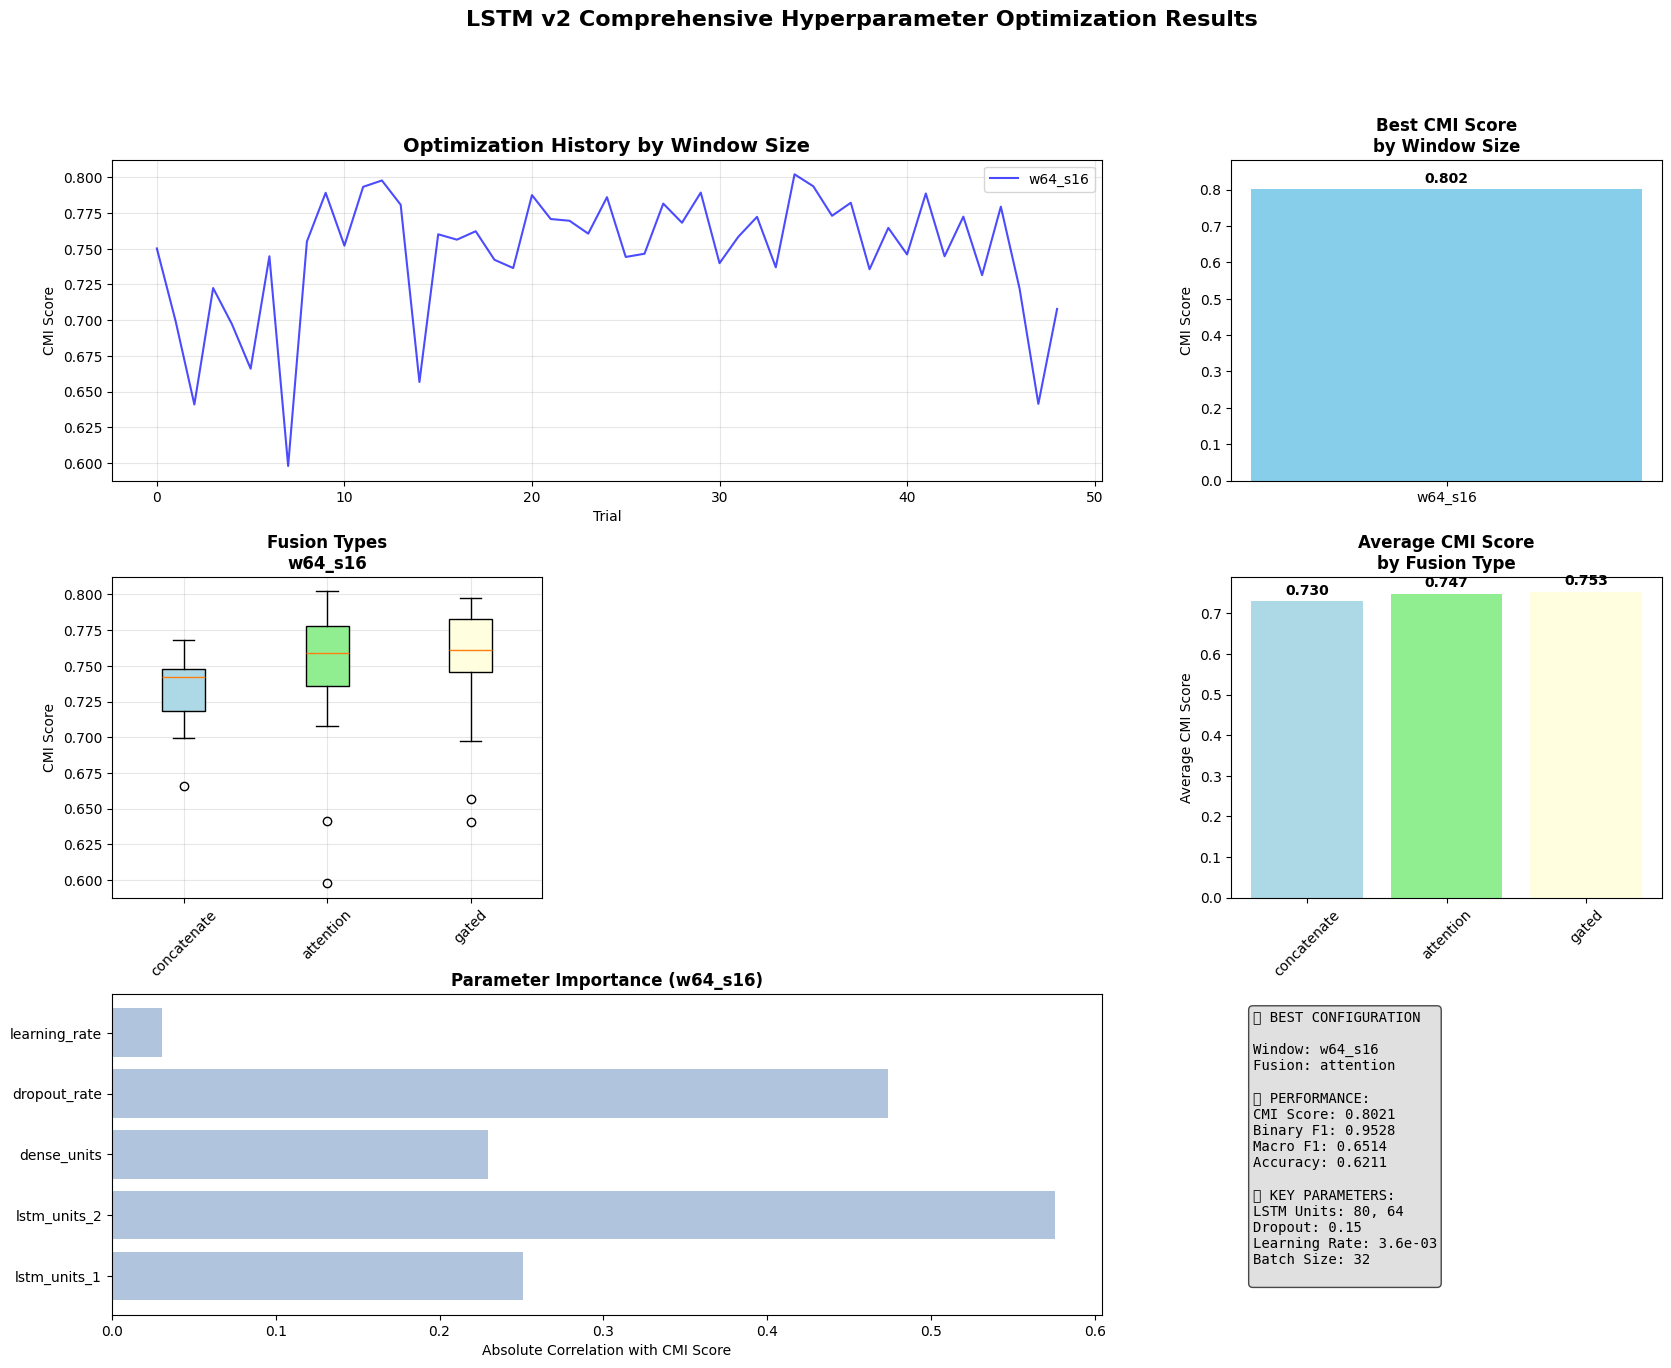

✅ 包括的結果グラフを保存: ../results/comprehensive_optimization/comprehensive_optimization_results.png


In [8]:
# 📈 包括的結果可視化
print("📈 包括的結果可視化")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

# 大きなフィギュアを作成
fig = plt.figure(figsize=(20, 15))

# サブプロット配置: 3行3列
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. ウィンドウサイズ別最適化履歴
ax1 = fig.add_subplot(gs[0, :2])
colors = ['blue', 'red', 'green', 'orange']
for i, (window_config, study) in enumerate(all_studies.items()):
    trials_values = [trial.value for trial in study.trials if trial.value is not None]
    if trials_values:
        ax1.plot(trials_values, label=f'{window_config}', color=colors[i % len(colors)], alpha=0.7)
ax1.set_title('Optimization History by Window Size', fontsize=14, fontweight='bold')
ax1.set_xlabel('Trial')
ax1.set_ylabel('CMI Score')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ウィンドウサイズ別CMIスコア比較
ax2 = fig.add_subplot(gs[0, 2])
window_names = []
cmi_scores = []
for window_config in WINDOW_CONFIGS:
    if window_config in optimization_results:
        window_names.append(window_config)
        cmi_scores.append(optimization_results[window_config]['best_cmi_score'])

if window_names:
    bars = ax2.bar(window_names, cmi_scores, color=['skyblue', 'lightcoral'])
    ax2.set_title('Best CMI Score\nby Window Size', fontsize=12, fontweight='bold')
    ax2.set_ylabel('CMI Score')
    ax2.set_ylim(0, max(cmi_scores) * 1.1)
    
    # 値をバーの上に表示
    for bar, score in zip(bars, cmi_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# 3-4. 各ウィンドウサイズでのFusion方式別スコア分布
for i, (window_config, study) in enumerate(all_studies.items()):
    ax = fig.add_subplot(gs[1, i])
    
    # Fusion方式別にスコアを集計
    fusion_scores = {ft: [] for ft in FUSION_TYPES}
    for trial in study.trials:
        if (trial.value is not None and 
            'fusion_type' in trial.user_attrs):
            fusion_type = trial.user_attrs['fusion_type']
            if fusion_type in fusion_scores:
                fusion_scores[fusion_type].append(trial.value)
    
    # boxplotデータを準備
    fusion_data = []
    fusion_labels = []
    for fusion_type in FUSION_TYPES:
        if fusion_scores[fusion_type]:
            fusion_data.append(fusion_scores[fusion_type])
            fusion_labels.append(fusion_type)
    
    if fusion_data:
        bp = ax.boxplot(fusion_data, patch_artist=True)
        ax.set_xticklabels(fusion_labels)
        # 色を設定
        colors_box = ['lightblue', 'lightgreen', 'lightyellow']
        for patch, color in zip(bp['boxes'], colors_box):
            patch.set_facecolor(color)
    
    ax.set_title(f'Fusion Types\n{window_config}', fontsize=12, fontweight='bold')
    ax.set_ylabel('CMI Score')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

# 5. 全体的なFusion方式比較
ax5 = fig.add_subplot(gs[1, 2])
all_fusion_scores = {ft: [] for ft in FUSION_TYPES}
for study in all_studies.values():
    for trial in study.trials:
        if (trial.value is not None and 
            'fusion_type' in trial.user_attrs):
            fusion_type = trial.user_attrs['fusion_type']
            if fusion_type in all_fusion_scores:
                all_fusion_scores[fusion_type].append(trial.value)

fusion_means = []
fusion_names = []
for fusion_type in FUSION_TYPES:
    if all_fusion_scores[fusion_type]:
        fusion_means.append(np.mean(all_fusion_scores[fusion_type]))
        fusion_names.append(fusion_type)

if fusion_means:
    bars = ax5.bar(fusion_names, fusion_means, color=['lightblue', 'lightgreen', 'lightyellow'])
    ax5.set_title('Average CMI Score\nby Fusion Type', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Average CMI Score')
    ax5.tick_params(axis='x', rotation=45)
    
    # 値をバーの上に表示
    for bar, score in zip(bars, fusion_means):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# 6. パラメータ重要度（全体）
ax6 = fig.add_subplot(gs[2, :2])
if best_overall_config and best_overall_config in all_studies:
    best_study = all_studies[best_overall_config]
    numeric_params = ['lstm_units_1', 'lstm_units_2', 'dense_units', 'dropout_rate', 'learning_rate']
    
    importances = []
    param_names = []
    
    for param in numeric_params:
        param_values = [trial.params.get(param) for trial in best_study.trials 
                       if trial.value is not None and param in trial.params]
        trial_values = [trial.value for trial in best_study.trials 
                       if trial.value is not None and param in trial.params]
        
        if len(param_values) > 3 and len(set(param_values)) > 1:
            correlation = np.corrcoef(param_values, trial_values)[0, 1]
            if not np.isnan(correlation):
                importances.append(abs(correlation))
                param_names.append(param)
    
    if importances:
        bars = ax6.barh(param_names, importances, color='lightsteelblue')
        ax6.set_title(f'Parameter Importance ({best_overall_config})', fontsize=12, fontweight='bold')
        ax6.set_xlabel('Absolute Correlation with CMI Score')

# 7. 最良設定サマリー
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')
if best_overall_config:
    best_results = optimization_results[best_overall_config]
    attrs = best_results['best_trial_attrs']
    
    summary_text = f"""🏆 BEST CONFIGURATION
    
Window: {best_overall_config}
Fusion: {attrs.get('fusion_type', 'N/A')}

📊 PERFORMANCE:
CMI Score: {best_results['best_cmi_score']:.4f}
Binary F1: {attrs.get('binary_f1', 0):.4f}
Macro F1: {attrs.get('macro_f1', 0):.4f}
Accuracy: {attrs.get('test_accuracy', 0):.4f}

🔧 KEY PARAMETERS:
LSTM Units: {best_results['best_params'].get('lstm_units_1', 'N/A')}, {best_results['best_params'].get('lstm_units_2', 'N/A')}
Dropout: {best_results['best_params'].get('dropout_rate', 'N/A'):.2f}
Learning Rate: {best_results['best_params'].get('learning_rate', 'N/A'):.1e}
Batch Size: {best_results['best_params'].get('batch_size', 'N/A')}
"""
    ax7.text(0.05, 0.95, summary_text, transform=ax7.transAxes, fontsize=10, 
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))

plt.suptitle('LSTM v2 Comprehensive Hyperparameter Optimization Results', 
             fontsize=16, fontweight='bold', y=0.98)

# 保存
plt.savefig(f'{RESULTS_DIR}/comprehensive_optimization_results.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✅ 包括的結果グラフを保存: {RESULTS_DIR}/comprehensive_optimization_results.png")


In [9]:
# 📊 詳細統計分析
print("📊 詳細統計分析")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

# ウィンドウサイズ別統計
for window_config in WINDOW_CONFIGS:
    if window_config in all_studies:
        study = all_studies[window_config]
        print(f"\n🔸 {window_config} 統計:")
        
        # Fusion方式別にスコアを集計
        fusion_scores = {ft: [] for ft in FUSION_TYPES}
        for trial in study.trials:
            if (trial.value is not None and 
                'fusion_type' in trial.user_attrs):
                fusion_type = trial.user_attrs['fusion_type']
                if fusion_type in fusion_scores:
                    fusion_scores[fusion_type].append(trial.value)
        
        for fusion_type in FUSION_TYPES:
            scores = fusion_scores[fusion_type]
            if scores:
                print(f"  {fusion_type}:")
                print(f"    試行数: {len(scores)}")
                print(f"    平均CMIスコア: {np.mean(scores):.4f}")
                print(f"    最大CMIスコア: {np.max(scores):.4f}")
                print(f"    最小CMIスコア: {np.min(scores):.4f}")
                print(f"    標準偏差: {np.std(scores):.4f}")
            else:
                print(f"  {fusion_type}: 試行なし")

# 全体統計
print(f"\n🔸 全体統計:")
total_trials = sum(len(study.trials) for study in all_studies.values())
successful_trials = sum(len([t for t in study.trials if t.value is not None]) 
                       for study in all_studies.values())
print(f"  総試行数: {total_trials}")
print(f"  成功試行数: {successful_trials}")
print(f"  成功率: {successful_trials/total_trials*100:.1f}%" if total_trials > 0 else "  成功率: N/A")


📊 詳細統計分析
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔸 w64_s16 統計:
  concatenate:
    試行数: 7
    平均CMIスコア: 0.7299
    最大CMIスコア: 0.7682
    最小CMIスコア: 0.6660
    標準偏差: 0.0324
  attention:
    試行数: 22
    平均CMIスコア: 0.7472
    最大CMIスコア: 0.8021
    最小CMIスコア: 0.5979
    標準偏差: 0.0475
  gated:
    試行数: 20
    平均CMIスコア: 0.7526
    最大CMIスコア: 0.7978
    最小CMIスコア: 0.6410
    標準偏差: 0.0422

🔸 全体統計:
  総試行数: 50
  成功試行数: 49
  成功率: 98.0%


In [10]:
# 🎯 最良設定での最終学習と本番評価
if best_overall_config and best_overall_config in optimization_results:
    print("🎯 最良設定での最終学習")
    print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    
    best_results = optimization_results[best_overall_config]
    best_params = best_results['best_params'].copy()
    
    # 本番用学習設定で上書き
    best_params.update({
        'epochs': 150,  # 本番用：十分なエポック数
        'patience': 30,  # 本番用：長めの早期停止
        'reduce_lr_patience': 15,  # 本番用：長めの学習率削減待機
        'use_tqdm': True,  # 本番用：進捗表示ON
        'use_tensorboard': True  # 本番用：ログ記録ON
    })
    
    print(f"最良設定: {best_overall_config}")
    print(f"Fusion方式: {best_params['fusion_type']}")
    print(f"本番用学習設定適用済み")
    
    # 最終トレーナー作成
    final_trainer = LSTMv2Trainer(
        experiment_name="production_best_model",
        window_config=best_overall_config,
        n_demographics_features=18 if USE_OPTIMIZED_DEMOGRAPHICS else 20
    )
    
    # データ読み込み
    final_data = final_trainer.load_preprocessed_data(use_optimized_demographics=USE_OPTIMIZED_DEMOGRAPHICS)
    
    print(f"\n🚀 本番用最終学習開始...")
    print(f"   エポック数: {best_params['epochs']}")
    print(f"   早期停止: {best_params['patience']} エポック")
    
    # 最終学習実行
    final_results = final_trainer.train_model(
        final_data, 
        model_params=best_params, 
        fusion_type=best_params['fusion_type']
    )
    
    # 最終評価
    final_predictions = final_results['results']['predictions']
    # label_encoderを取得
    final_label_encoder = final_data['label_encoder'] if 'label_encoder' in final_data else None
    
    final_cmi_score, final_binary_f1, final_macro_f1, final_test_accuracy = calculate_cmi_score(
        final_predictions,  # y_pred
        final_results['test_data'][2],  # y_true
        label_encoder=final_label_encoder,
        verbose=True  # 最終評価では詳細ログを表示
    )
    
    print(f"\n🏆 最終本番結果")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    print(f"ウィンドウ設定: {best_overall_config}")
    print(f"Fusion方式: {best_params['fusion_type']}")
    print(f"CMI Score: {final_cmi_score:.4f}")
    print(f"Binary F1: {final_binary_f1:.4f}")
    print(f"Macro F1: {final_macro_f1:.4f}")
    print(f"Test Accuracy: {final_test_accuracy:.4f}")
    
    # 包括的結果サマリー保存
    comprehensive_summary = {
        'experiment_info': {
            'study_base_name': STUDY_BASE_NAME,
            'window_configs': WINDOW_CONFIGS,
            'fusion_types': FUSION_TYPES,
            'trials_per_config': N_TRIALS_PER_CONFIG,
            'use_optimized_demographics': USE_OPTIMIZED_DEMOGRAPHICS,
            'timestamp': pd.Timestamp.now().isoformat()
        },
        'optimization_results': optimization_results,
        'best_overall': {
            'window_config': best_overall_config,
            'cmi_score': best_overall_score,
            'configuration': best_results
        },
        'final_evaluation': {
            'cmi_score': final_cmi_score,
            'binary_f1': final_binary_f1,
            'macro_f1': final_macro_f1,
            'test_accuracy': final_test_accuracy,
            'final_params': best_params
        }
    }
    
    # JSON保存
    summary_path = f'{RESULTS_DIR}/comprehensive_optimization_summary.json'
    with open(summary_path, 'w', encoding='utf-8') as f:
        json.dump(comprehensive_summary, f, indent=2, ensure_ascii=False)
    
    print(f"\n✅ 包括的結果サマリー保存: {summary_path}")
    
else:
    print("❌ 最良設定が見つかりません。最適化が正常に完了していない可能性があります。")


🎯 最良設定での最終学習
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
最良設定: w64_s16
Fusion方式: attention
本番用学習設定適用済み
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: production_best_model
ウィンドウ設定: w64_s16
出力ディレクトリ: ../output/experiments/production_best_model_w64_s16
前処理済みデータ: ../output/experiments/lstm_v2_w64_s16/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (13393, 64, 332)
  Demographics: (13393, 18)
  ラベル: (13393,)
  クラス数: 18

🚀 本番用最終学習開始...
   エポック数: 150
   早期停止: 30 エポック
ハイブリッドモデル学習開始 (融合方式: attention)...
データ分割中...
テストサイズ: 0.2
検証サイズ: 0.2
データ分割完了:
  訓練 - センサー: (8571, 64, 332), Demographics: (8571, 18), ラベル: (8571,)
  検証 - センサー: (2143, 64, 332), Demographics: (2143, 18), ラベル: (2143,)
  テスト - センサー: (2679, 64, 332), Demographics: (2679, 18), ラベル: (2679,)
入力形状:
  センサー: (64, 332)
  Demographics: (18,)
  クラス数: 18
GPU上で

Model: "lstm_v2_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 64, 332)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64, 80)    │    132,160 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_1           │ (None, 64, 80)    │        320 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 64, 80)    │          0 │ lstm_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_input  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     37,120 │ lstm_dropout_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 24)        │        456 │ demographics_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_bn_2           │ (None, 64)        │        256 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 24)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_2      │ (None, 64)        │          0 │ lstm_bn_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dense… │ (None, 24)        │        600 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dense        │ (None, 48)        │      3,120 │ lstm_dropout_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_dropo… │ (None, 24)        │          0 │ demographics_den… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sensor_dropout      │ (None, 48)        │          0 │ sensor_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 48)        │      1,200 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attended_sensor     │ (None, 48)        │          0 │ sensor_dropout[0… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ demographics_proje… │ (None, 48)        │      1,200 │ demographics_dro… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 179,666 (701.82 KB)

 Trainable params: 179,378 (700.70 KB)

 Non-trainable params: 288 (1.12 KB)

ハイブリッドモデル学習開始...
センサー訓練データ形状: (8571, 64, 332)
Demographics訓練データ形状: (8571, 18)
センサー検証データ形状: (2143, 64, 332)
Demographics検証データ形状: (2143, 18)
訓練ラベル形状: (8571,)
検証ラベル形状: (2143,)
TensorBoard ログ: logs


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 1: val_loss improved from inf to 2.52852, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 2: val_loss improved from 2.52852 to 2.32734, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 3: val_loss improved from 2.32734 to 2.23067, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 4: val_loss improved from 2.23067 to 2.16490, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 5: val_loss improved from 2.16490 to 2.14171, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 6: val_loss improved from 2.14171 to 2.11092, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 7: val_loss did not improve from 2.11092

Epoch 8: val_loss improved from 2.11092 to 2.10255, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 9: val_loss improved from 2.10255 to 2.01515, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 10: val_loss did not improve from 2.01515

Epoch 11: val_loss improved from 2.01515 to 1.98635, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 12: val_loss did not improve from 1.98635

Epoch 13: val_loss did not improve from 1.98635

Epoch 14: val_loss did not improve from 1.98635

Epoch 15: val_loss improved from 1.98635 to 1.91350, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 16: val_loss did not improve from 1.91350

Epoch 17: val_loss did not improve from 1.91350

Epoch 18: val_loss did not improve from 1.91350

Epoch 19: val_loss did not improve from 1.91350

Epoch 20: val_loss did not improve from 1.91350

Epoch 21: val_loss improved from 1.91350 to 1.89991, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 22: val_loss did not improve from 1.89991

Epoch 23: val_loss did not improve from 1.89991

Epoch 24: val_loss did not improve from 1.89991

Epoch 25: val_loss did not improve from 1.89991

Epoch 26: val_loss improved from 1.89991 to 1.88939, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 27: val_loss did not improve from 1.88939

Epoch 28: val_loss did not improve from 1.88939

Epoch 29: val_loss did not improve from 1.88939

Epoch 30: val_loss did not improve from 1.88939

Epoch 31: val_loss improved from 1.88939 to 1.88132, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 32: val_loss improved from 1.88132 to 1.87781, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 33: val_loss improved from 1.87781 to 1.84725, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 34: val_loss did not improve from 1.84725

Epoch 35: val_loss did not improve from 1.84725

Epoch 36: val_loss improved from 1.84725 to 1.83408, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 37: val_loss did not improve from 1.83408

Epoch 38: val_loss improved from 1.83408 to 1.80600, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 39: val_loss did not improve from 1.80600

Epoch 40: val_loss did not improve from 1.80600

Epoch 41: val_loss did not improve from 1.80600

Epoch 42: val_loss did not improve from 1.80600

Epoch 43: val_loss did not improve from 1.80600

Epoch 44: val_loss did not improve from 1.80600

Epoch 45: val_loss improved from 1.80600 to 1.77423, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 46: val_loss did not improve from 1.77423

Epoch 47: val_loss did not improve from 1.77423

Epoch 48: val_loss did not improve from 1.77423

Epoch 49: val_loss did not improve from 1.77423

Epoch 50: val_loss did not improve from 1.77423

Epoch 51: val_loss did not improve from 1.77423

Epoch 52: val_loss did not improve from 1.77423

Epoch 53: val_loss did not improve from 1.77423

Epoch 54: val_loss did not improve from 1.77423

Epoch 55: val_loss did not improve from 1.77423

Epoch 56: val_loss did not improve from 1.77423

Epoch 57: val_loss did not improve from 1.77423

Epoch 58: val_loss did not improve from 1.77423

Epoch 59: val_loss did not improve from 1.77423

Epoch 60: val_loss did not improve from 1.77423

Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0018012771615758538.

Epoch 61: val_loss improved from 1.77423 to 1.67632, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 62: val_loss did not improve from 1.67632

Epoch 63: val_loss did not improve from 1.67632

Epoch 64: val_loss did not improve from 1.67632

Epoch 65: val_loss did not improve from 1.67632

Epoch 66: val_loss did not improve from 1.67632

Epoch 67: val_loss did not improve from 1.67632

Epoch 68: val_loss did not improve from 1.67632

Epoch 69: val_loss did not improve from 1.67632

Epoch 70: val_loss did not improve from 1.67632

Epoch 71: val_loss improved from 1.67632 to 1.66813, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 72: val_loss did not improve from 1.66813

Epoch 73: val_loss improved from 1.66813 to 1.66406, saving model to ../output/experiments/production_best_model_w64_s16/models/lstm_v2_hybrid_attention_best.h5



Epoch 74: val_loss did not improve from 1.66406

Epoch 75: val_loss did not improve from 1.66406

Epoch 76: val_loss did not improve from 1.66406

Epoch 77: val_loss did not improve from 1.66406

Epoch 78: val_loss did not improve from 1.66406

Epoch 79: val_loss did not improve from 1.66406

Epoch 80: val_loss did not improve from 1.66406

Epoch 81: val_loss did not improve from 1.66406

Epoch 82: val_loss did not improve from 1.66406

Epoch 83: val_loss did not improve from 1.66406

Epoch 84: val_loss did not improve from 1.66406

Epoch 85: val_loss did not improve from 1.66406

Epoch 86: val_loss did not improve from 1.66406

Epoch 87: val_loss did not improve from 1.66406

Epoch 88: val_loss did not improve from 1.66406

Epoch 88: ReduceLROnPlateau reducing learning rate to 0.0009006385807879269.

Epoch 89: val_loss did not improve from 1.66406

Epoch 90: val_loss did not improve from 1.66406

Epoch 91: val_loss did not improve from 1.66406

Epoch 92: val_loss did not improve from

In [11]:
# 🔧 学習済みモデルの保存と配布準備
if best_overall_config and 'final_results' in locals():
    print("🔧 学習済みモデルの保存")
    print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    
    # 最良モデルの保存
    model_save_dir = f"{RESULTS_DIR}/production_model"
    os.makedirs(model_save_dir, exist_ok=True)
    
    # モデルファイル保存
    model_path = f"{model_save_dir}/best_lstm_v2_model.h5"
    final_results['model'].save_model(model_path)
    
    # 設定ファイル保存
    model_config = {
        'window_config': best_overall_config,
        'model_architecture': final_results['model'].get_config(),
        'hyperparameters': best_params,
        'performance': {
            'cmi_score': final_cmi_score,
            'binary_f1': final_binary_f1,
            'macro_f1': final_macro_f1,
            'test_accuracy': final_test_accuracy
        },
        'data_preprocessing': {
            'use_optimized_demographics': USE_OPTIMIZED_DEMOGRAPHICS,
            'n_demographics_features': 18 if USE_OPTIMIZED_DEMOGRAPHICS else 20,
            'n_sensor_features': 332,
            'n_classes': 18
        }
    }
    
    config_path = f"{model_save_dir}/model_config.json"
    with open(config_path, 'w', encoding='utf-8') as f:
        json.dump(model_config, f, indent=2, ensure_ascii=False)
    
    # README作成
    readme_content = f"""# LSTM v2 Production Model

## Model Information
- **Model Type**: LSTM v2 Hybrid (Sensor + Demographics)
- **Window Configuration**: {best_overall_config}
- **Fusion Method**: {best_params['fusion_type']}
- **CMI Score**: {final_cmi_score:.4f}

## Performance Metrics
- Binary F1 Score: {final_binary_f1:.4f}
- Macro F1 Score: {final_macro_f1:.4f}
- Test Accuracy: {final_test_accuracy:.4f}

## Model Architecture
- LSTM Units: {best_params.get('lstm_units_1', 'N/A')}, {best_params.get('lstm_units_2', 'N/A')}
- Dense Units: {best_params.get('dense_units', 'N/A')}
- Dropout Rate: {best_params.get('dropout_rate', 'N/A'):.2f}
- Learning Rate: {best_params.get('learning_rate', 'N/A'):.1e}
- Batch Size: {best_params.get('batch_size', 'N/A')}

## Files
- `best_lstm_v2_model.h5`: Trained model weights
- `model_config.json`: Complete model configuration
- `comprehensive_optimization_summary.json`: Optimization results

## Usage
```python
from src.lstm_v2_trainer import LSTMv2Trainer

# Load the trained model
trainer = LSTMv2Trainer(
    experiment_name="production",
    window_config="{best_overall_config}",
    n_demographics_features={18 if USE_OPTIMIZED_DEMOGRAPHICS else 20}
)

# Load model weights
trainer.model.load_model("{model_path}")
```

Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""
    
    readme_path = f"{model_save_dir}/README.md"
    with open(readme_path, 'w', encoding='utf-8') as f:
        f.write(readme_content)
    
    print(f"✅ モデル保存完了:")
    print(f"   モデルファイル: {model_path}")
    print(f"   設定ファイル: {config_path}")
    print(f"   README: {readme_path}")
    
else:
    print("❌ 最終学習が完了していないため、モデル保存をスキップします。")


🔧 学習済みモデルの保存
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
モデル保存エラー: The filename must end in `.weights.h5`. Received: filepath=../results/comprehensive_optimization/production_model/best_lstm_v2_model_weights.h5
基本モデル保存完了: ../results/comprehensive_optimization/production_model/best_lstm_v2_model.h5
✅ モデル保存完了:
   モデルファイル: ../results/comprehensive_optimization/production_model/best_lstm_v2_model.h5
   設定ファイル: ../results/comprehensive_optimization/production_model/model_config.json
   README: ../results/comprehensive_optimization/production_model/README.md


In [12]:
# 🎉 包括的ハイパーパラメータ最適化完了
print("🎉 包括的ハイパーパラメータ最適化完了")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

print("📋 実行サマリー:")
print(f"   ウィンドウ設定: {len(WINDOW_CONFIGS)}種類 ({', '.join(WINDOW_CONFIGS)})")
print(f"   Fusion方式: {len(FUSION_TYPES)}種類 ({', '.join(FUSION_TYPES)})")
print(f"   計画試行数: {N_TRIALS_PER_CONFIG * len(WINDOW_CONFIGS)}")

if all_studies:
    total_completed = sum(len([t for t in study.trials if t.value is not None]) 
                         for study in all_studies.values())
    print(f"   完了試行数: {total_completed}")

if best_overall_config:
    print(f"\n🏆 最終結果:")
    print(f"   最良設定: {best_overall_config}")
    print(f"   最良CMIスコア: {best_overall_score:.4f}")
    
    if 'final_cmi_score' in locals():
        print(f"   本番評価CMIスコア: {final_cmi_score:.4f}")

print(f"\n📁 生成ファイル:")
print(f"   📊 可視化: {RESULTS_DIR}/comprehensive_optimization_results.png")
print(f"   📄 結果サマリー: {RESULTS_DIR}/comprehensive_optimization_summary.json")
if best_overall_config and 'final_results' in locals():
    print(f"   🤖 本番モデル: {RESULTS_DIR}/production_model/")

print(f"\n💡 次のステップ:")
print(f"   1. 可視化結果を確認して、ウィンドウサイズとFusion方式の影響を分析")
print(f"   2. 本番モデルを使用してテストデータでの予測を実行")
print(f"   3. 必要に応じて、さらなるパラメータ調整や手法改善を検討")

print(f"\n✨ 最適化実験完了！お疲れ様でした！")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")


🎉 包括的ハイパーパラメータ最適化完了
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📋 実行サマリー:
   ウィンドウ設定: 1種類 (w64_s16)
   Fusion方式: 3種類 (concatenate, attention, gated)
   計画試行数: 50
   完了試行数: 49

🏆 最終結果:
   最良設定: w64_s16
   最良CMIスコア: 0.8021
   本番評価CMIスコア: 0.7929

📁 生成ファイル:
   📊 可視化: ../results/comprehensive_optimization/comprehensive_optimization_results.png
   📄 結果サマリー: ../results/comprehensive_optimization/comprehensive_optimization_summary.json
   🤖 本番モデル: ../results/comprehensive_optimization/production_model/

💡 次のステップ:
   1. 可視化結果を確認して、ウィンドウサイズとFusion方式の影響を分析
   2. 本番モデルを使用してテストデータでの予測を実行
   3. 必要に応じて、さらなるパラメータ調整や手法改善を検討

✨ 最適化実験完了！お疲れ様でした！
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


🚀 包括的最適化開始
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 w128_s32 での最適化開始
==================================================
[I 2025-07-08 06:00:55,630] A new study created in RDB with name: lstm_v2_comprehensive_optimization_w128_s32
Study名: lstm_v2_comprehensive_optimization_w128_s32
既存試行数: 0
実行する試行数: 50

🔍 Trial 0 - w128_s32
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_0_w128_s32
ウィンドウ設定: w128_s32
出力ディレクトリ: ../output/experiments/trial_0_w128_s32_w128_s32
前処理済みデータ: ../output/experiments/lstm_v2_w128_s32/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
[I 2025-07-08 06:01:00,045] Trial 0 finished with value: 0.0 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dense_units': 56, 'demographics_dense_units': 24, 'fusion_dense_units': 16, 'dropout_rate': 0.15000000000000002, 'dense_dropout_rate': 0.1, 'learning_rate': 0.005399484409787433, 'batch_size': 32, 'fusion_type': 'concatenate'}. Best is trial 0 with value: 0.0.
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (8673, 128, 332)
  Demographics: (13393, 18)
  ラベル: (8673,)
  クラス数: 18
❌ Trial 0 failed: データサイズが一致しません

🔍 Trial 1 - w128_s32
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_1_w128_s32
ウィンドウ設定: w128_s32
出力ディレクトリ: ../output/experiments/trial_1_w128_s32_w128_s32
前処理済みデータ: ../output/experiments/lstm_v2_w128_s32/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
[I 2025-07-08 06:01:05,143] Trial 1 finished with value: 0.0 and parameters: {'lstm_units_1': 48, 'lstm_units_2': 24, 'dense_units': 32, 'demographics_dense_units': 20, 'fusion_dense_units': 32, 'dropout_rate': 0.2, 'dense_dropout_rate': 0.30000000000000004, 'learning_rate': 0.00019010245319870352, 'batch_size': 64, 'fusion_type': 'concatenate'}. Best is trial 0 with value: 0.0.
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (8673, 128, 332)
  Demographics: (13393, 18)
  ラベル: (8673,)
  クラス数: 18
❌ Trial 1 failed: データサイズが一致しません

🔍 Trial 2 - w128_s32
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_2_w128_s32
ウィンドウ設定: w128_s32
出力ディレクトリ: ../output/experiments/trial_2_w128_s32_w128_s32
前処理済みデータ: ../output/experiments/lstm_v2_w128_s32/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
[I 2025-07-08 06:01:09,597] Trial 2 finished with value: 0.0 and parameters: {'lstm_units_1': 96, 'lstm_units_2': 16, 'dense_units': 48, 'demographics_dense_units': 12, 'fusion_dense_units': 16, 'dropout_rate': 0.5, 'dense_dropout_rate': 0.4, 'learning_rate': 0.004138040112561018, 'batch_size': 64, 'fusion_type': 'gated'}. Best is trial 0 with value: 0.0.
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (8673, 128, 332)
  Demographics: (13393, 18)
  ラベル: (8673,)
  クラス数: 18
❌ Trial 2 failed: データサイズが一致しません

🔍 Trial 3 - w128_s32
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_3_w128_s32
ウィンドウ設定: w128_s32
出力ディレクトリ: ../output/experiments/trial_3_w128_s32_w128_s32
前処理済みデータ: ../output/experiments/lstm_v2_w128_s32/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
[I 2025-07-08 06:01:14,032] Trial 3 finished with value: 0.0 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dense_units': 24, 'demographics_dense_units': 24, 'fusion_dense_units': 24, 'dropout_rate': 0.30000000000000004, 'dense_dropout_rate': 0.25, 'learning_rate': 0.00023426581058204064, 'batch_size': 16, 'fusion_type': 'gated'}. Best is trial 0 with value: 0.0.
最適化されたdemographics特徴量を使用します
最適化されたdemographics形状: (13393, 18)
データ読み込み完了:
  センサーデータ: (8673, 128, 332)
  Demographics: (13393, 18)
  ラベル: (8673,)
  クラス数: 18
❌ Trial 3 failed: データサイズが一致しません

🔍 Trial 4 - w128_s32
Mixed precision enabled for better GPU performance
GPU利用可能: 1台
使用GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
LSTM v2学習環境初期化完了
実験名: trial_4_w128_s32
ウィンドウ設定: w128_s32
出力ディレクトリ: ../output/experiments/trial_4_w128_s32_w128_s32
前処理済みデータ: ../output/experiments/lstm_v2_w128_s32/preprocessed
GPU利用可能: True
前処理済みデータを読み込み中...
[W 2025-07-08 06:01:18,120] Trial 4 failed with parameters: {'lstm_units_1': 32, 'lstm_units_2': 24, 'dense_units': 16, 'demographics_dense_units': 16, 'fusion_dense_units': 24, 'dropout_rate': 0.2, 'dense_dropout_rate': 0.35, 'learning_rate': 0.0005170191786366995, 'batch_size': 32, 'fusion_type': 'gated'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/mnt/c/Users/ShunK/works/CMI_comp/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_54757/3908953550.py", line 59, in objective
    data = trainer.load_preprocessed_data(use_optimized_demographics=USE_OPTIMIZED_DEMOGRAPHICS)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/c/Users/ShunK/works/CMI_comp/notebooks/../src/lstm_v2_trainer.py", line 124, in load_preprocessed_data
    X_sensor_windows = pickle.load(f)
                       ^^^^^^^^^^^^^^
KeyboardInterrupt
[W 2025-07-08 06:01:18,122] Trial 4 failed with value None.